# GNN CODE 

Installs:

In [1]:
#!pip install torch
#!pip install torch_scatter
#!pip install torch_sparse
#!pip install torch_geometric
#!pip install sklearn
#!pip install networkx
#!pip install metaknowledge
#!pip install matplotlib

Imports:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import InMemoryDataset, Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler
import metaknowledge as mk
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Data Import Functions:

In [3]:
def network_import(file_txt):
    #lists to hold outputs
    networks = []
    masks = []
    
    #creates core, non-core and mixed networks from .txt files
    RC = mk.RecordCollection(file_txt)
    network1 = RC.networkCitation(nodeType='full',coreOnly=True)
    network1 = nx.Graph(network1)
    network1 = network1.to_undirected()
    c1 = list(network1.nodes)
    
    network2 = RC.networkCitation(nodeType='full',coreOnly=False)
    network2 = nx.Graph(network2)
    network2 = network2.to_undirected()

    network3 = nx.compose(network1,network2)
    
    #creates sub-graphs from mixed network
    sub_graphs = (network3.subgraph(c).copy() for c in nx.connected_components(network3))
    
    #loops for nodes in each subgraph
    for idx,g in enumerate(sub_graphs,start=1):
        
        #creates initial variables for an index list and mask
        index=[]
        mask = torch.zeros(g.number_of_nodes(), dtype=torch.bool)
        
        #only uses if sub-graphs above a size of 1000 nodes
        if len(g.nodes())>1000:
            c2 = list(g.nodes)
            #print(c2)
            
            #loops for mixed nodes
            for i in range(0,len(c2)):
                
                #loops for all core nodes
                for nodes2 in c1:
                    
                    #records index of core node in mixed network
                    if c2[i]==nodes2:
                        index.append(i)
                        
            #creates mask using index of core nodes
            mask[index] = True
            #adds network and mask to list
            networks.append(g)
            masks.append(mask)
    #outputs list of networks and masks
    return networks, masks

def panda_import(file_csv):
    #reads file as dataframe, drops duplicates and resets index as needed
    panda = pd.read_csv(file_csv)
    panda.drop_duplicates()
    panda.reset_index()
    return panda

Data Setup Function:

In [4]:
scaler = StandardScaler()
def data_setup(G,df):
    
    #creates edge index from network
    adj = nx.to_scipy_sparse_matrix(G).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    
    #creates labels from dataframe
    labels = ((df['FR'].to_numpy()).astype(np.compat.long))
    
    #scales imported centralities of nodes
    df[['DC','EC','LC','BC','CC']] = scaler.fit_transform(df[['DC','EC','LC','BC','CC']])

    #reformats dataframe as numpy array
    embeddings = ((df[['DC','EC','LC','BC','CC']]).to_numpy().astype(np.float64))

    #returns variables
    return labels,edge_index,embeddings,G

Dataset Class:

In [5]:
#defines custom data class
class GNNDataset(InMemoryDataset):
    def __init__(self, Mask, transform=None):
        super(GNNDataset, self).__init__('.', transform, None, None)

        # edge index
        data = Data(edge_index=edge_index)
        
        # number of nodes
        data.num_nodes = G.number_of_nodes()
        
        # embedding data
        data.x = torch.from_numpy(embeddings.copy()).type(torch.float32)
        
        data.num_features  = np.size(embeddings, 1)
        
        # labels
        y = torch.from_numpy(labels.copy()).type(torch.long)
        data.y = y.clone().detach()
        
        # core node mask
        data['mask'] = Mask
        
        # class data
        data.num_classes = 2

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

Creating Dataset:

In [6]:
#imports dataset
JOPCS, JOPCS_Masks = network_import("JOPCS_t.txt")
AMM, AMM_Masks = network_import("AMM_t.txt")
IJEEEE, IJEEEE_Masks = network_import("IJEEEE_t.txt")
JMS, JMS_Masks = network_import("JMS_t.txt") 

#ensures imports correctly due to multiple subgraphs in one dataset
c=0
if len(list(JOPCS[0].nodes))!= 4883:
    c=1
while c==1:
    #print(c,len(list(JOPCS[0].nodes)),len(list(JOPCS[1].nodes)))
    temp1 = JOPCS.copy()
    JOPCS[0]=temp1[1]
    JOPCS[1]=temp1[0]
    
    temp2 = JOPCS_Masks.copy()
    JOPCS_Masks[0]=temp2[1]
    JOPCS_Masks[1]=temp2[0]
    
    if len(list(JOPCS[0].nodes)) == 4883:
        c=0

#creates and orders dataset variable
JOPCS1 = panda_import('JOPCS_Cent_1.csv')
JOPCS1.ND = JOPCS1.ND.astype("category")
JOPCS1.ND.cat.set_categories([' Filler1']+list(JOPCS[0].nodes), inplace=True)
#print(JOPCS1['ND']) 
JOPCS1 = JOPCS1.sort_values(["ND"], ignore_index=True)
#print(JOPCS1['ND'])
JOPCS1.reset_index()

#creates and orders dataset variable
JOPCS2 = panda_import('JOPCS_Cent_2.csv')
JOPCS2.ND = JOPCS2.ND.astype("category")
JOPCS2.ND.cat.set_categories([' Filler2']+list(JOPCS[1].nodes), inplace=True)
#print(JOPCS2['ND'])
JOPCS2 = JOPCS2.sort_values(["ND"], ignore_index=True)
#print(JOPCS2['ND'])
JOPCS2.reset_index()

#creates and orders dataset variable
AMM1 = panda_import('AMM_Cent_1.csv')
AMM1.ND = AMM1.ND.astype("category")
AMM1.ND.cat.set_categories([' Filler3']+list(AMM[0].nodes), inplace=True)
#print(AMM1['ND'])
AMM1 = AMM1.sort_values(["ND"], ignore_index=True)
#print(AMM1['ND'])
AMM1.reset_index()

#creates and orders dataset variable
IJEEEE1 = panda_import('IJEEEE_Cent_1.csv')
IJEEEE1.ND = IJEEEE1.ND.astype("category")
IJEEEE1.ND.cat.set_categories([' Filler4']+list(IJEEEE[0].nodes), inplace=True)
#print(IJEEEE1['ND'])
IJEEEE1 = IJEEEE1.sort_values(["ND"], ignore_index=True)
#print(IJEEEE1['ND'])
IJEEEE1.reset_index()

#creates and orders dataset variable
JMS1 = panda_import('JMS_Cent_1.csv')
JMS1.ND = JMS1.ND.astype("category")
JMS1.ND.cat.set_categories([' Filler5']+list(JMS[0].nodes), inplace=True)
#print(JMS1['ND'])
JMS1 = JMS1.sort_values(["ND"], ignore_index=True)
#print(JMS1['ND'])axis=0,ignore_index=Tru
JMS1.reset_index()

#merges masks
Mask = torch.cat((JOPCS_Masks[0],JOPCS_Masks[1],AMM_Masks[0],IJEEEE_Masks[0],JMS_Masks[0]))

#merges datasets
Node_Data = pd.concat([JOPCS1,JOPCS2,AMM1,IJEEEE1,JMS1],axis=0,ignore_index=True)

#merges networks
G = nx.disjoint_union(JOPCS[0],JOPCS[1])
G = nx.disjoint_union(G,AMM[0])
G = nx.disjoint_union(G,IJEEEE[0])
G = nx.disjoint_union(G,JMS[0])

#sets up data and creates custom dataset
labels,edge_index,embeddings,G = data_setup(G,Node_Data)
Dataset = GNNDataset(Mask)


Resampling Data:

In [7]:
#splits data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(pd.Series(list(G.nodes())), pd.Series(labels), test_size=0.30, random_state=42)

#oversamples cases of fraud
X = pd.concat([X_train, Y_train], axis=1)

#splits fraud and non-fraud index
not_fraud = X[X[1]==0]
fraud = X[X[1]==1]
n = 1500

#resamples index as needed
fraud_upsampled = resample(fraud,replace=True, n_samples= n , random_state=42) 

#merges indexes
X_up = pd.concat([not_fraud, fraud_upsampled])

#changes used variables to over sampled ones
X_train = X_up[0].copy()
Y_train = X_up[1].copy()

GNN Model Class Creation:

In [8]:
#defines model with five layers and both uses dropout and hyperbolic tangent normalisation
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.conv1 = nn.Linear(5, 4)
        self.conv2 = nn.Linear(4, 4)
        self.conv3 = nn.Linear(4, 2)
        self.classifier = nn.Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x)
        h = h.tanh()
        h = F.dropout(h, training=self.training)
        h = self.conv2(h)
        h = h.tanh()
        h = F.dropout(h, training=self.training)
        h = self.conv3(h)
        h = h.tanh()
        out = self.classifier(h)
        return out, h

Training Model:

In [9]:
#sets seed
torch.manual_seed(42)

#uses GPU is possible
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
model = NNModel().to(device)

#sets criterion as Cross Entropy Loss and learning rate as 0.1
criterion = torch.nn.CrossEntropyLoss()
learn_rate=0.1

#sets optimiser as AdaDelta (stochastic gradient descent)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learn_rate, weight_decay=1e-4)

#defines a training function
def train(data,mask1):
    #resets gradient
    optimizer.zero_grad()
    
    #uses model to give outputs
    out, h = model(data[0].x, data[0].edge_index)
    
    #finds loss of model and its current outputs
    loss = criterion(out[torch.tensor(list(mask1))[torch.index_select(data[0]['mask'], 0, torch.tensor(list(mask1)))]],
        data[0].y[torch.tensor(list(mask1))[torch.index_select(data[0]['mask'], 0, torch.tensor(list(mask1)))]])
    
    #performs gradient descent
    loss.backward()
    optimizer.step()
    
    #returns loss
    return loss.item()

#sets up variables
embeddings = []
outs=[]
epochs = range(0, int((10000)/5))
count=0
counts=[]

losses_val = []
losses_train = []
losses_val_temp = []
losses_train_temp = []  
indx=[]

tps=[]
fps=[]
tns=[]
fns=[]
tprs=[]
tnrs=[]
accs=[]

#cross validation training split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#counting variable
y=0

#loops for 5*epochs
for epoch in epochs:
    
    #splits data and loops for all splits
    for train_index, test_index in sss.split(X_train,Y_train):
        
        #creates training and validation test indexes
        train_index = X_train.copy().iloc[train_index]
        test_index = X_train.copy().iloc[test_index]
        
        #fins loss using function
        loss = train(Dataset,train_index)
        count+=1
        
        #saves trainign and validation losses
        if (epoch%20)==0:
            #training loss
            losses_train_temp.append(loss)
            
            #validation loss
            out, h = model(Dataset[0].x,Dataset[0].edge_index)
            losses_val_temp.append(criterion(out[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]],Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).item())
            
            #averages and records losses
            if len(losses_train_temp) == 5:
                indx.append(count-1)
                losses_train.append(np.mean(losses_train_temp))
                losses_val.append(np.mean(losses_val_temp))
                losses_val_temp = []
                losses_train_temp = []            
        
        #saves a range of variables form validation data & prints it
        if (epoch%100)==0:
            out = (out[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).max(1)[1]
            h = (h[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])
            counts.append(count)
            outs.append(out)
            embeddings.append(h)
            
            #saves true positives, false positives, true negatives, false negatives and accuracy
            tp = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==1]).sum().item()
            fp = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==0]).sum().item()
            tn = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==0]==0).sum().item()
            fn = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==1]==0).sum().item()
            acc1 = out.eq(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).sum()
            acc2 = Dataset[0]['mask'][torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]].sum()
            acc =  acc1/acc2 
            
            #finds true positive/negative rates
            if tp!=0 or fn!=0:
                tpr = tp/(tp+fn)
            else:
                tpr = -0.0
                
            if tn!=0 or fp!=0:
                tnr = tn/(tn+fp)
            else:
                tnr = -0.0
            
            #appends variables to be exported
            accs.append(acc.item())
            tps.append(tp)
            fps.append(fp)
            tns.append(tn)
            fns.append(fn)
            tprs.append(tpr)
            tnrs.append(tnr)

            #prints to show progress
            print(f"Epoch: {count}",
                  f" Accuracy: {acc:2f}",
                  f" FP: {fn}",
                  f" TP: {tp}",
                  f" TPR: {tpr:2f}",
                  f" TNR: {tnr:2f}")

Epoch: 1  Accuracy: 0.400407  FP: 295  TP: 0  TPR: 0.000000  TNR: 1.000000
Epoch: 2  Accuracy: 0.420842  FP: 289  TP: 0  TPR: 0.000000  TNR: 1.000000
Epoch: 3  Accuracy: 0.431034  FP: 297  TP: 0  TPR: 0.000000  TNR: 1.000000
Epoch: 4  Accuracy: 0.406504  FP: 292  TP: 0  TPR: 0.000000  TNR: 1.000000
Epoch: 5  Accuracy: 0.428858  FP: 285  TP: 0  TPR: 0.000000  TNR: 1.000000
Epoch: 501  Accuracy: 0.605691  FP: 64  TP: 231  TPR: 0.783051  TNR: 0.340102
Epoch: 502  Accuracy: 0.581162  FP: 70  TP: 219  TPR: 0.757785  TNR: 0.338095
Epoch: 503  Accuracy: 0.524904  FP: 86  TP: 211  TPR: 0.710438  TNR: 0.280000
Epoch: 504  Accuracy: 0.552846  FP: 79  TP: 213  TPR: 0.729452  TNR: 0.295000
Epoch: 505  Accuracy: 0.539078  FP: 83  TP: 202  TPR: 0.708772  TNR: 0.313084
Epoch: 1001  Accuracy: 0.571138  FP: 50  TP: 245  TPR: 0.830508  TNR: 0.182741
Epoch: 1002  Accuracy: 0.573146  FP: 49  TP: 240  TPR: 0.830450  TNR: 0.219048
Epoch: 1003  Accuracy: 0.574713  FP: 47  TP: 250  TPR: 0.841751  TNR: 0.22222

Loss Plot:

10000


[]

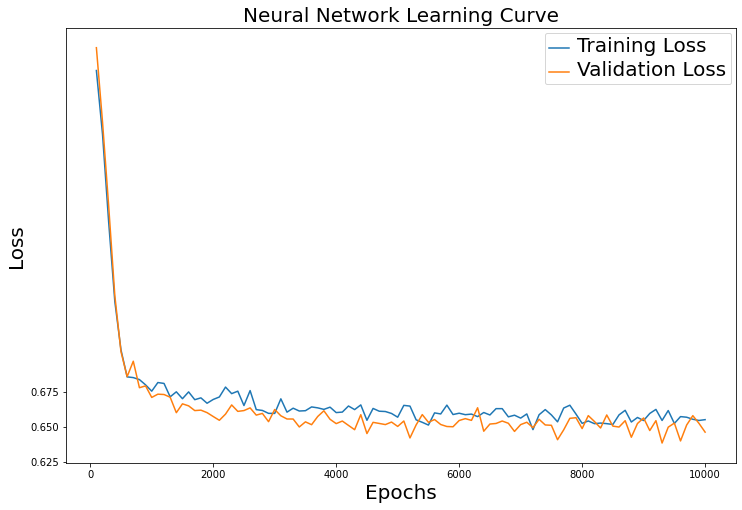

In [10]:
#sets up variables
lv=[]
lt=[]
indx=[]
print(count)

#reduces the data to only 100 entries
for i in range(0,len(losses_val),int(len(losses_val)/100)):
    #print(i)
    lv.append(losses_val[i])
    lt.append(losses_train[i])
    indx.append((i+1)*100)

#plots reduced data
plt.figure(figsize=(12,8))
plt.plot(indx,lt)
plt.plot(indx,lv)
legend = plt.legend(['Training Loss','Validation Loss'])
plt.setp(legend.get_title(),fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.yticks([0.675,0.650,0.625,.600,.575,.550,.525,.500,.475,.450])
plt.title('Neural Network Learning Curve', fontsize=20)
plt.plot()

Data Export:

In [11]:
#creates dataframe
df=pd.DataFrame()

#sets up columns
df['Epoch']=counts
df['Accuracy']=accs
df['TP']=tps 
df['TN']=tns 
df['FP']=fps 
df['FN']=fns
df['TPR']=tprs
df['TNR']=tnrs

#saves to file
df.to_csv('Full_NN_Training_Results_Rev.csv',index=False)

#creates an index list
index=[]
for i in range(4,0,-1):
    try:
        index.append(20-i)
    except:
        pass
    try:
        index.append(40-i)
    except:
        pass
    try:
        index.append(60-i)
    except:
        pass
    try:
        index.append(80-i)
    except:
        pass
    try:
        index.append(100-i)
    except:
        pass

#saves to file with reduced index
df.iloc[index].to_csv('Non_Full_NN_Training_Results_Rev.csv',index=False)

Plot Function:

In [12]:
#defines plot function
def plot_embedding(j, h, color, leg, size=100):
    #sets up variables and figure
    h = h.detach().numpy()
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    
    
    i=0
    if len(leg)==2:
        color = color+2
        i=-2
    scatters=[]
    leg1=[]
    
    #checks to see what colours are used and therefore what colours to use in the labels
    if (color==0).sum()>0:
        scatter0 = ax.scatter(h[color==0][:, 0], h[color==0][:, 1], c='blue', s=size)
        scatters.append(scatter0)
        leg1.append(leg[i])
        
    i+=1
    if (color==1).sum()>0:
        scatter1 = ax.scatter(h[color==1][:, 0], h[color==1][:, 1], c='orange', s=size)
        scatters.append(scatter1)
        leg1.append(leg[i])
        
    i+=1
    if (color==2).sum()>0:
        scatter2 = ax.scatter(h[color==2][:, 0], h[color==2][:, 1], c='green', s=size)
        scatters.append(scatter2)
        leg1.append(leg[i])
        
    i+=1
    if (color==3).sum()>0:
        scatter3 = ax.scatter(h[color==3][:, 0], h[color==3][:, 1], c='red', s=size)
        scatters.append(scatter3)
        leg1.append(leg[i])
        
    legend = ax.legend(scatters,leg1, title="Classifications:", prop={'size': 16}, loc = 'upper right')
    plt.setp(legend.get_title(),fontsize=20)
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
    
    #sets plot limits and ticks
    plt.xlim((-1.1,1.1))
    plt.ylim((-1.1,1.1))
    plt.xticks([-1,0,1],[0.0,0.5,1.0], fontsize=20)
    plt.yticks([-1,0,1],[0.0,0.5,1.0], fontsize=20)
    
    #sets axes labels
    plt.xlabel('First Embedding Output', fontsize=20)
    plt.ylabel('Second Embedding Output', fontsize=20)
    
    #sets font size
    if type(j)==str:
        plt.title(f"{j}", fontsize=24)
    else:
        plt.title(f"Epoch: {counts[j]}", fontsize=24)
    plt.show()

Validation Classification Plots:

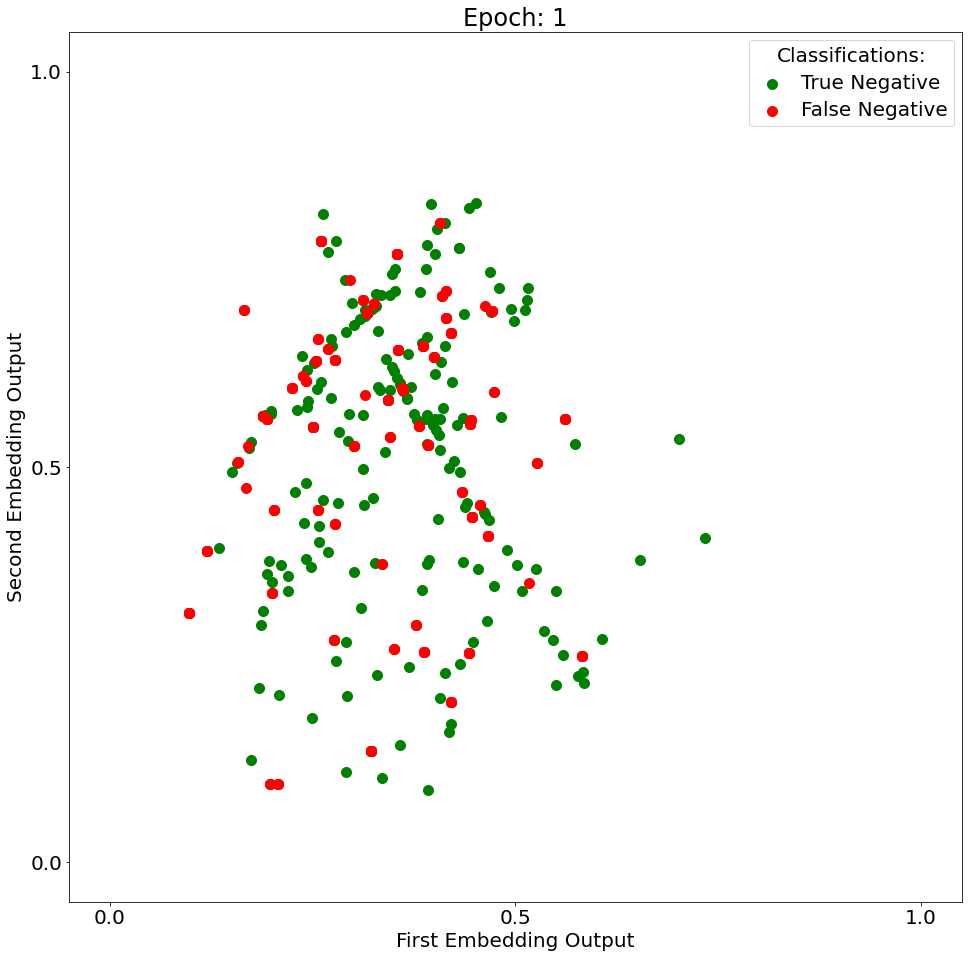

Epoch: 1  Accuracy: 0.400407  FP: 0  TP: 0  TPR: 0.000000  TNR: 1.000000


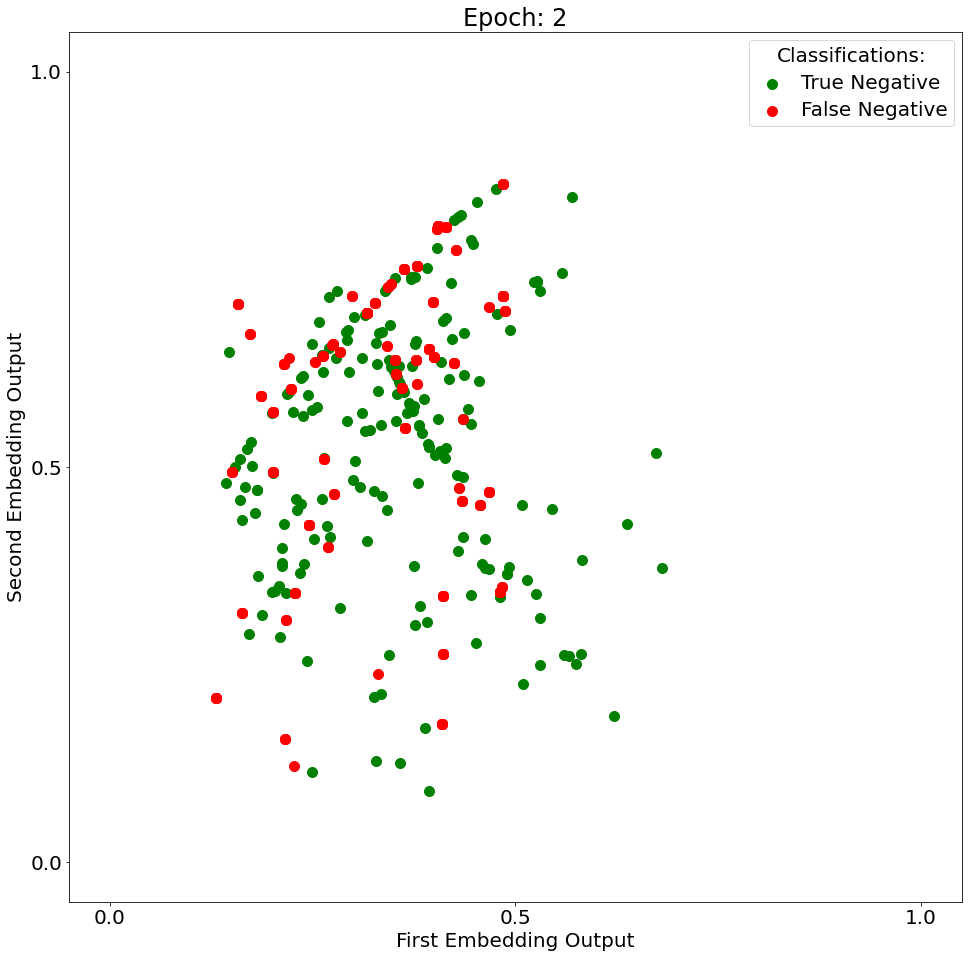

Epoch: 2  Accuracy: 0.420842  FP: 0  TP: 0  TPR: 0.000000  TNR: 1.000000


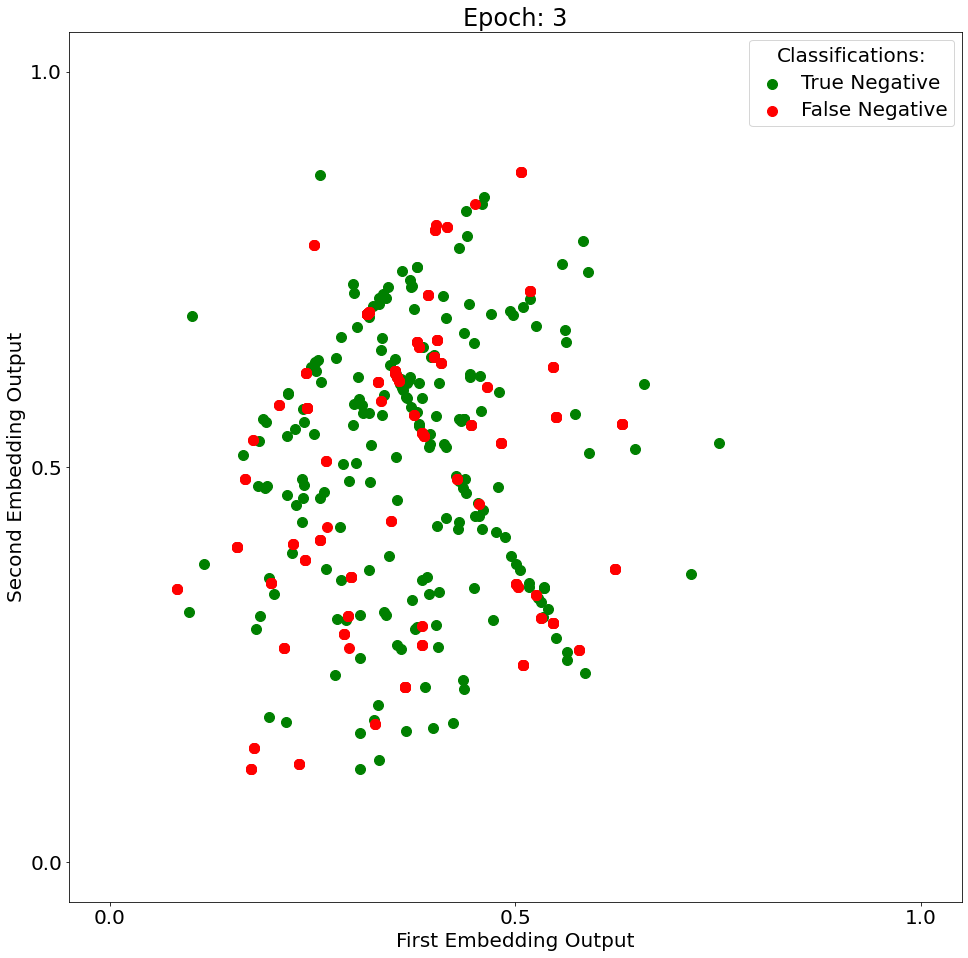

Epoch: 3  Accuracy: 0.431034  FP: 0  TP: 0  TPR: 0.000000  TNR: 1.000000


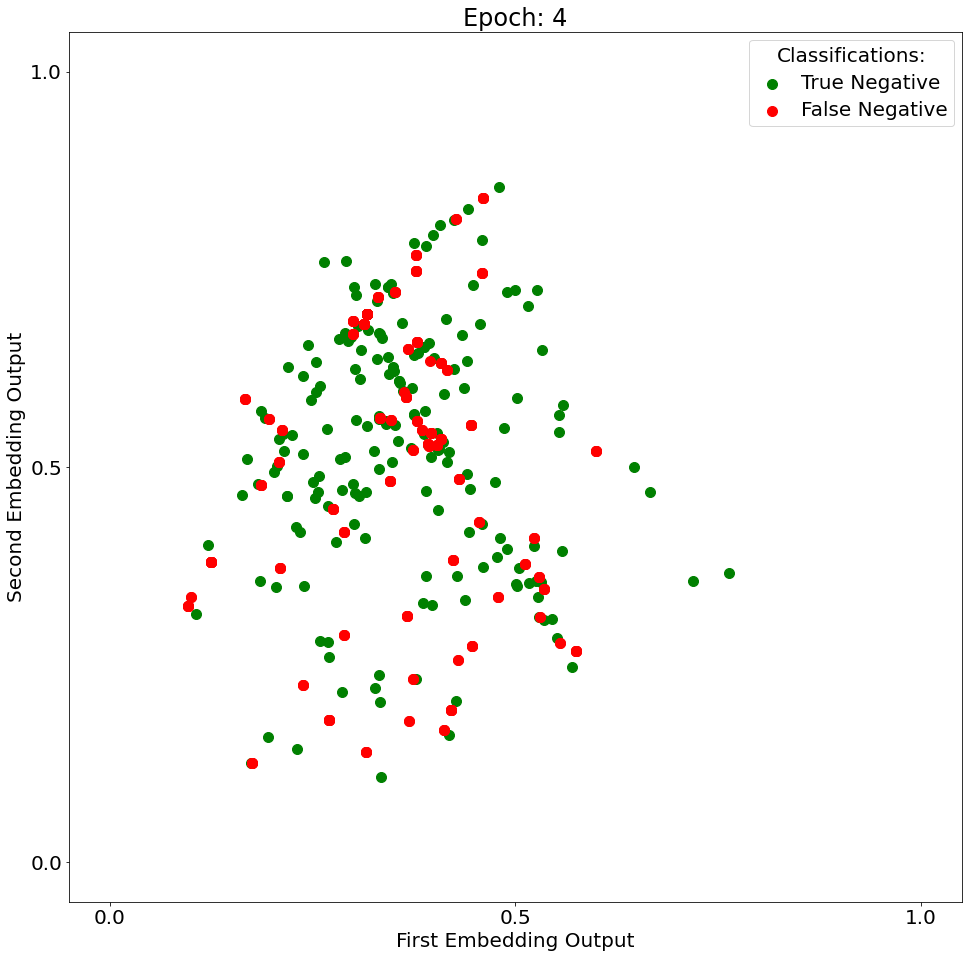

Epoch: 4  Accuracy: 0.406504  FP: 0  TP: 0  TPR: 0.000000  TNR: 1.000000


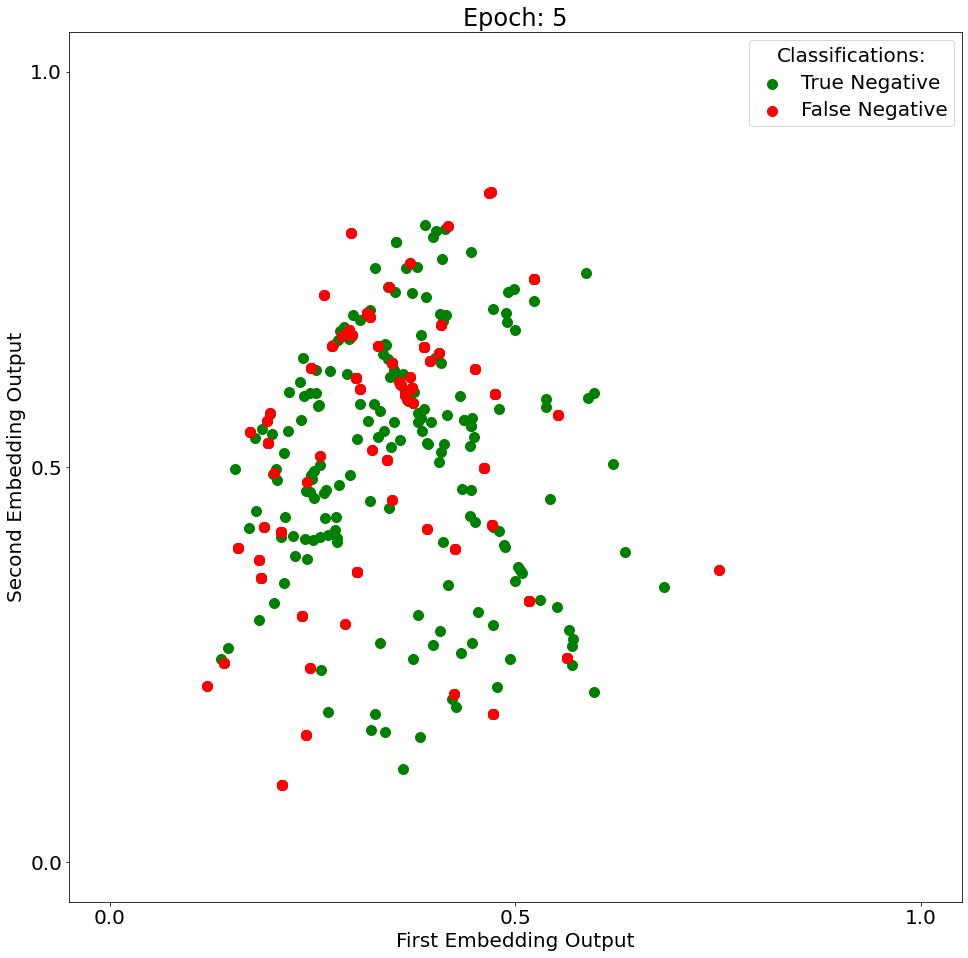

Epoch: 5  Accuracy: 0.428858  FP: 0  TP: 0  TPR: 0.000000  TNR: 1.000000


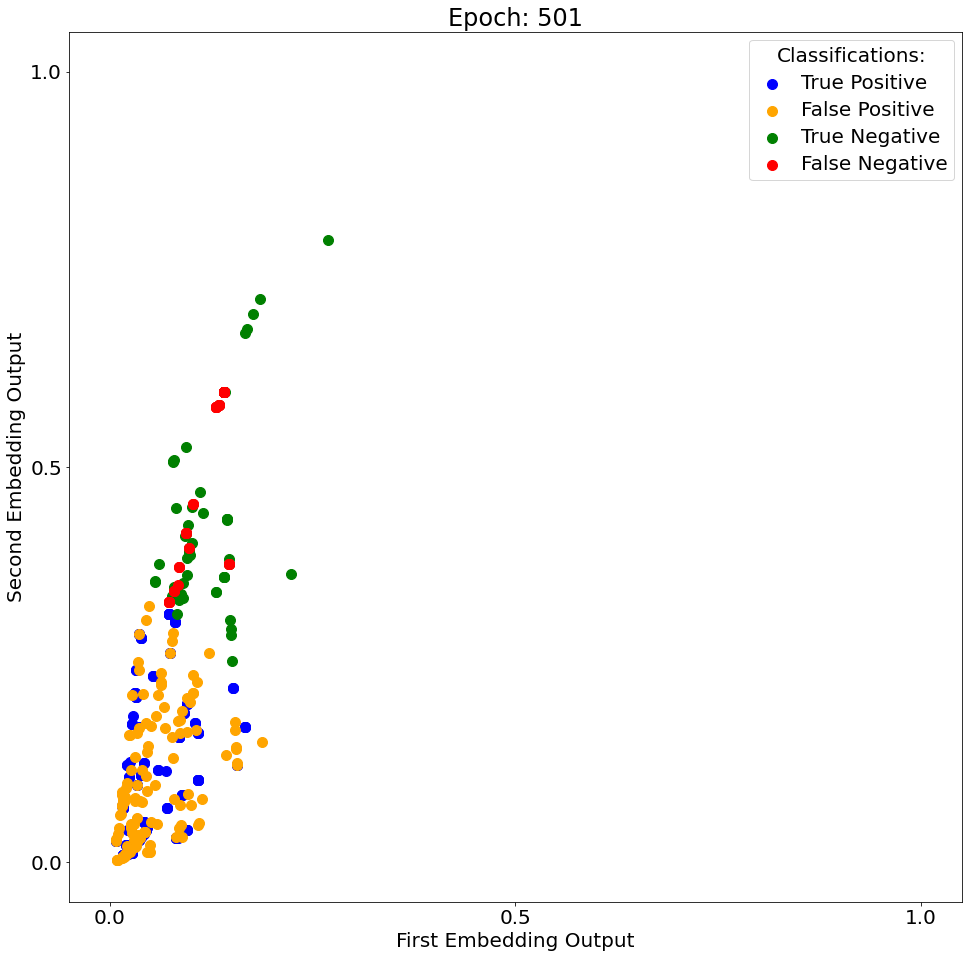

Epoch: 501  Accuracy: 0.605691  FP: 130  TP: 231  TPR: 0.783051  TNR: 0.340102


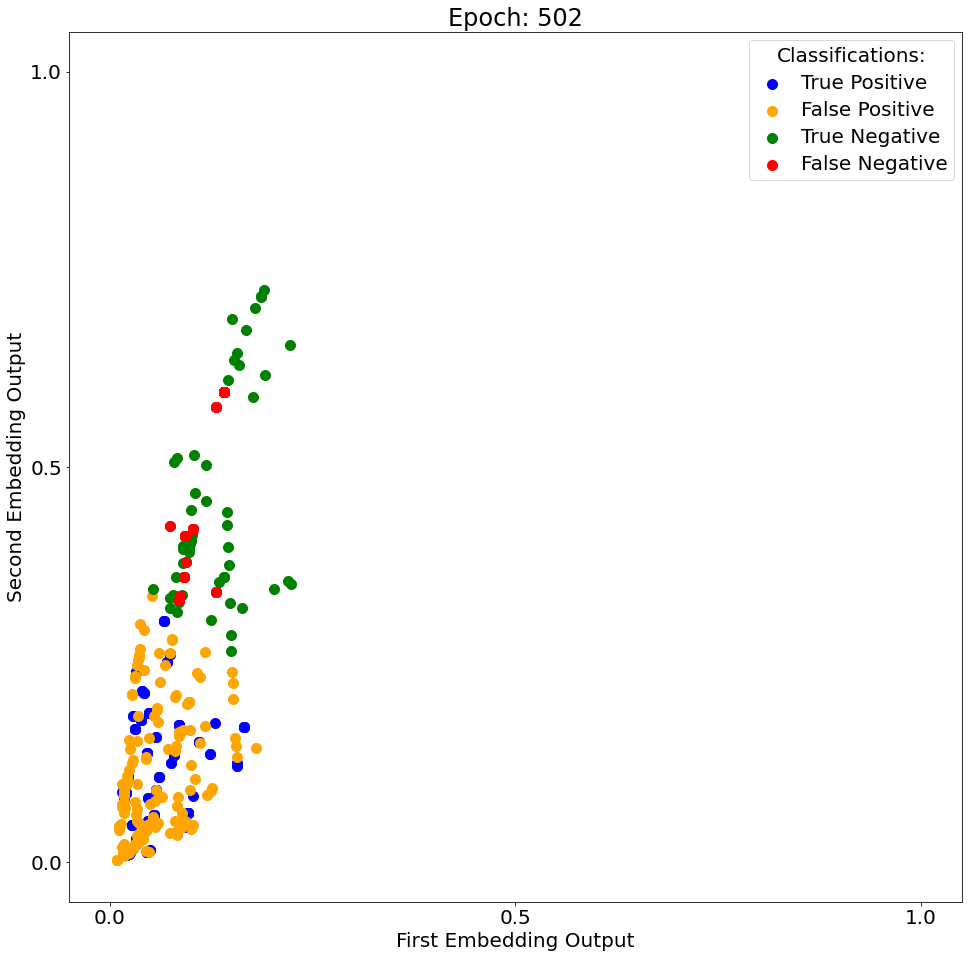

Epoch: 502  Accuracy: 0.581162  FP: 139  TP: 219  TPR: 0.757785  TNR: 0.338095


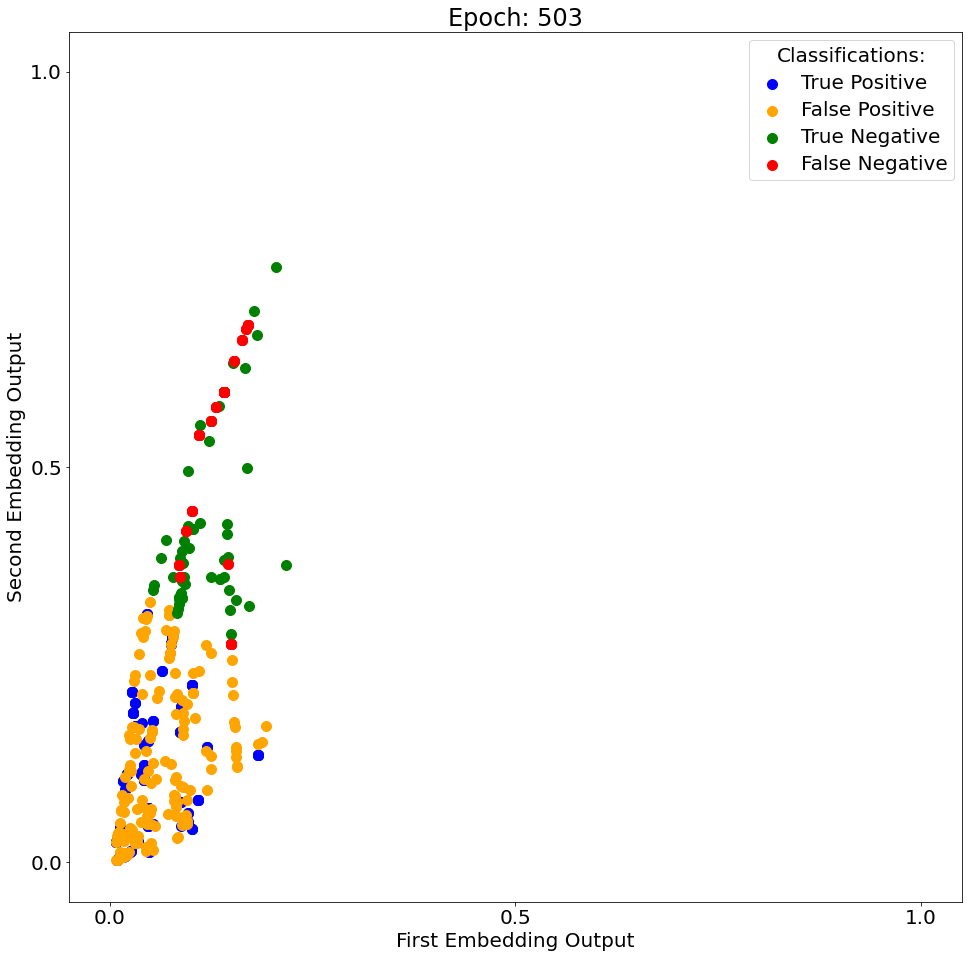

Epoch: 503  Accuracy: 0.524904  FP: 162  TP: 211  TPR: 0.710438  TNR: 0.280000


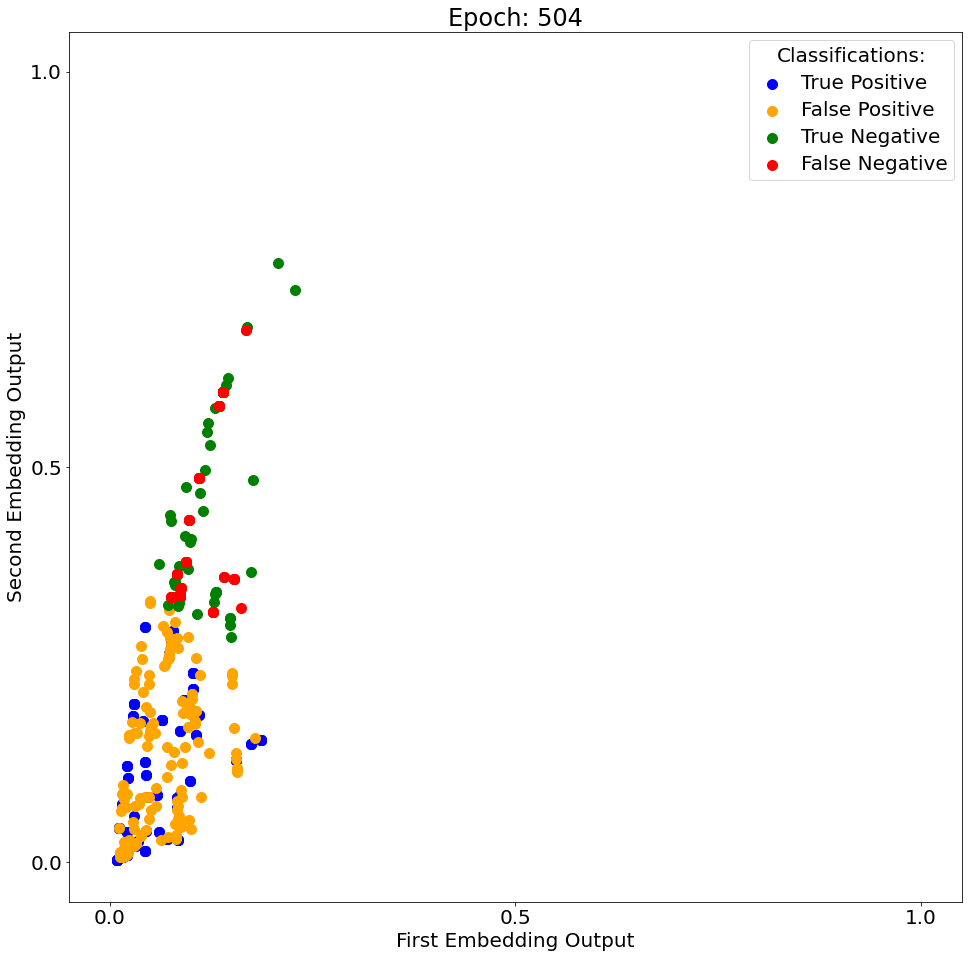

Epoch: 504  Accuracy: 0.552846  FP: 141  TP: 213  TPR: 0.729452  TNR: 0.295000


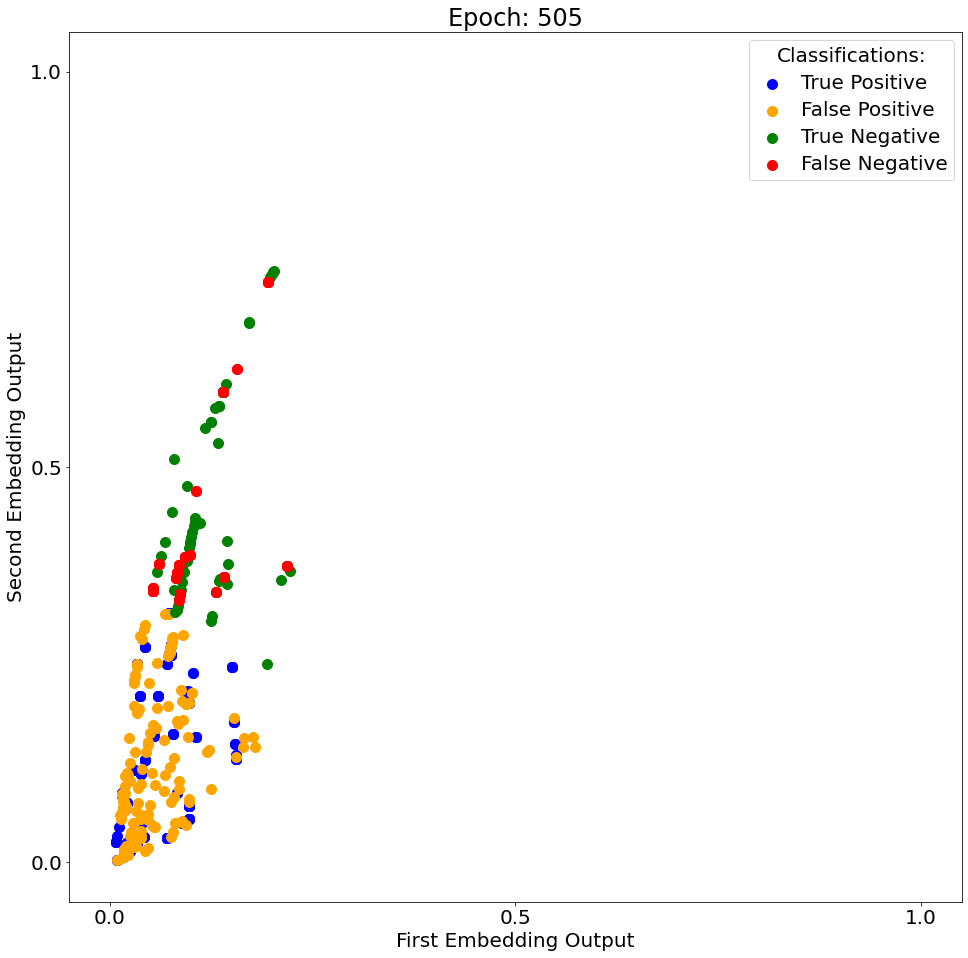

Epoch: 505  Accuracy: 0.539078  FP: 147  TP: 202  TPR: 0.708772  TNR: 0.313084


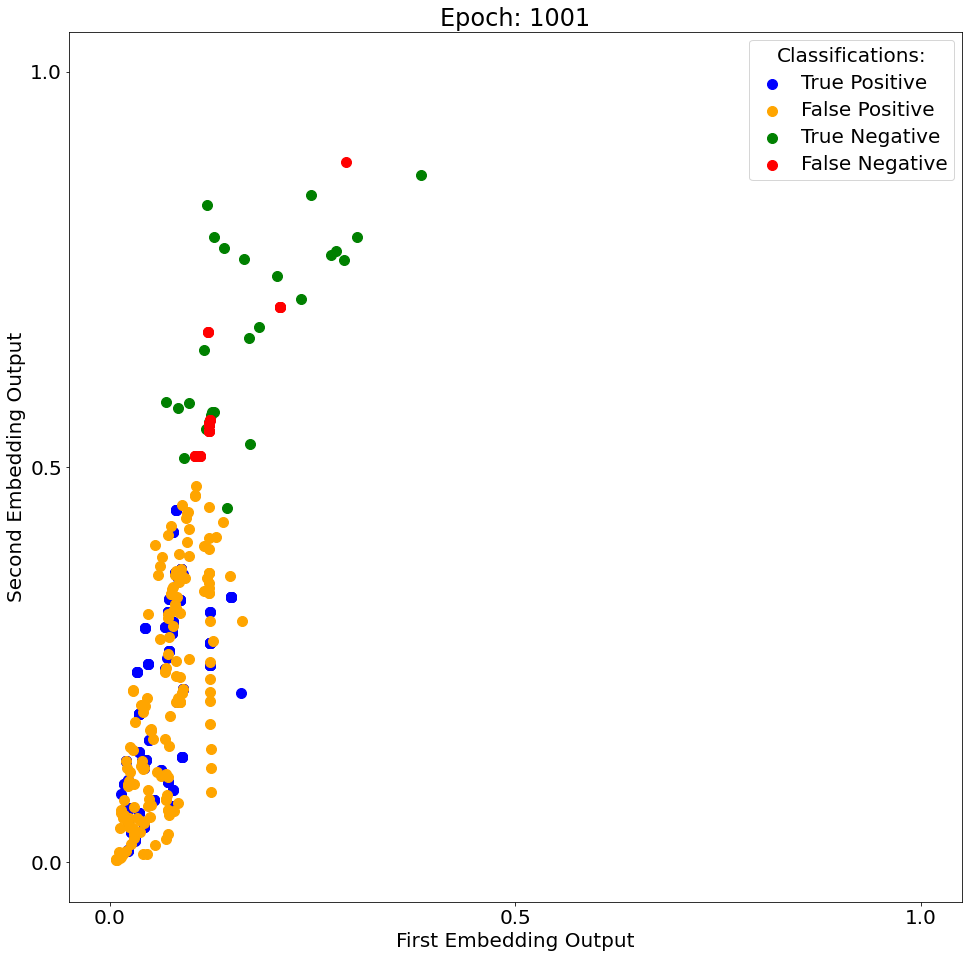

Epoch: 1001  Accuracy: 0.571138  FP: 161  TP: 245  TPR: 0.830508  TNR: 0.182741


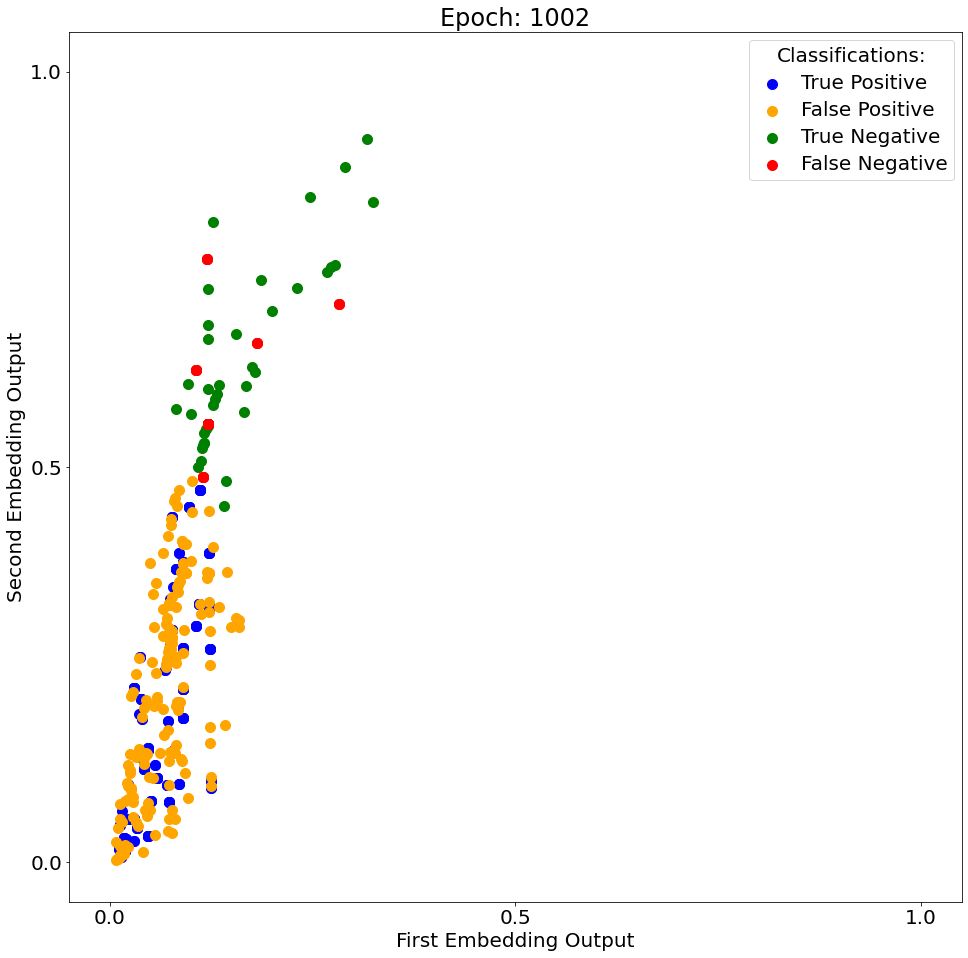

Epoch: 1002  Accuracy: 0.573146  FP: 164  TP: 240  TPR: 0.830450  TNR: 0.219048


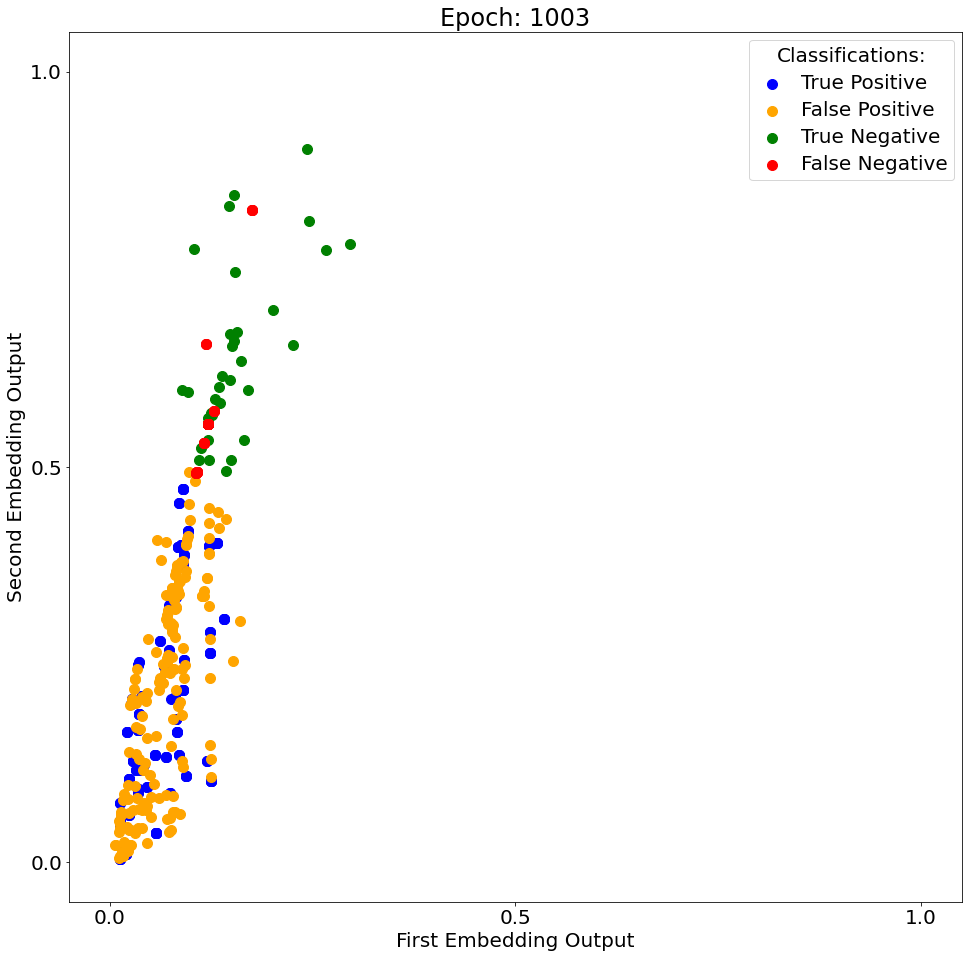

Epoch: 1003  Accuracy: 0.574713  FP: 175  TP: 250  TPR: 0.841751  TNR: 0.222222


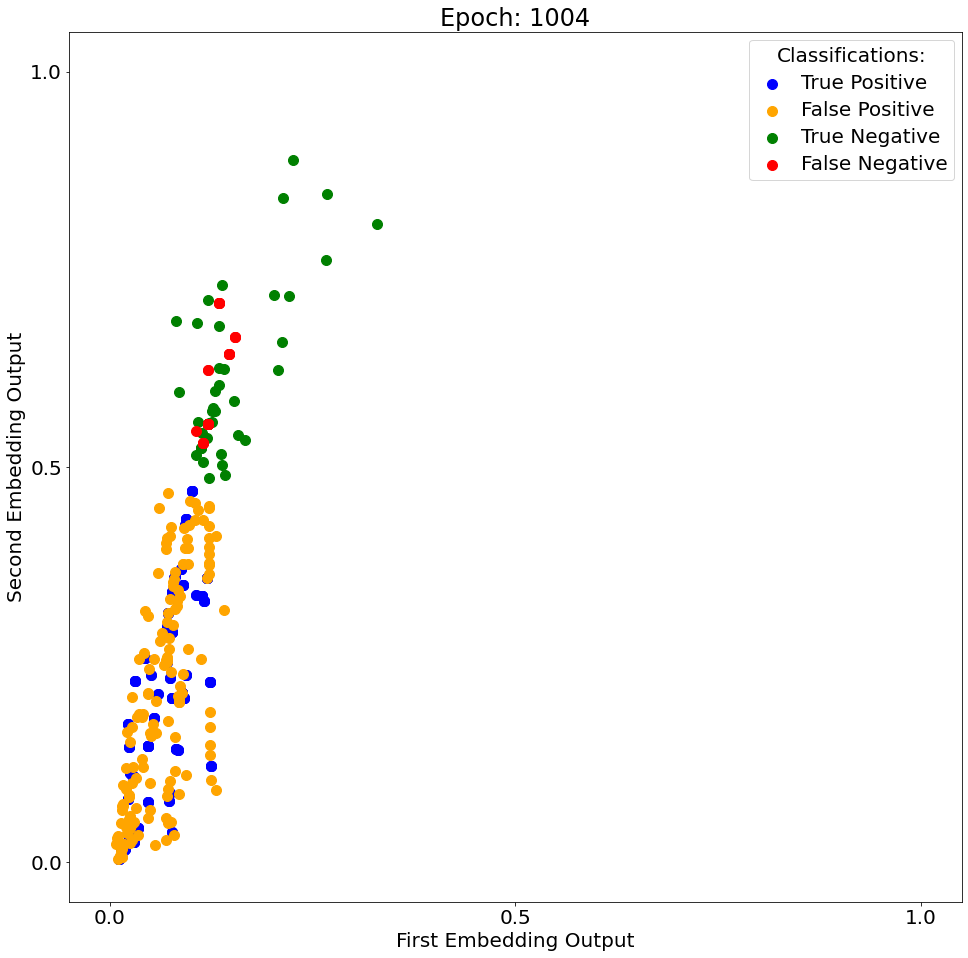

Epoch: 1004  Accuracy: 0.636179  FP: 150  TP: 263  TPR: 0.900685  TNR: 0.250000


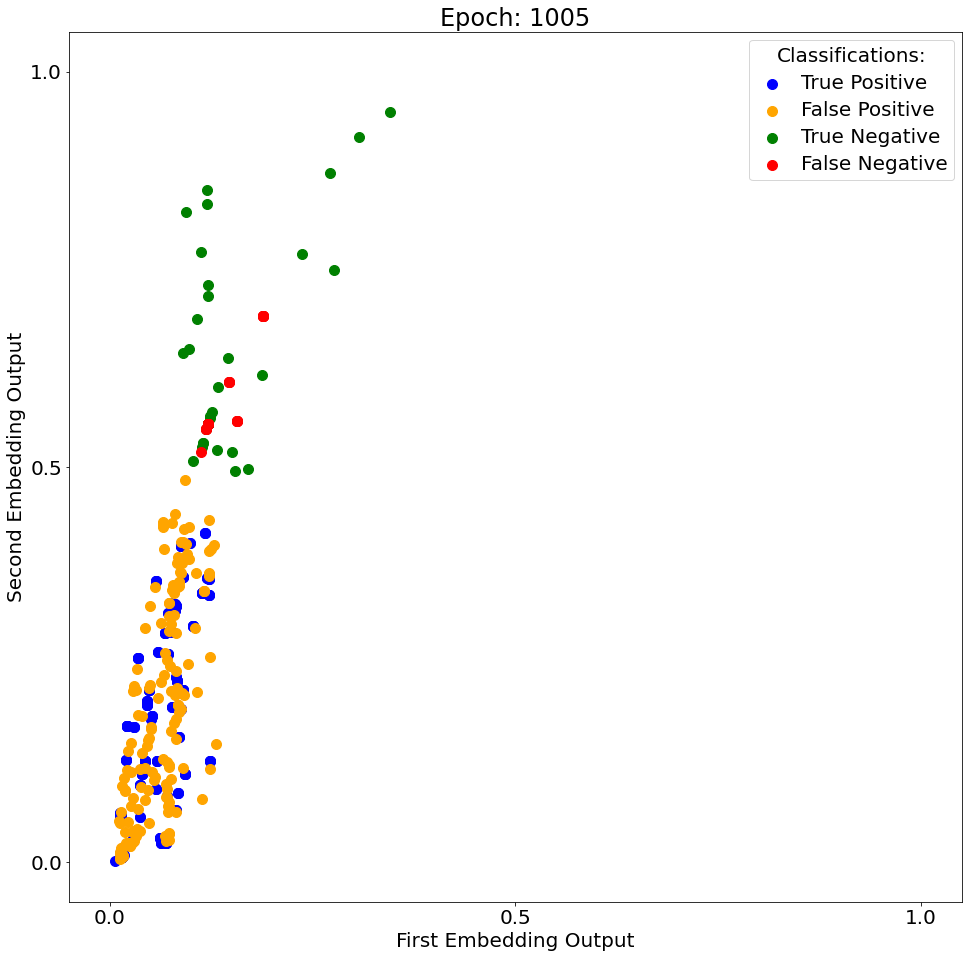

Epoch: 1005  Accuracy: 0.603206  FP: 167  TP: 254  TPR: 0.891228  TNR: 0.219626


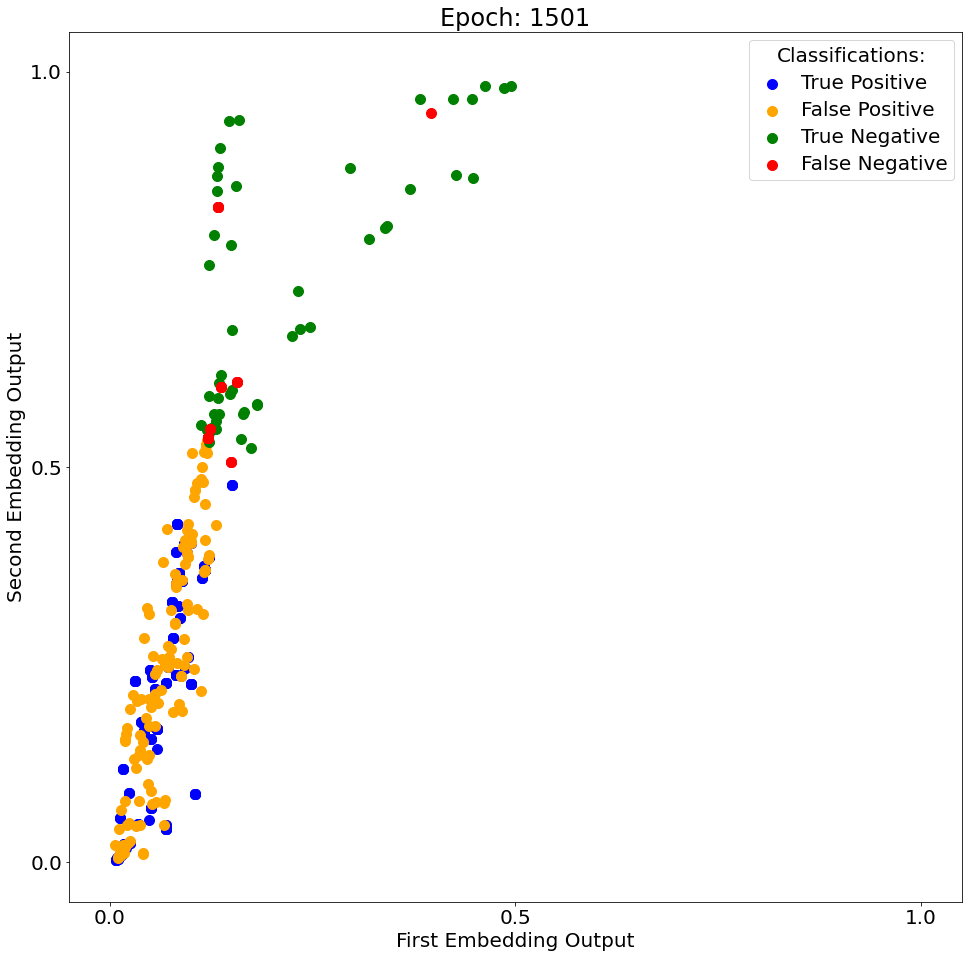

Epoch: 1501  Accuracy: 0.656504  FP: 130  TP: 256  TPR: 0.867797  TNR: 0.340102


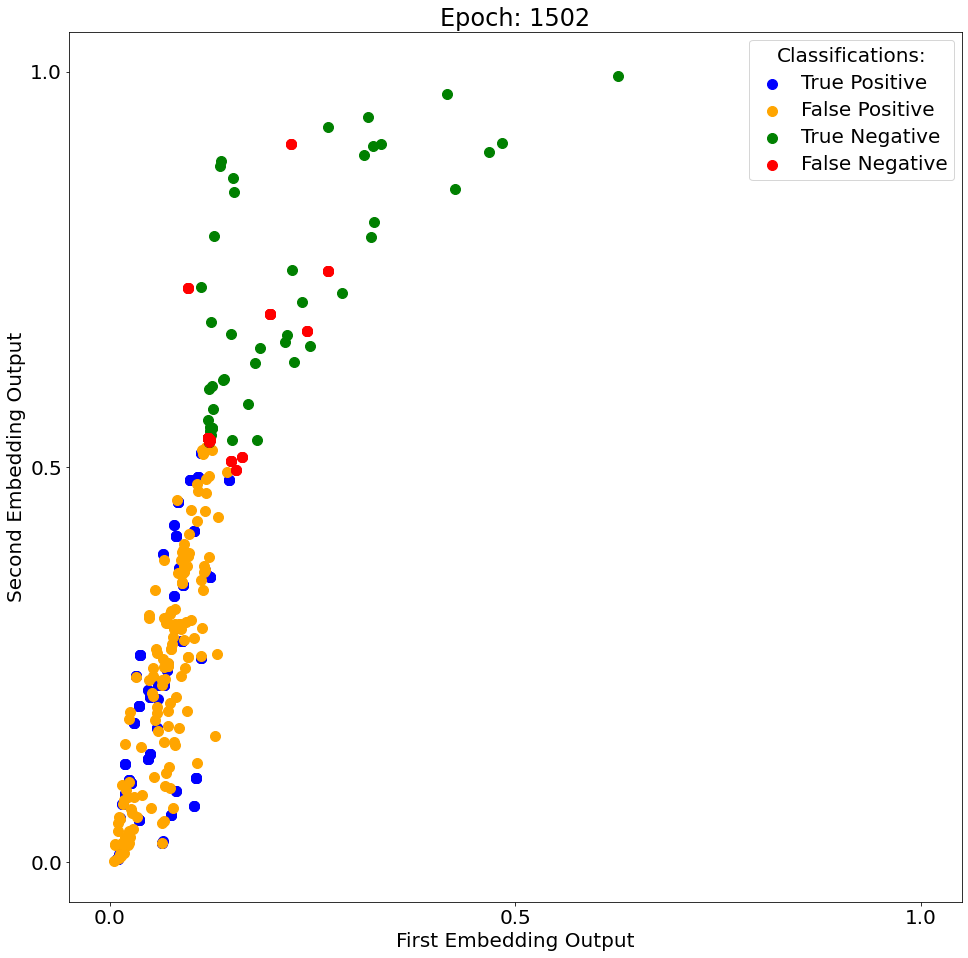

Epoch: 1502  Accuracy: 0.581162  FP: 153  TP: 233  TPR: 0.806228  TNR: 0.271429


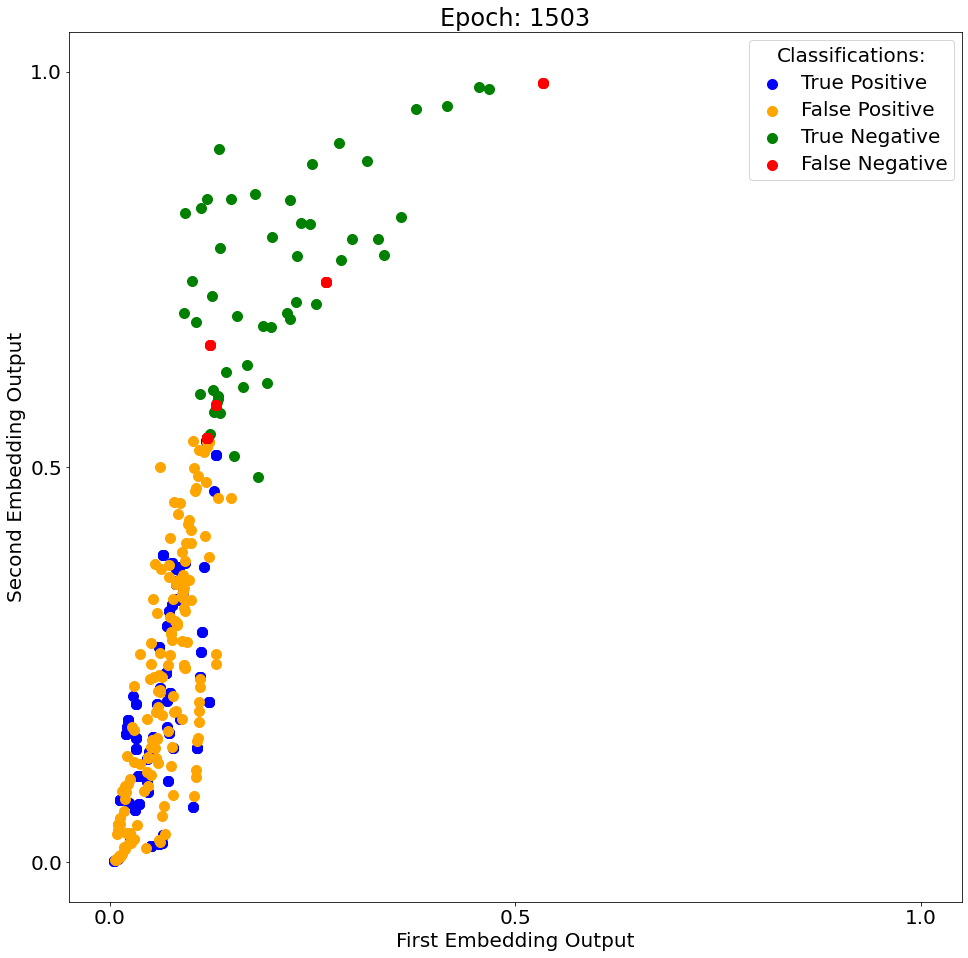

Epoch: 1503  Accuracy: 0.620690  FP: 160  TP: 259  TPR: 0.872054  TNR: 0.288889


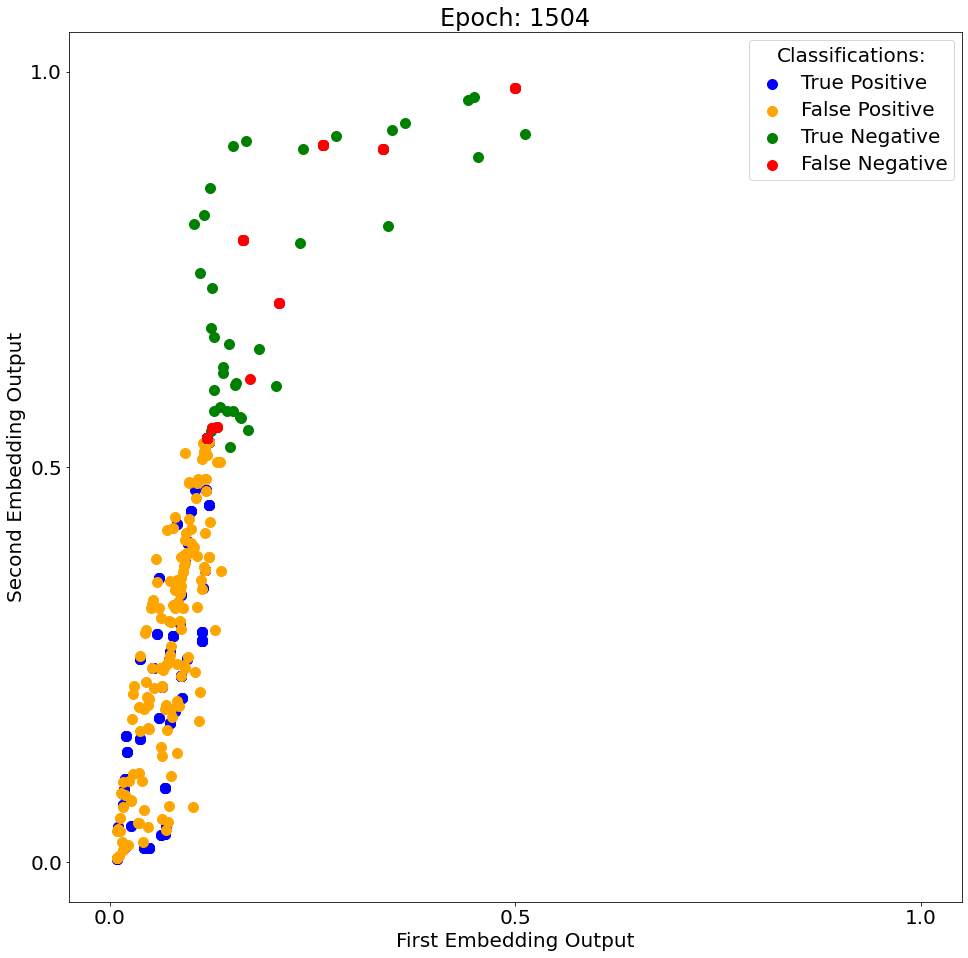

Epoch: 1504  Accuracy: 0.563008  FP: 152  TP: 229  TPR: 0.784247  TNR: 0.240000


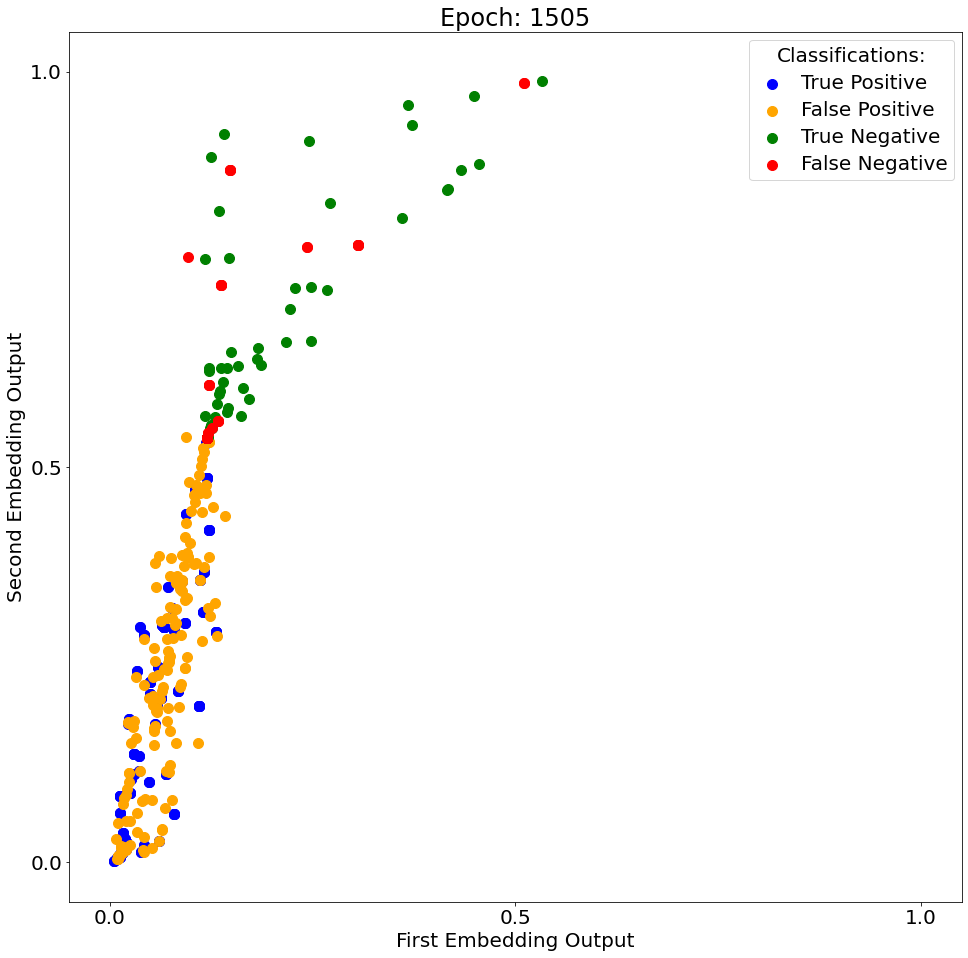

Epoch: 1505  Accuracy: 0.605210  FP: 154  TP: 242  TPR: 0.849123  TNR: 0.280374


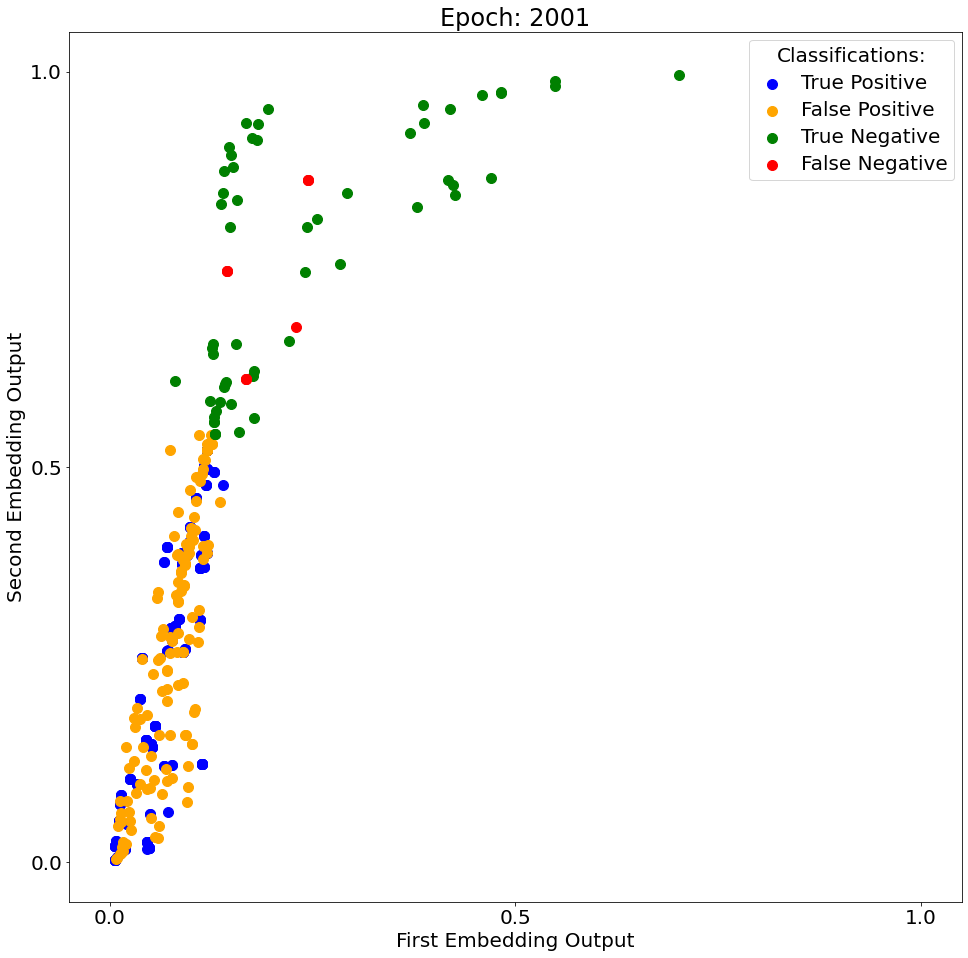

Epoch: 2001  Accuracy: 0.693089  FP: 141  TP: 285  TPR: 0.966102  TNR: 0.284264


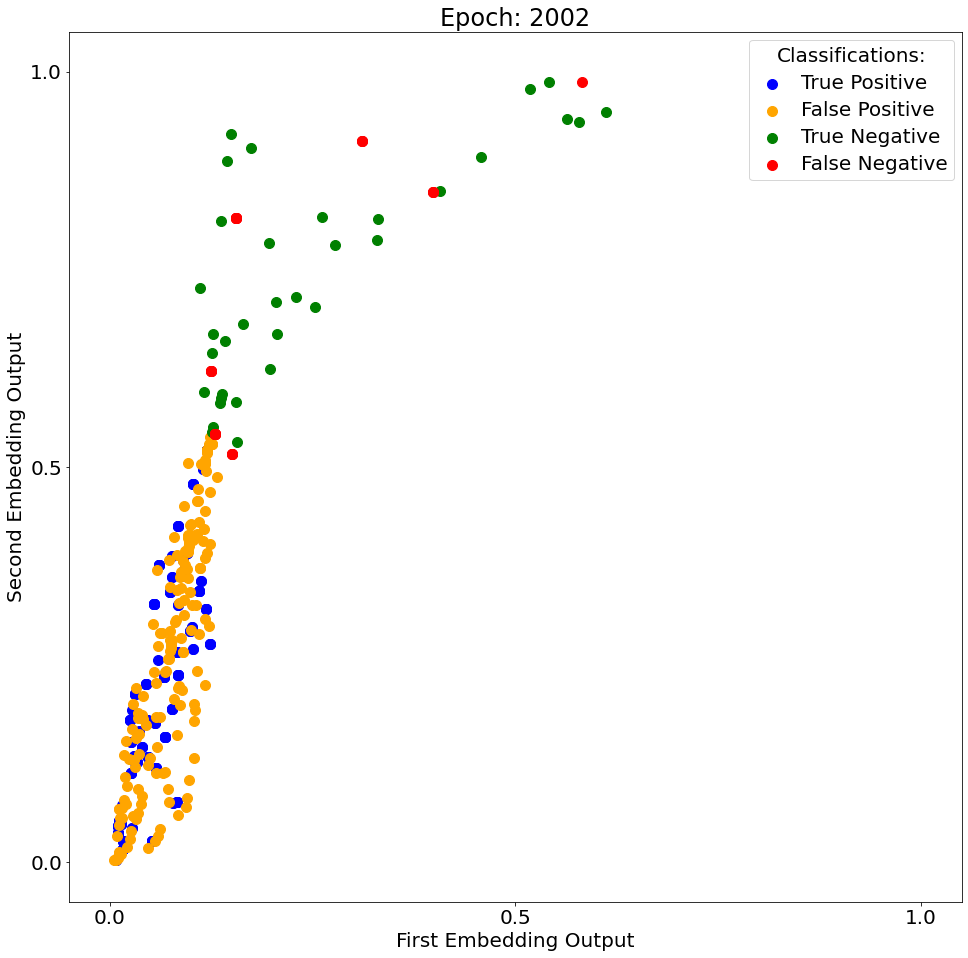

Epoch: 2002  Accuracy: 0.585170  FP: 176  TP: 258  TPR: 0.892734  TNR: 0.161905


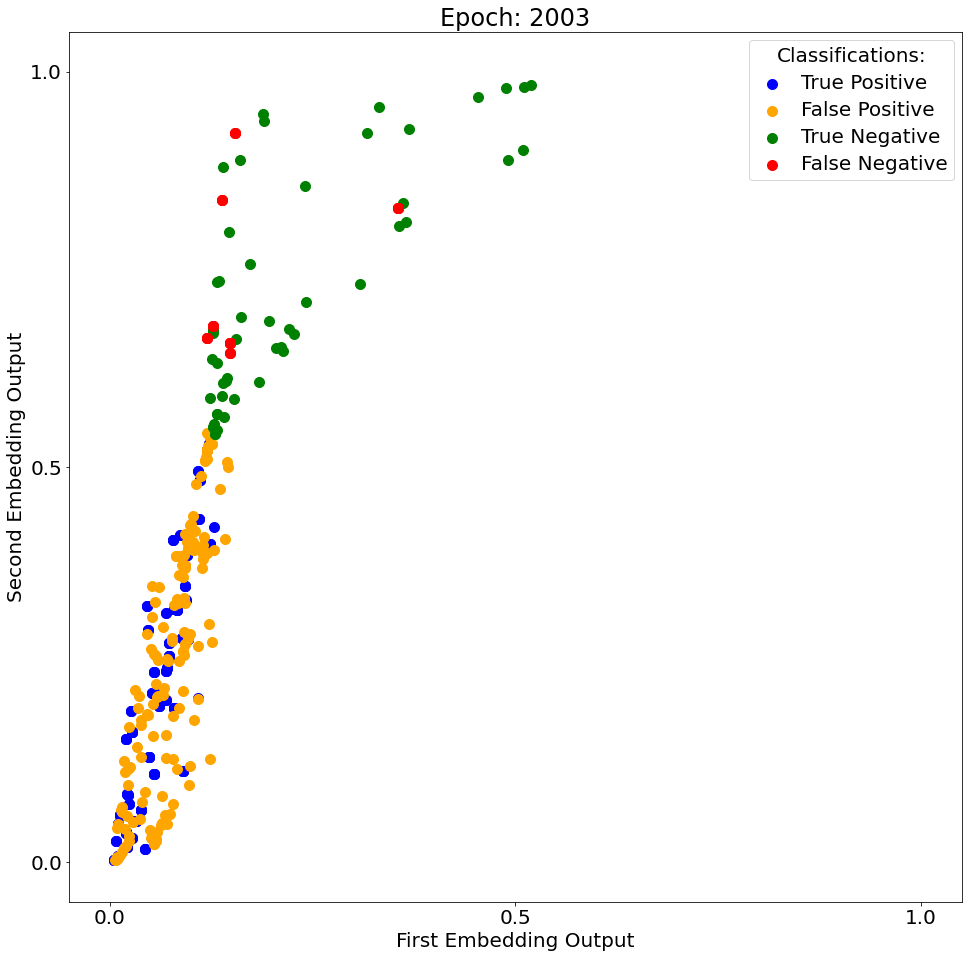

Epoch: 2003  Accuracy: 0.613027  FP: 174  TP: 269  TPR: 0.905724  TNR: 0.226667


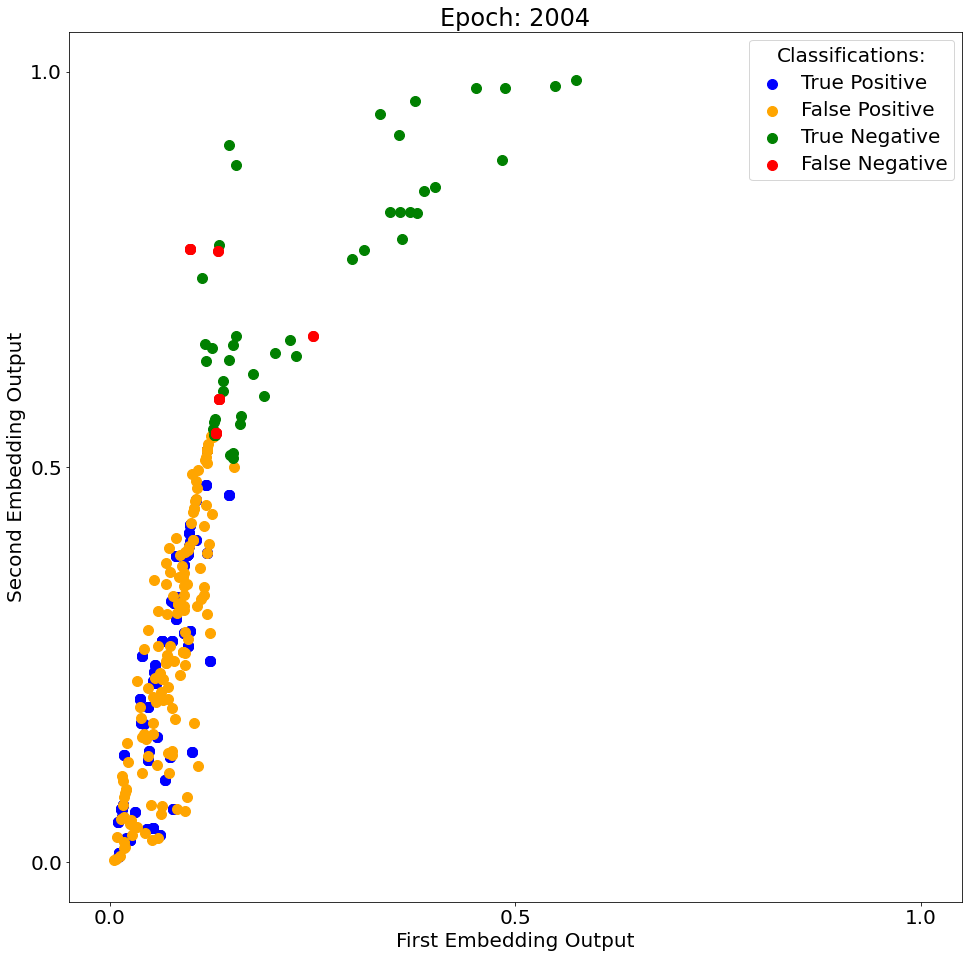

Epoch: 2004  Accuracy: 0.640244  FP: 154  TP: 269  TPR: 0.921233  TNR: 0.230000


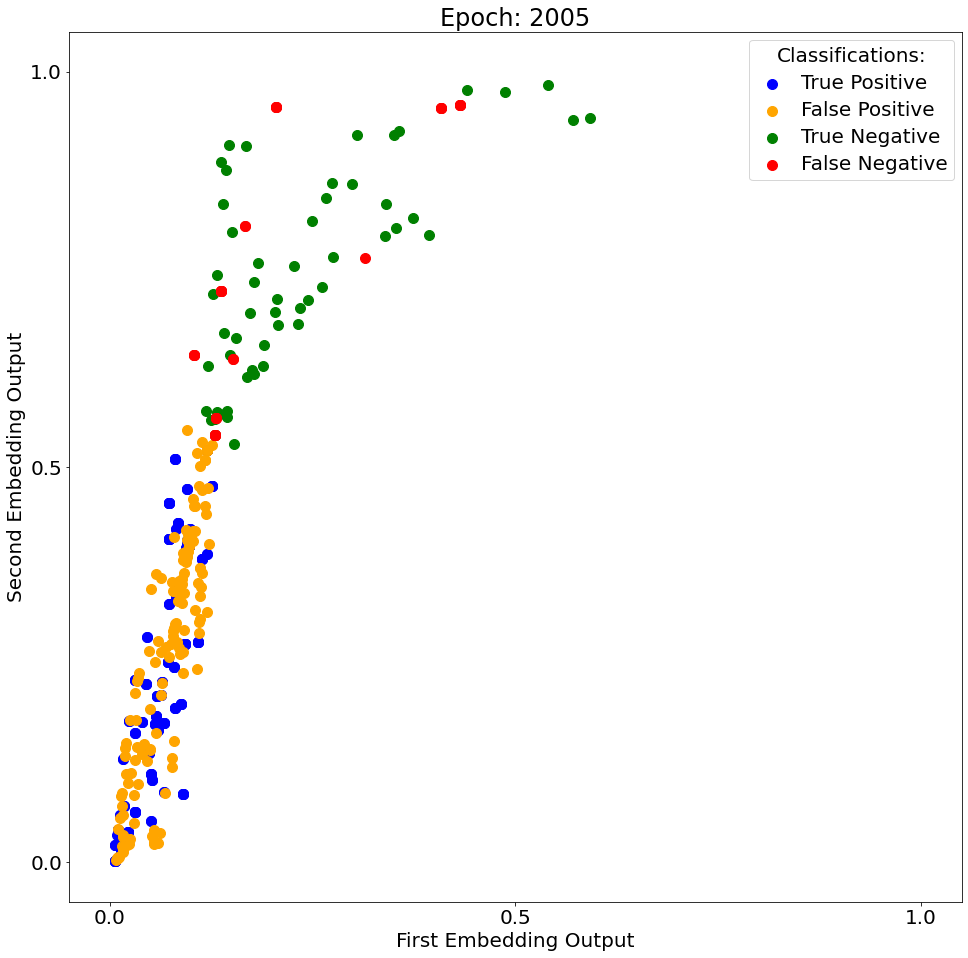

Epoch: 2005  Accuracy: 0.601202  FP: 158  TP: 244  TPR: 0.856140  TNR: 0.261682


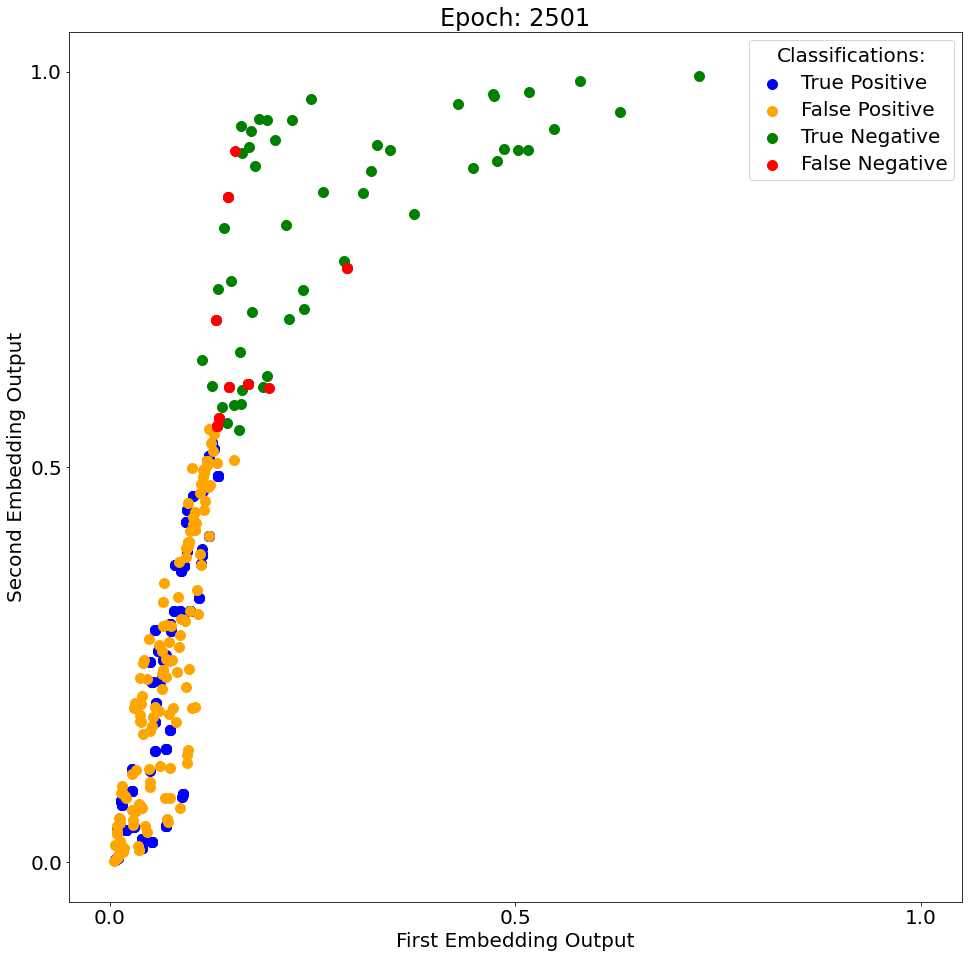

Epoch: 2501  Accuracy: 0.642276  FP: 148  TP: 267  TPR: 0.905085  TNR: 0.248731


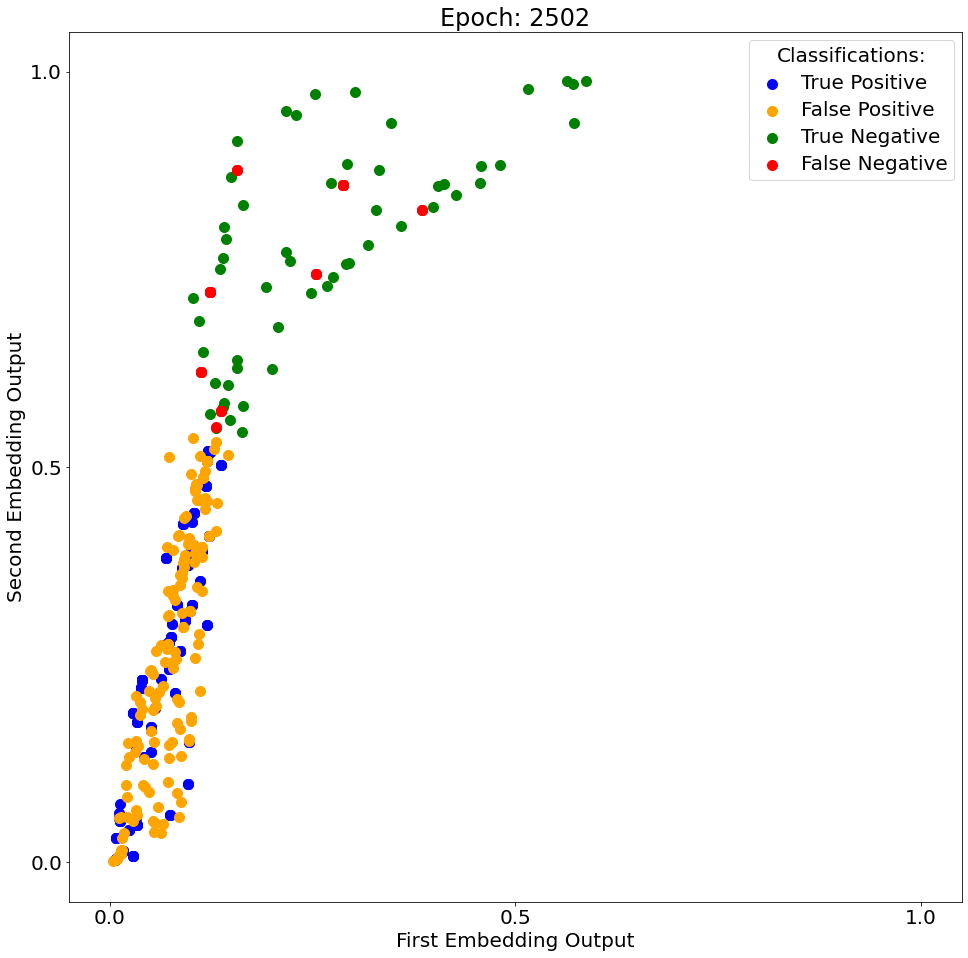

Epoch: 2502  Accuracy: 0.613226  FP: 156  TP: 252  TPR: 0.871972  TNR: 0.257143


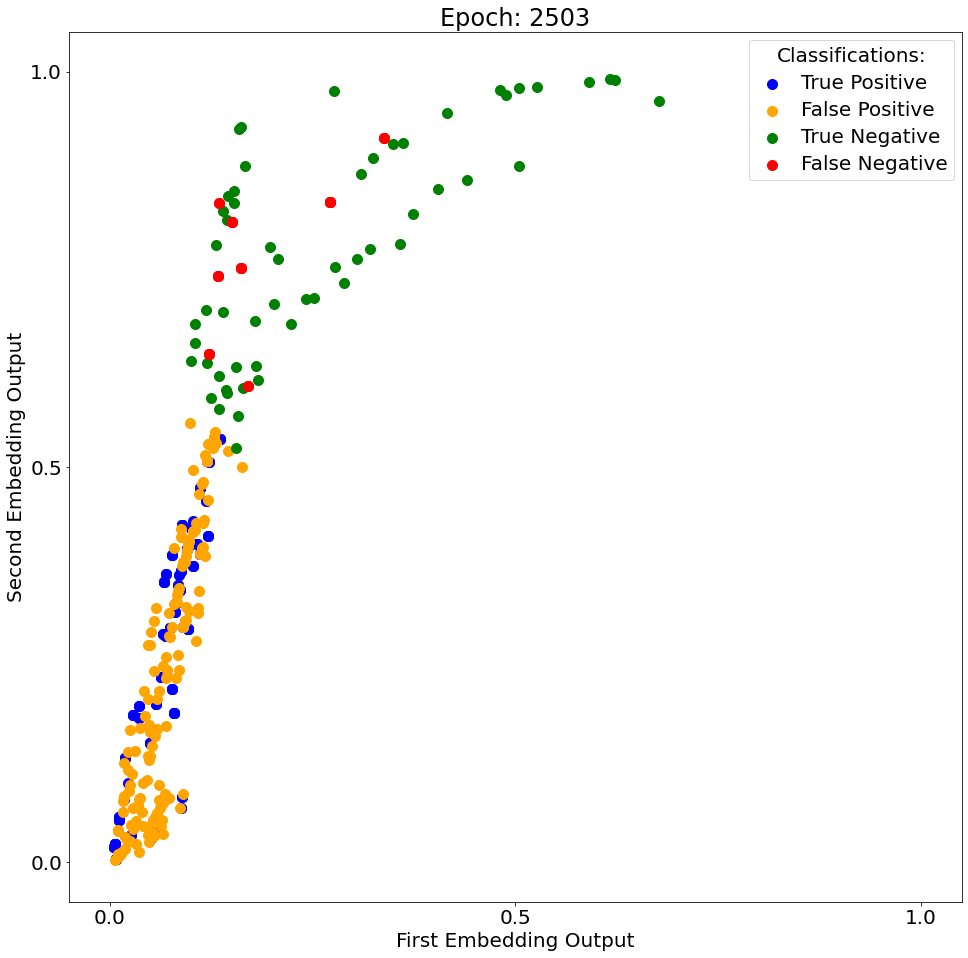

Epoch: 2503  Accuracy: 0.618774  FP: 169  TP: 267  TPR: 0.898990  TNR: 0.248889


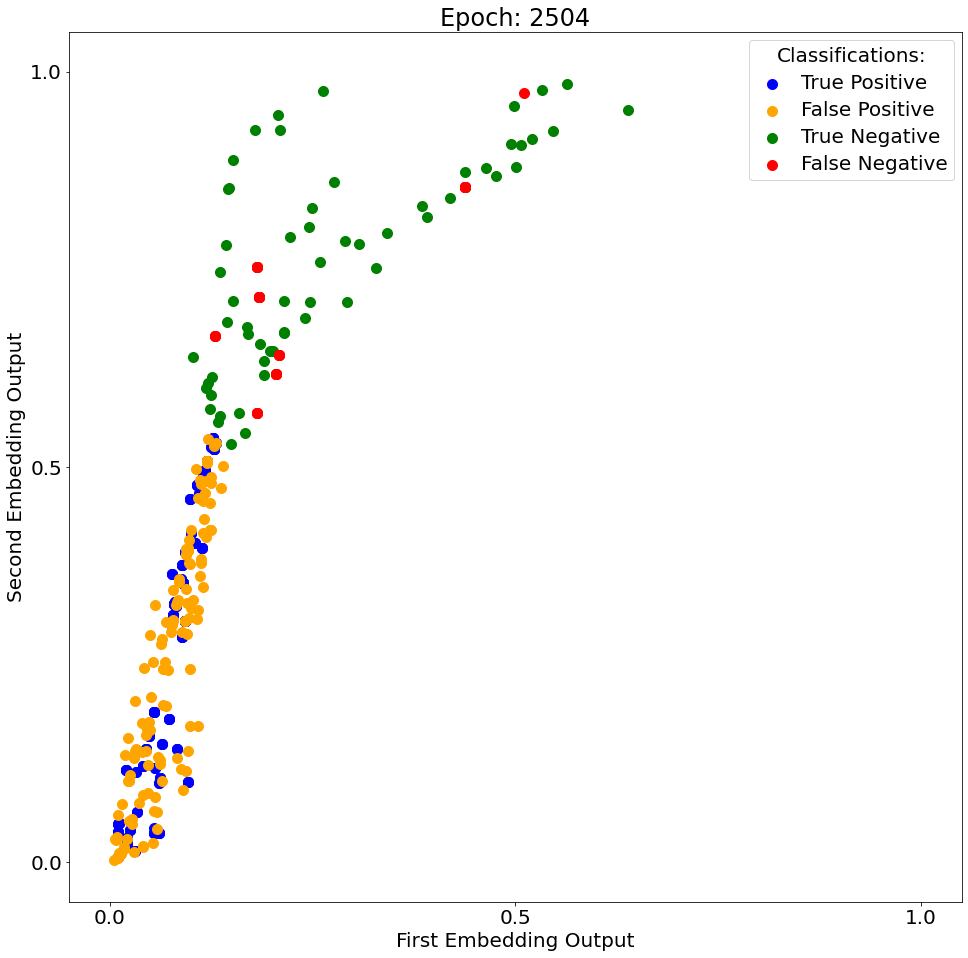

Epoch: 2504  Accuracy: 0.638211  FP: 141  TP: 255  TPR: 0.873288  TNR: 0.295000


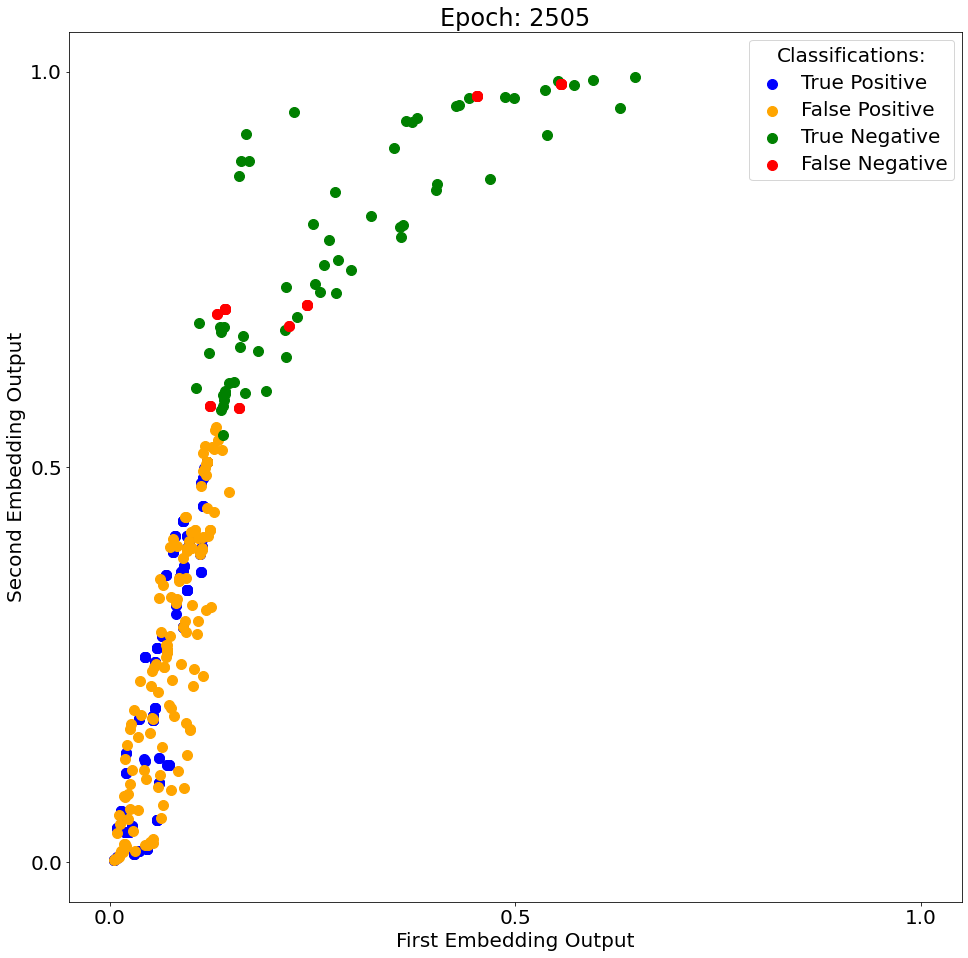

Epoch: 2505  Accuracy: 0.625251  FP: 153  TP: 251  TPR: 0.880702  TNR: 0.285047


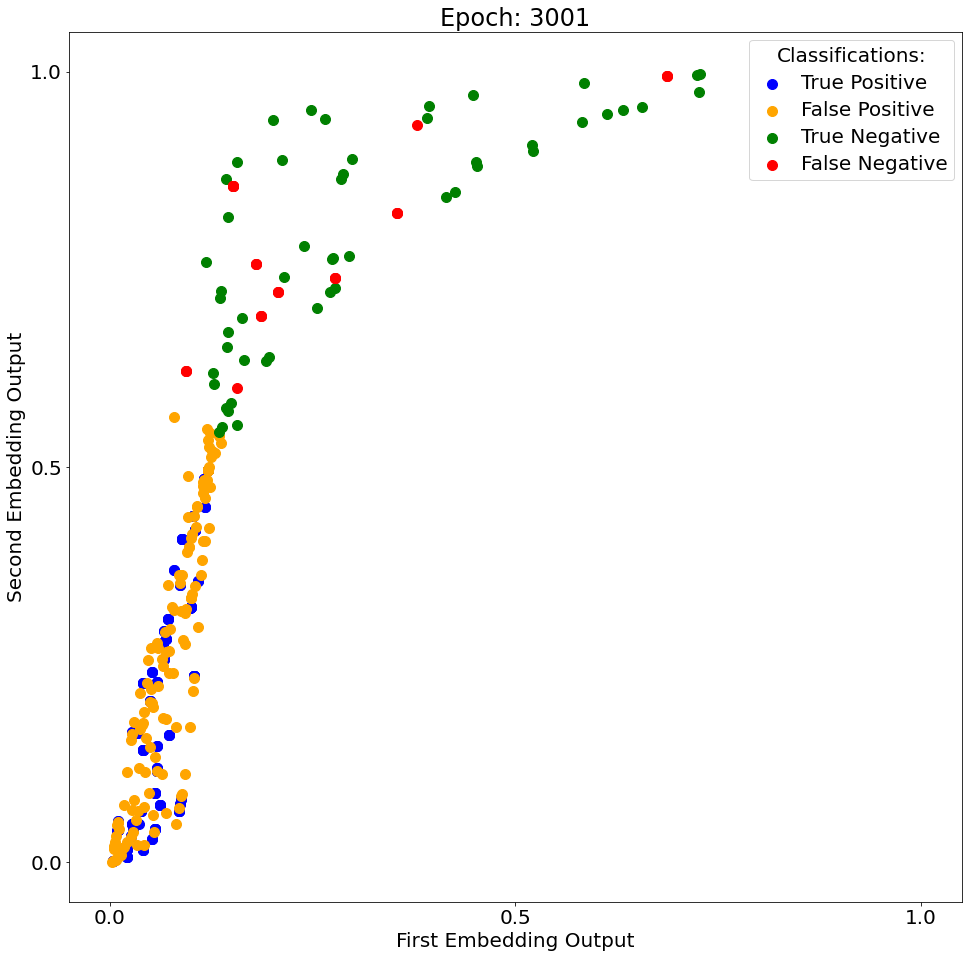

Epoch: 3001  Accuracy: 0.648374  FP: 145  TP: 267  TPR: 0.905085  TNR: 0.263959


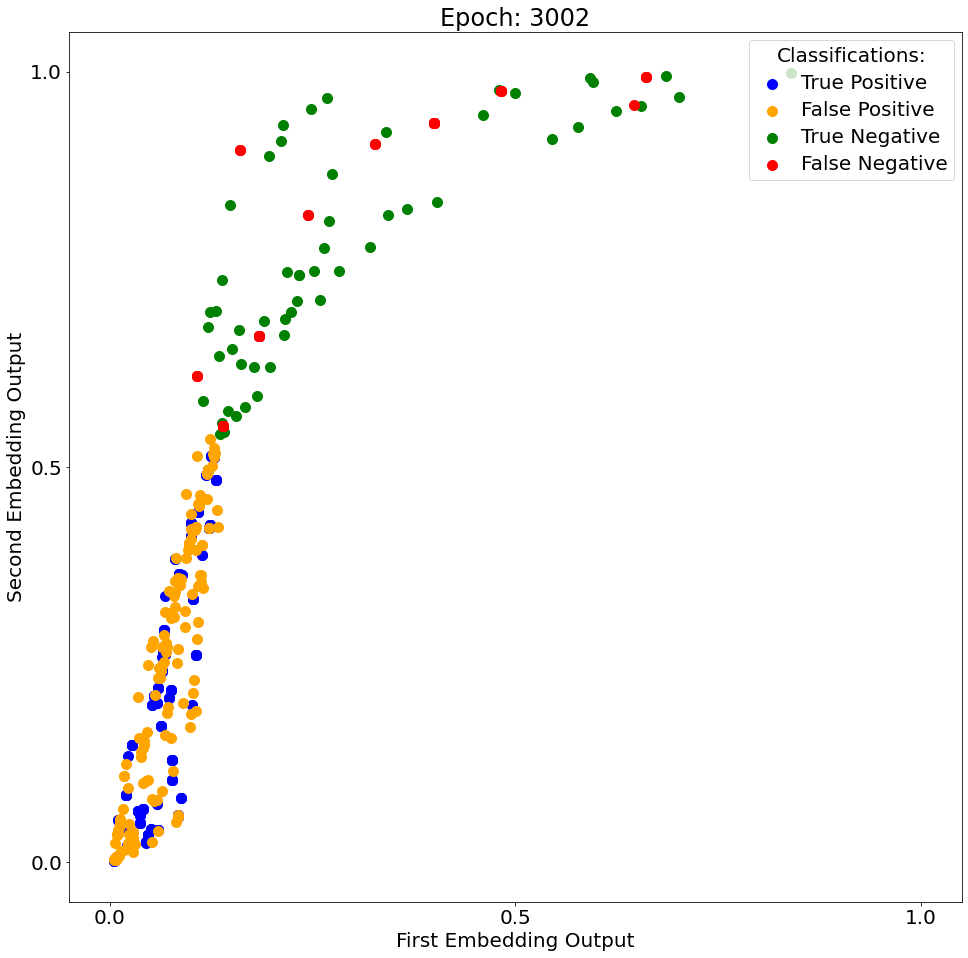

Epoch: 3002  Accuracy: 0.593186  FP: 155  TP: 241  TPR: 0.833910  TNR: 0.261905


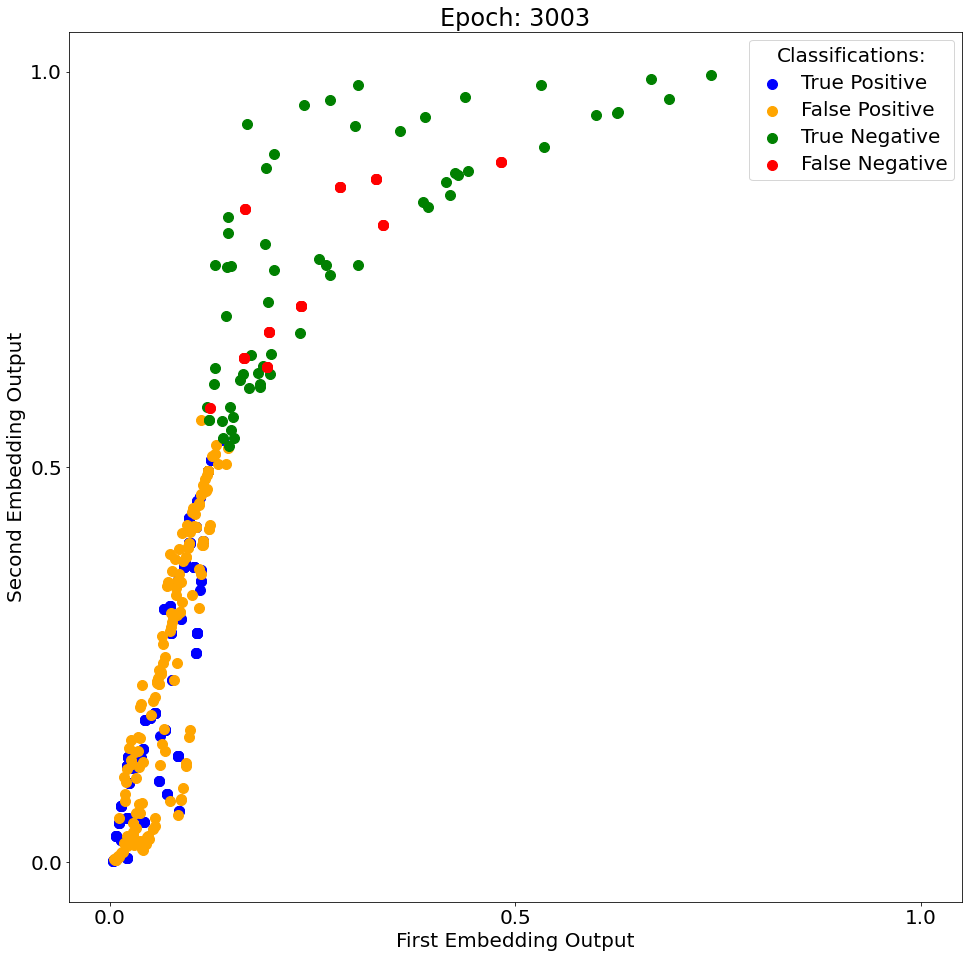

Epoch: 3003  Accuracy: 0.613027  FP: 164  TP: 259  TPR: 0.872054  TNR: 0.271111


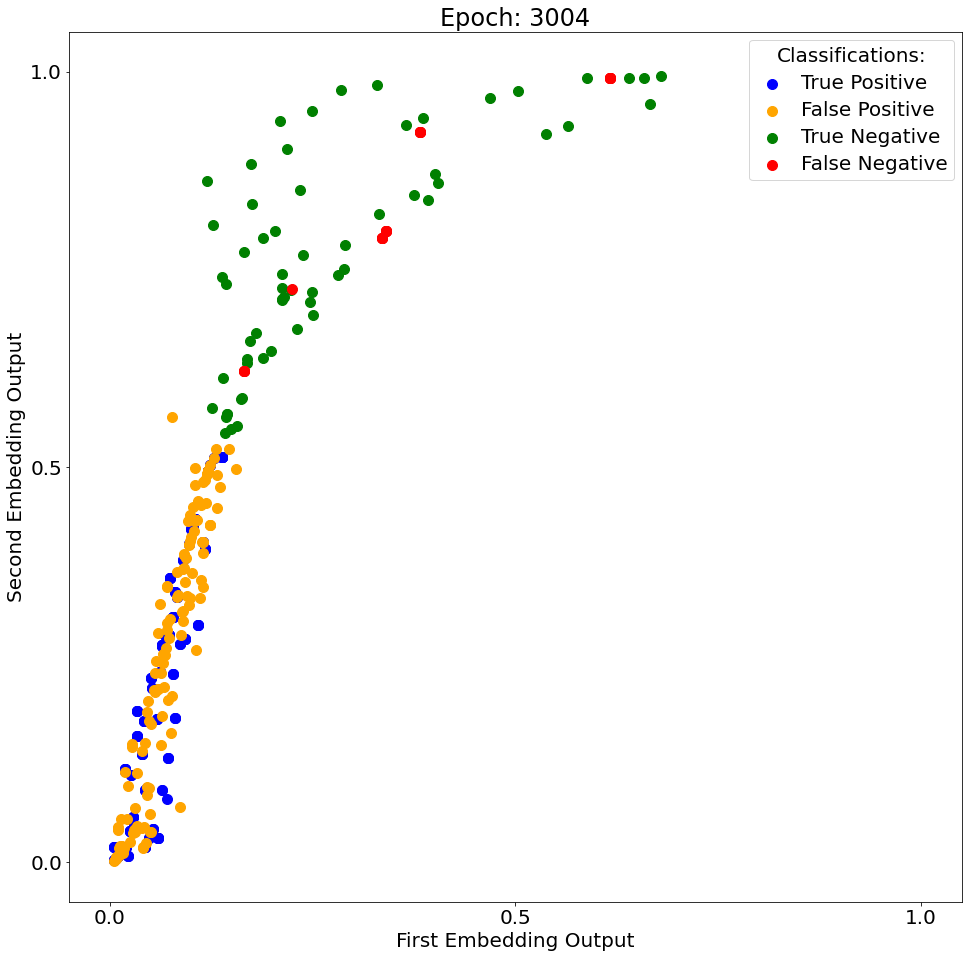

Epoch: 3004  Accuracy: 0.660569  FP: 139  TP: 264  TPR: 0.904110  TNR: 0.305000


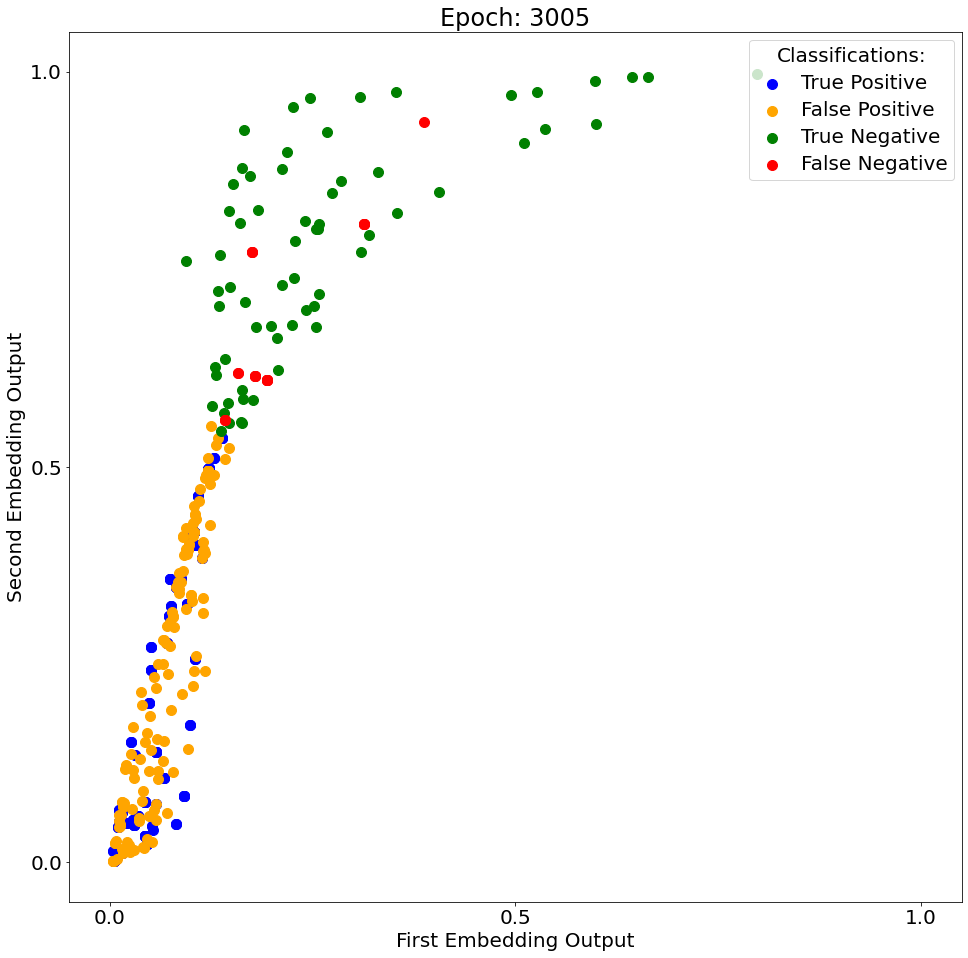

Epoch: 3005  Accuracy: 0.653307  FP: 149  TP: 261  TPR: 0.915789  TNR: 0.303738


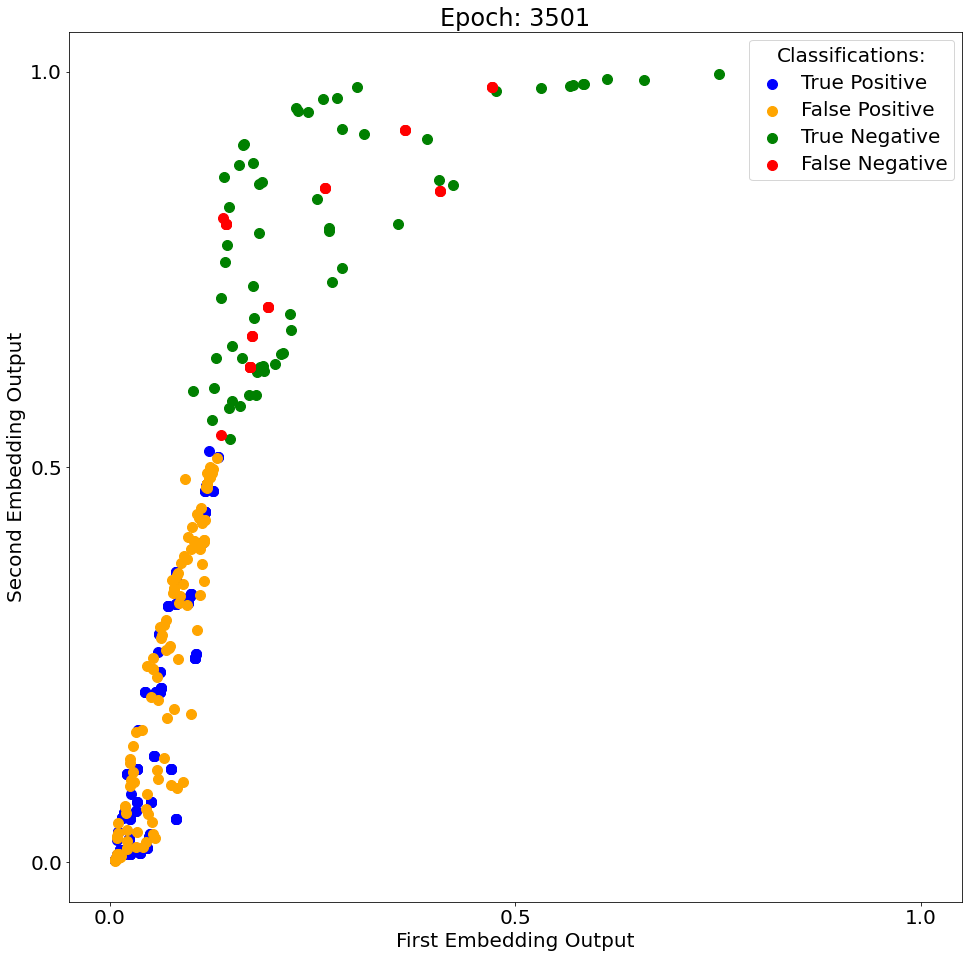

Epoch: 3501  Accuracy: 0.656504  FP: 135  TP: 261  TPR: 0.884746  TNR: 0.314721


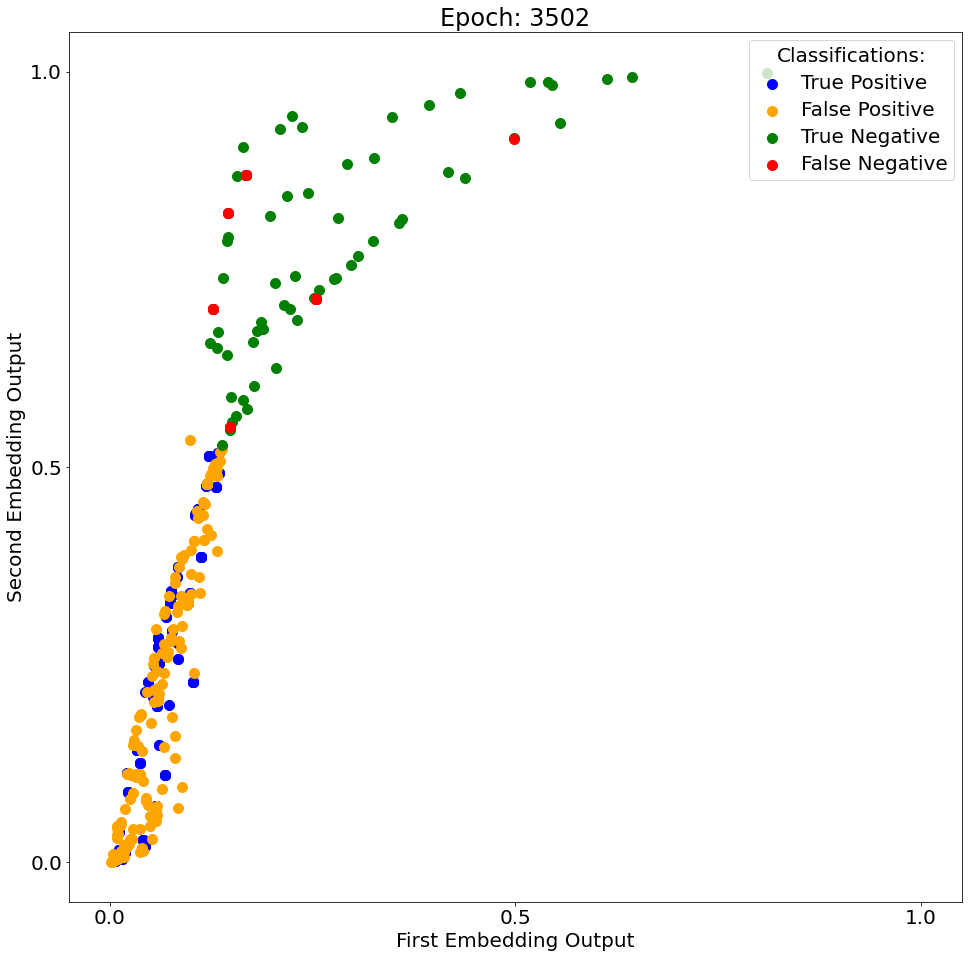

Epoch: 3502  Accuracy: 0.637275  FP: 152  TP: 260  TPR: 0.899654  TNR: 0.276190


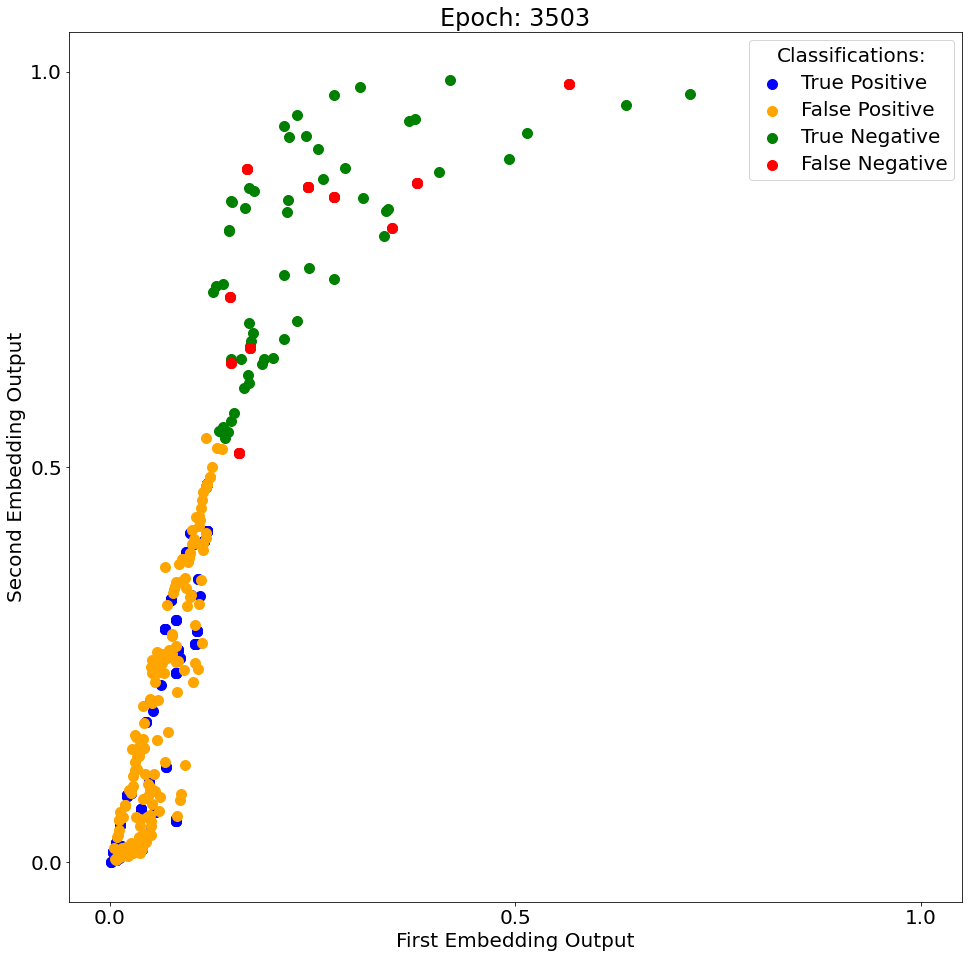

Epoch: 3503  Accuracy: 0.605364  FP: 168  TP: 259  TPR: 0.872054  TNR: 0.253333


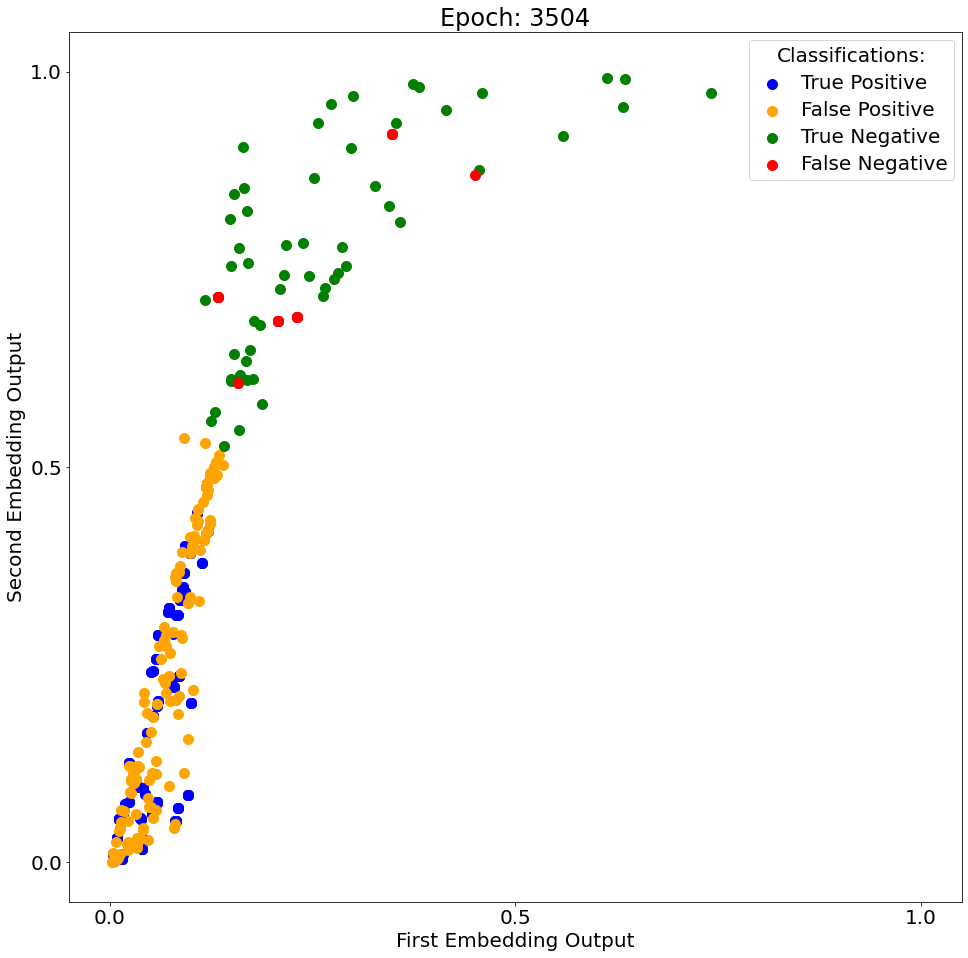

Epoch: 3504  Accuracy: 0.654472  FP: 145  TP: 267  TPR: 0.914384  TNR: 0.275000


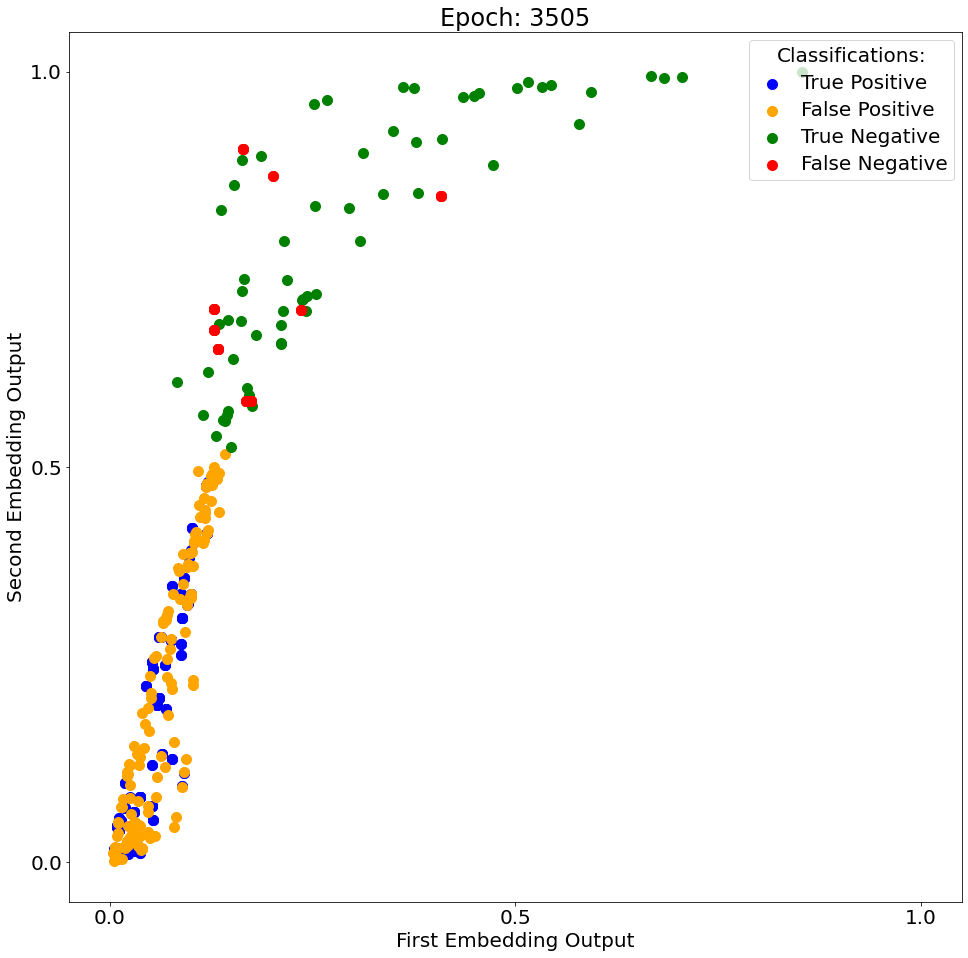

Epoch: 3505  Accuracy: 0.615230  FP: 152  TP: 245  TPR: 0.859649  TNR: 0.289720


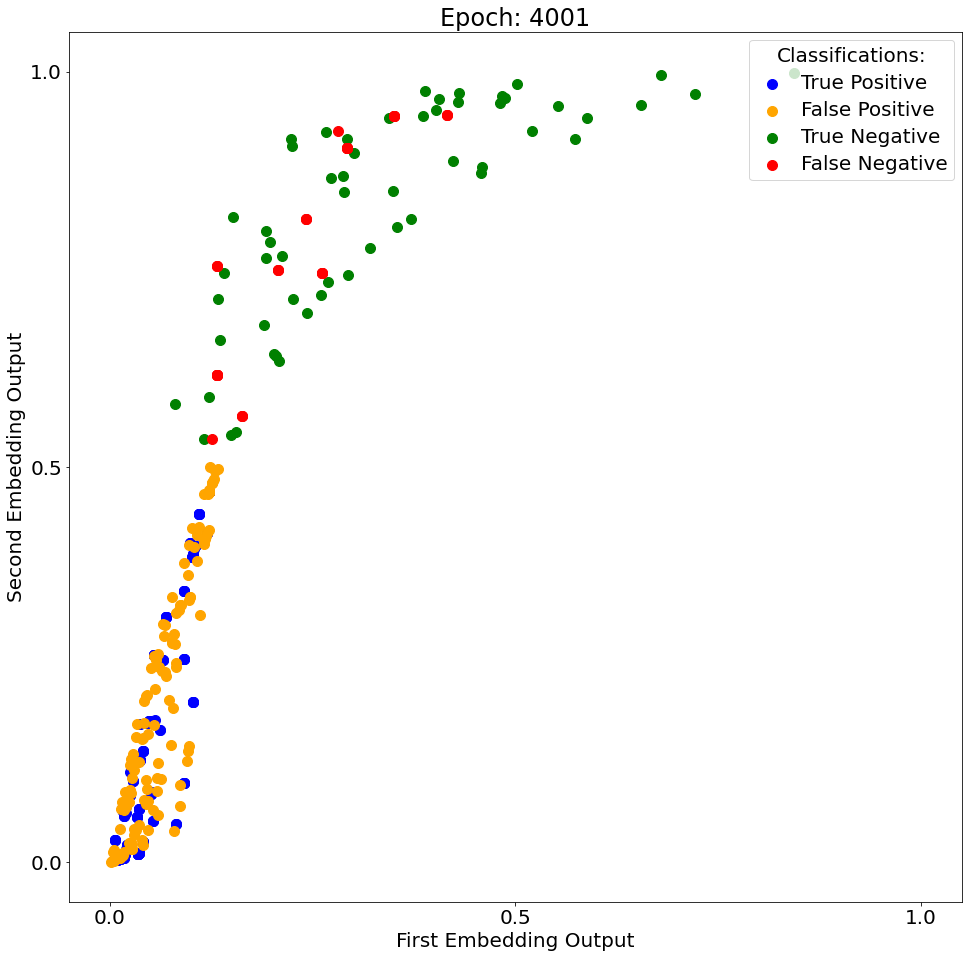

Epoch: 4001  Accuracy: 0.632114  FP: 141  TP: 255  TPR: 0.864407  TNR: 0.284264


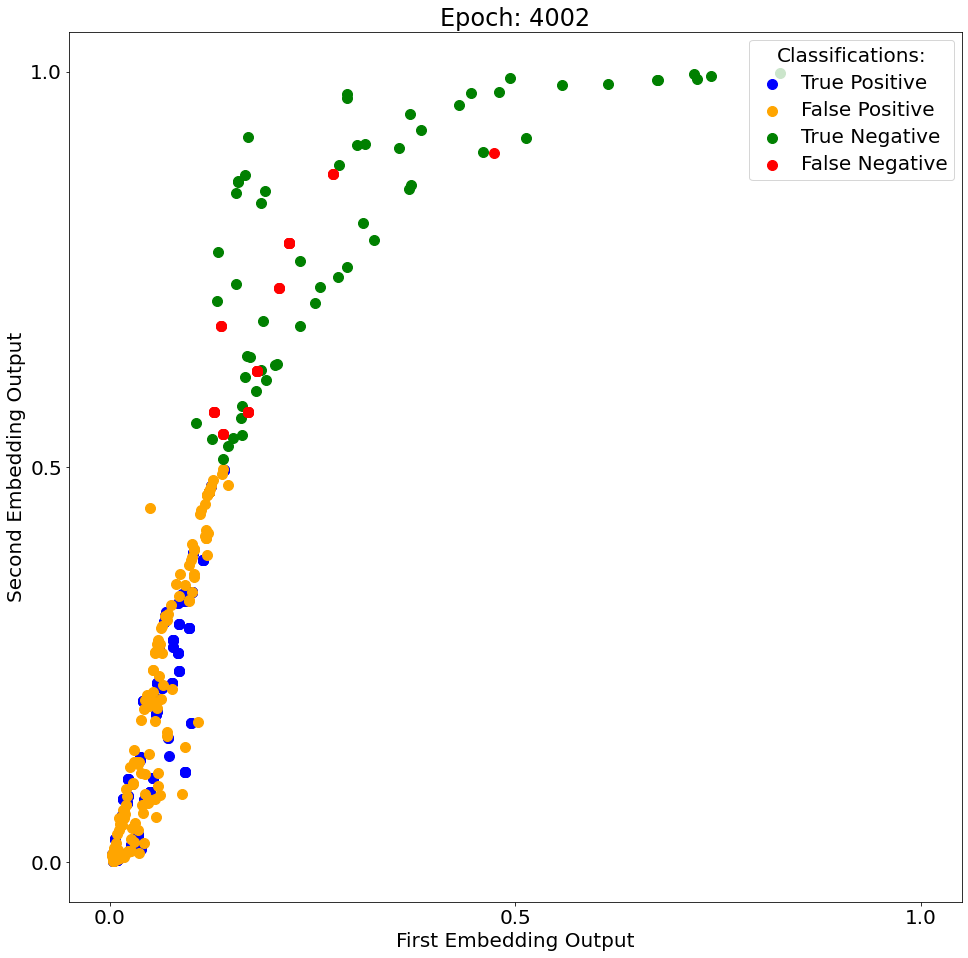

Epoch: 4002  Accuracy: 0.609218  FP: 151  TP: 245  TPR: 0.847751  TNR: 0.280952


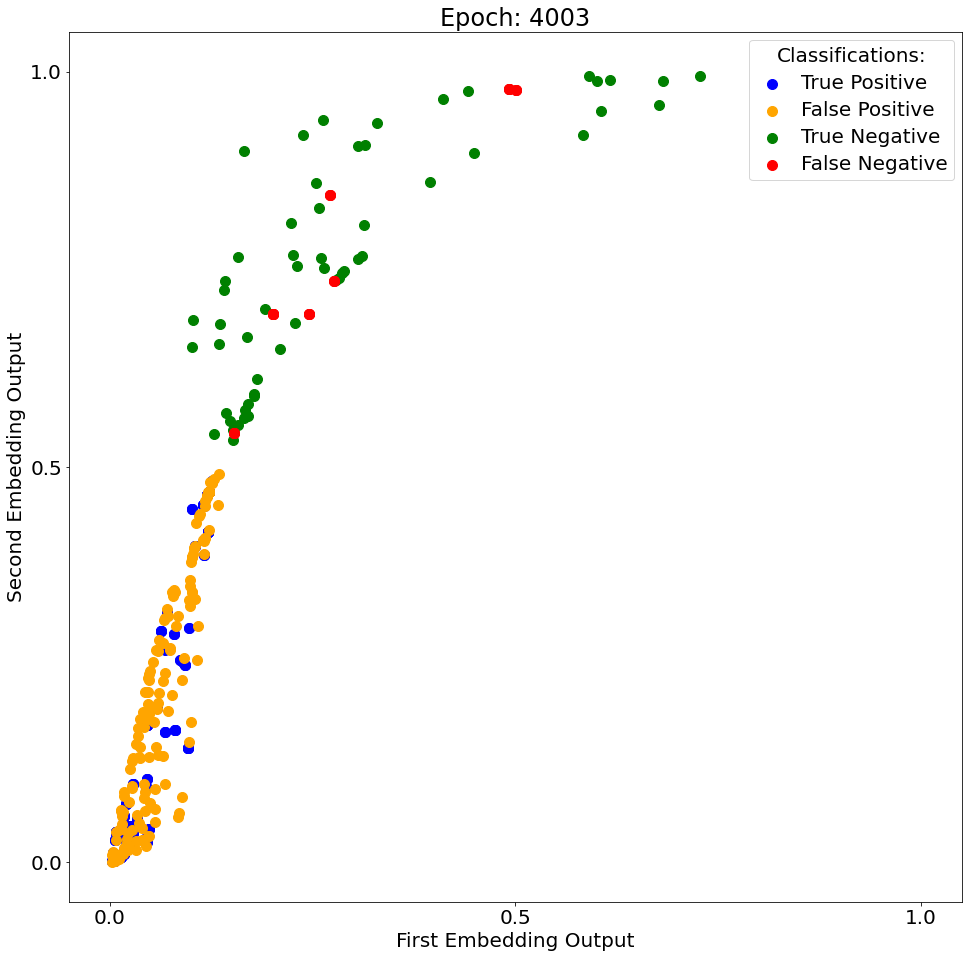

Epoch: 4003  Accuracy: 0.624521  FP: 169  TP: 270  TPR: 0.909091  TNR: 0.248889


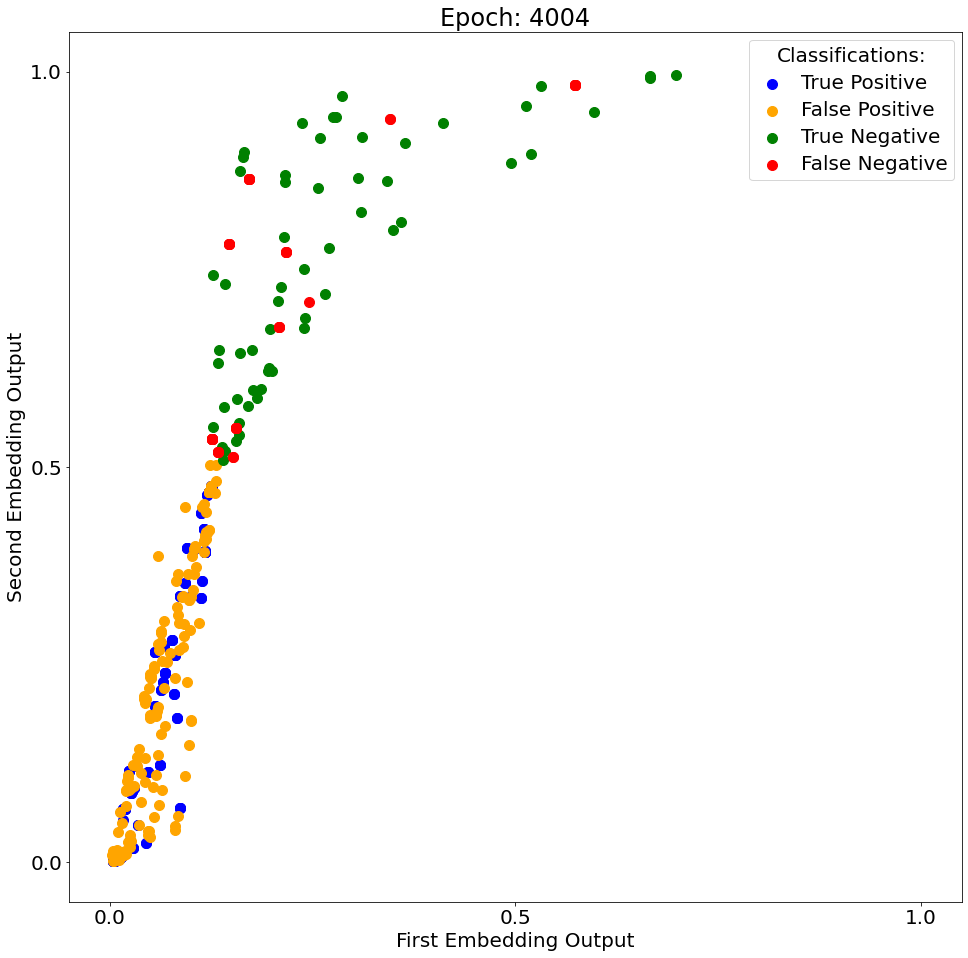

Epoch: 4004  Accuracy: 0.601626  FP: 141  TP: 237  TPR: 0.811644  TNR: 0.295000


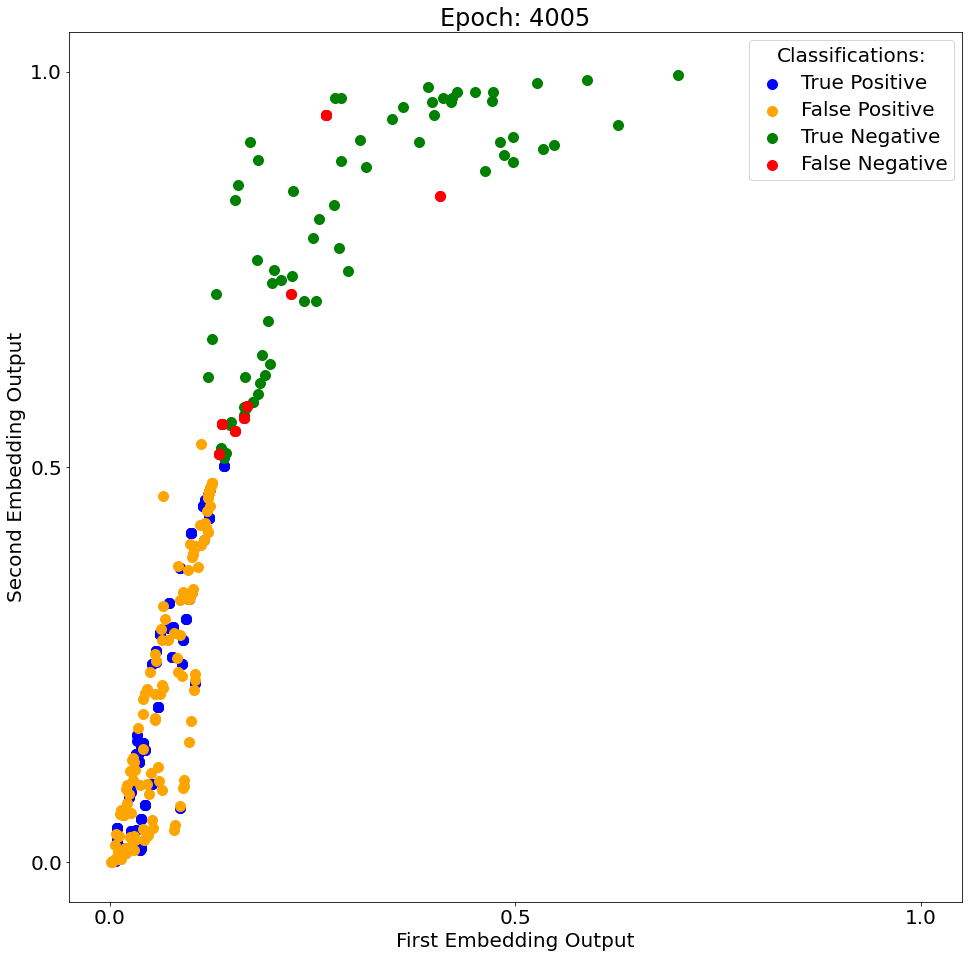

Epoch: 4005  Accuracy: 0.643287  FP: 147  TP: 254  TPR: 0.891228  TNR: 0.313084


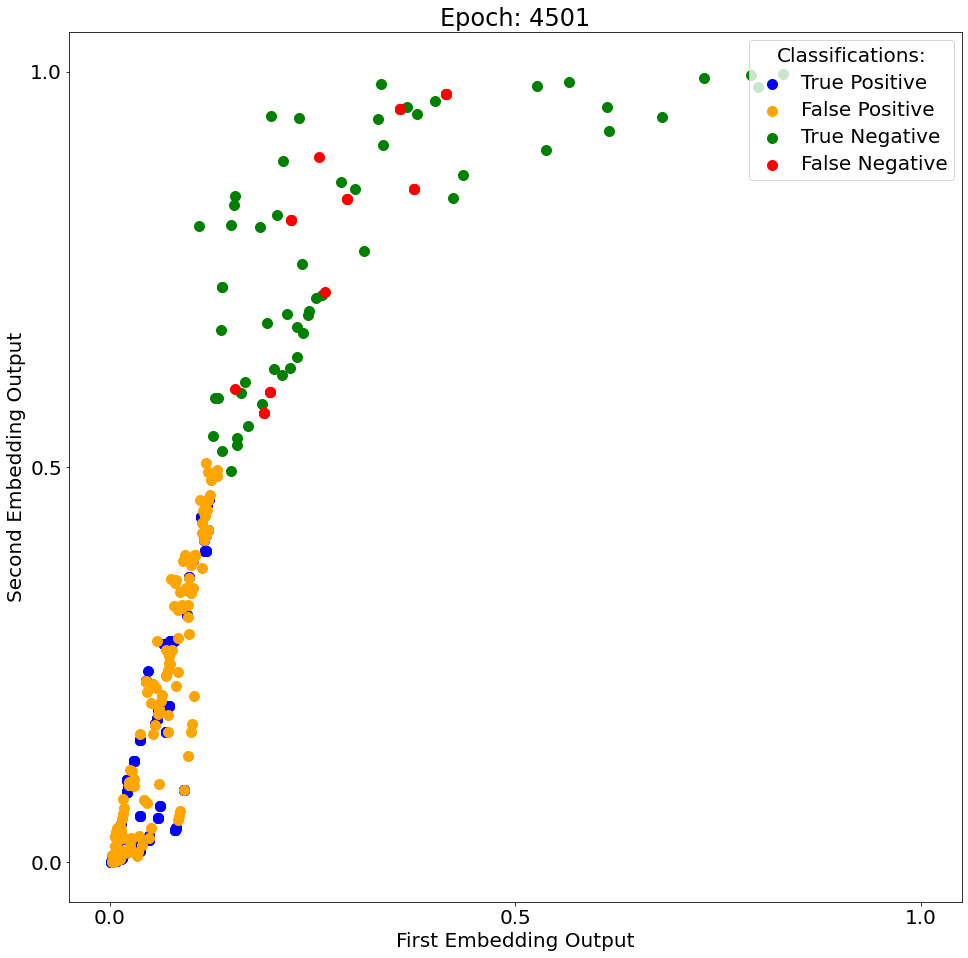

Epoch: 4501  Accuracy: 0.660569  FP: 140  TP: 268  TPR: 0.908475  TNR: 0.289340


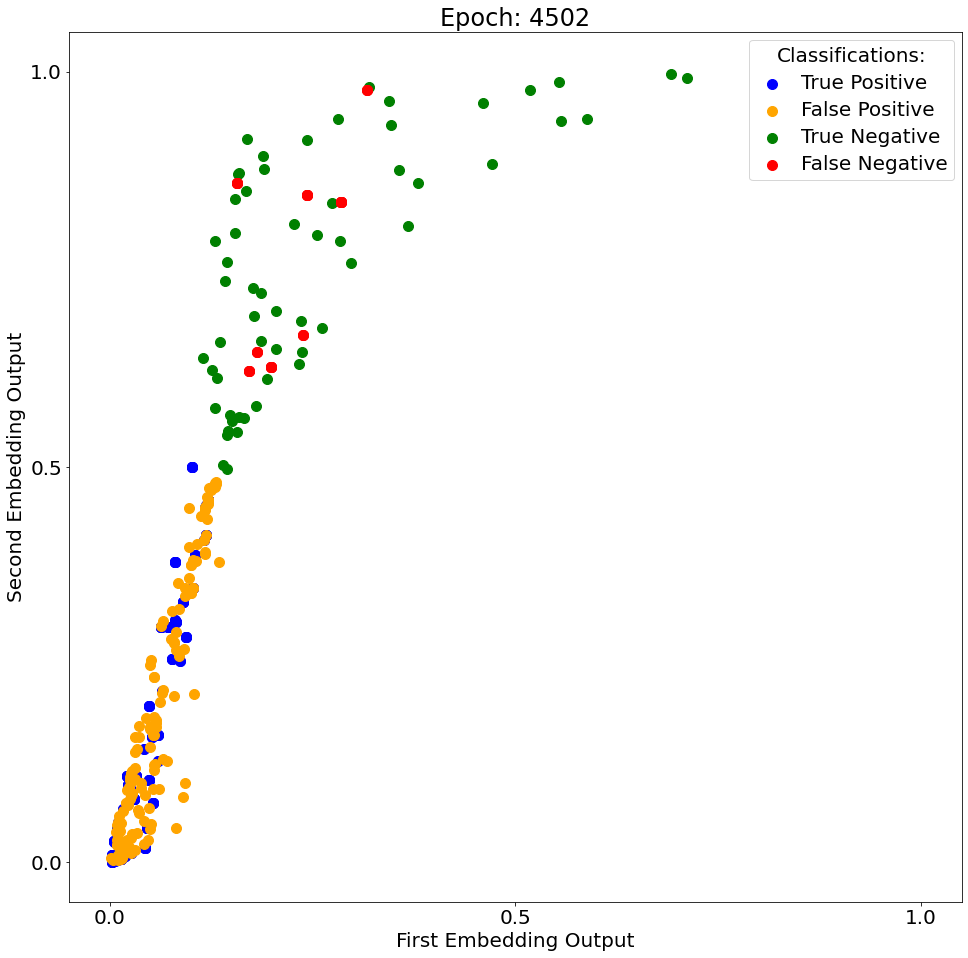

Epoch: 4502  Accuracy: 0.619238  FP: 152  TP: 251  TPR: 0.868512  TNR: 0.276190


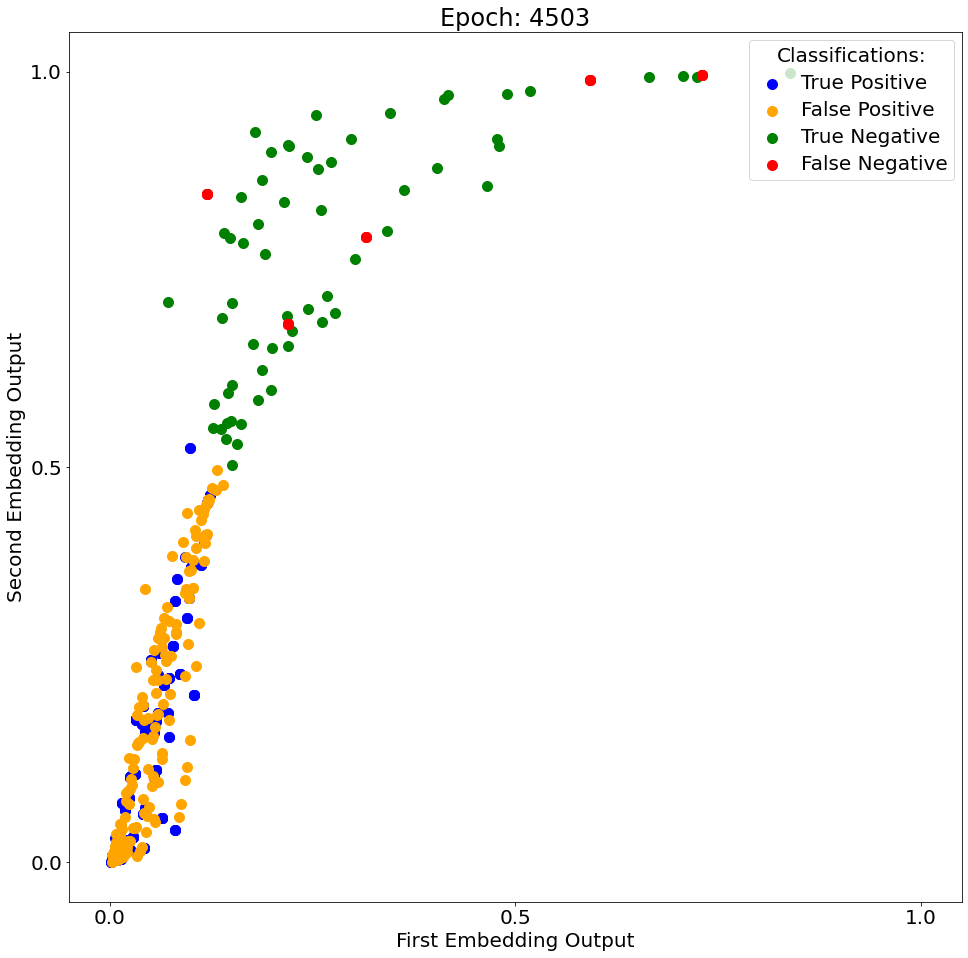

Epoch: 4503  Accuracy: 0.645594  FP: 165  TP: 277  TPR: 0.932660  TNR: 0.266667


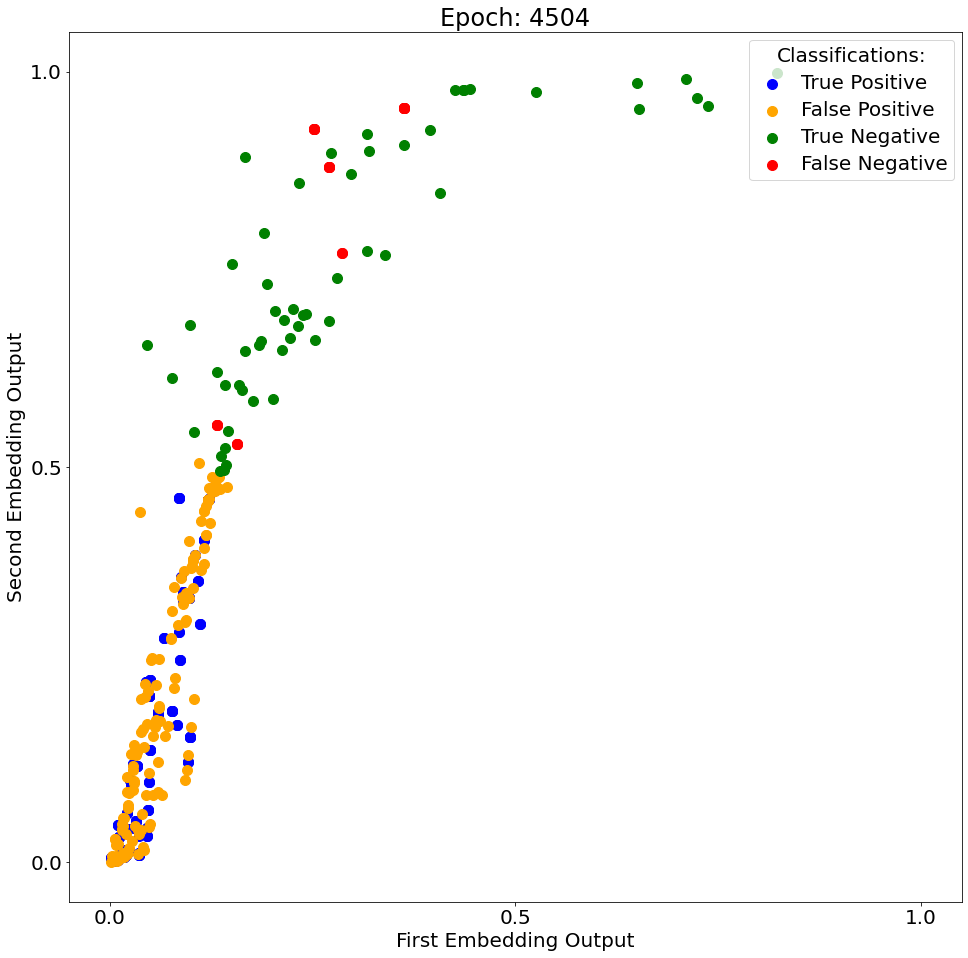

Epoch: 4504  Accuracy: 0.650406  FP: 145  TP: 265  TPR: 0.907534  TNR: 0.275000


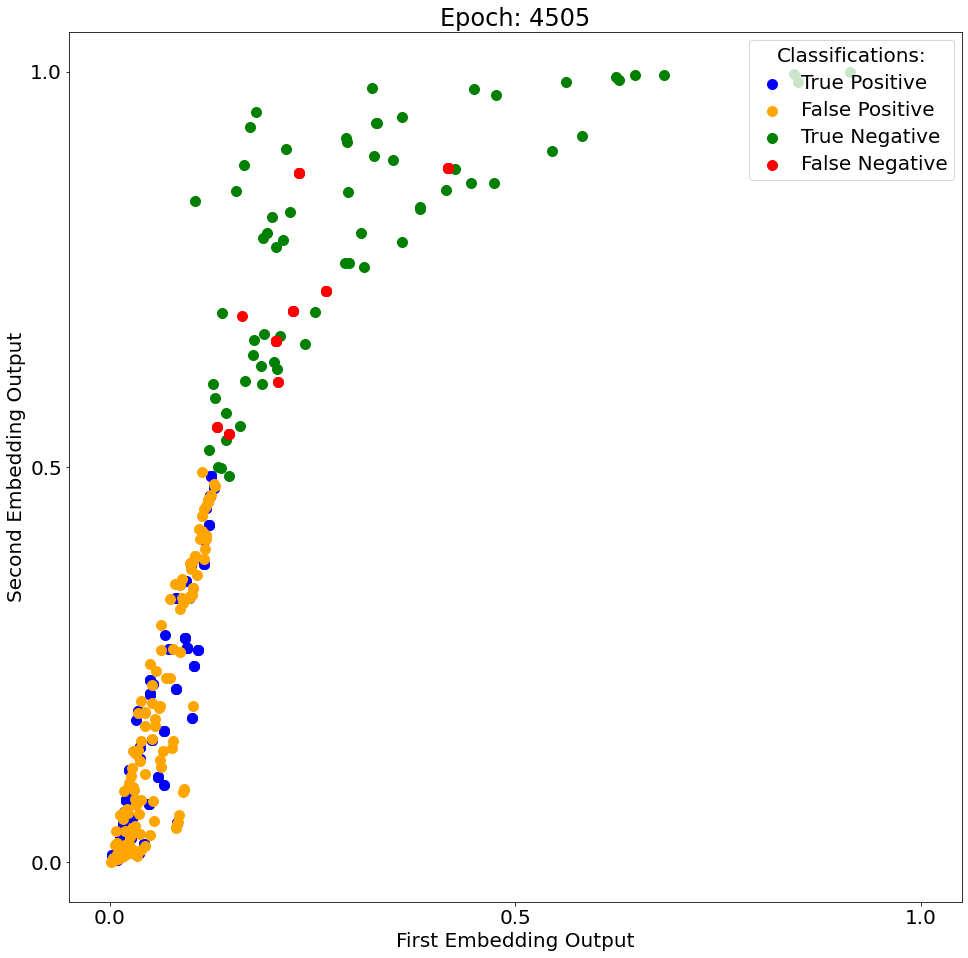

Epoch: 4505  Accuracy: 0.633267  FP: 149  TP: 251  TPR: 0.880702  TNR: 0.303738


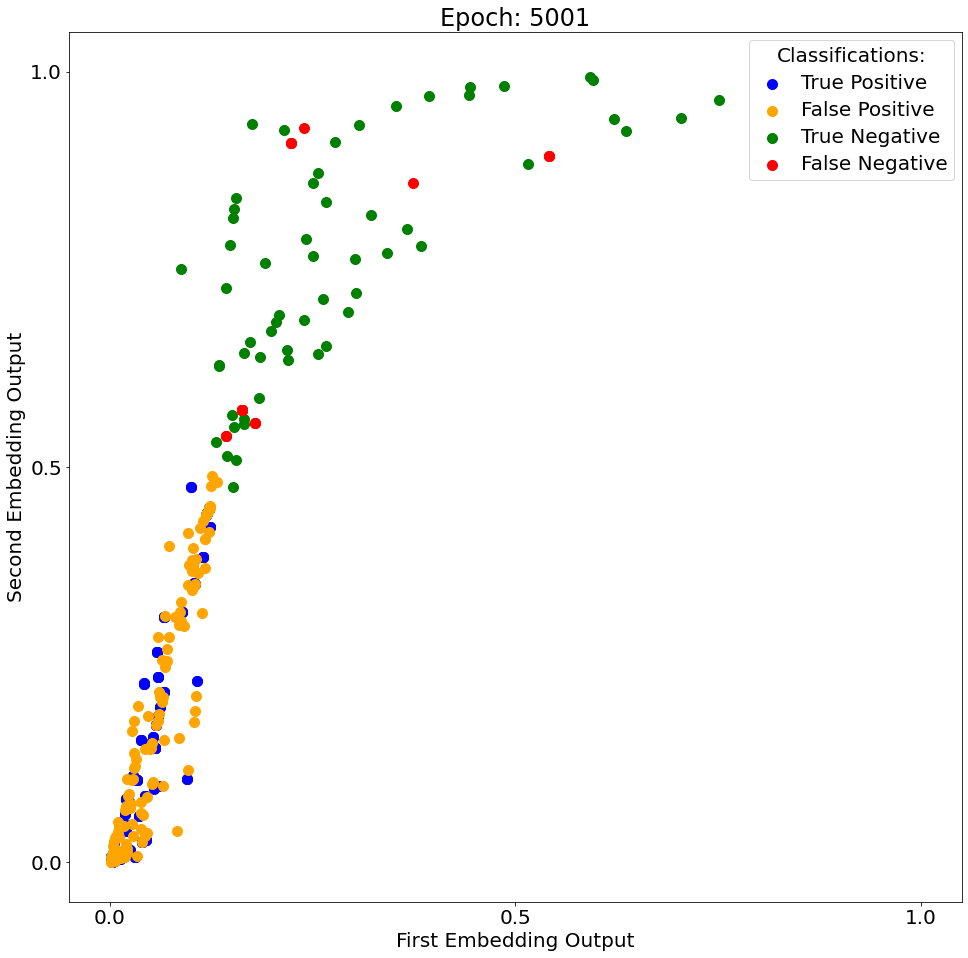

Epoch: 5001  Accuracy: 0.672764  FP: 139  TP: 273  TPR: 0.925424  TNR: 0.294416


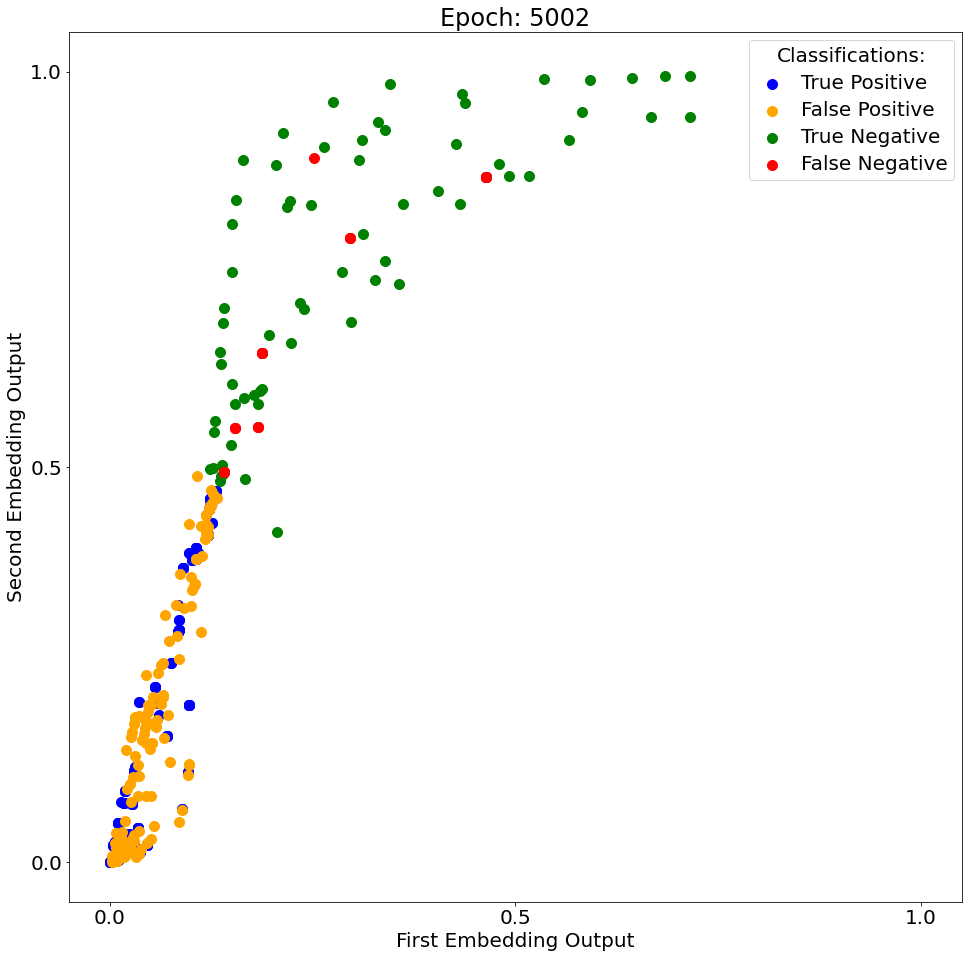

Epoch: 5002  Accuracy: 0.657315  FP: 144  TP: 262  TPR: 0.906574  TNR: 0.314286


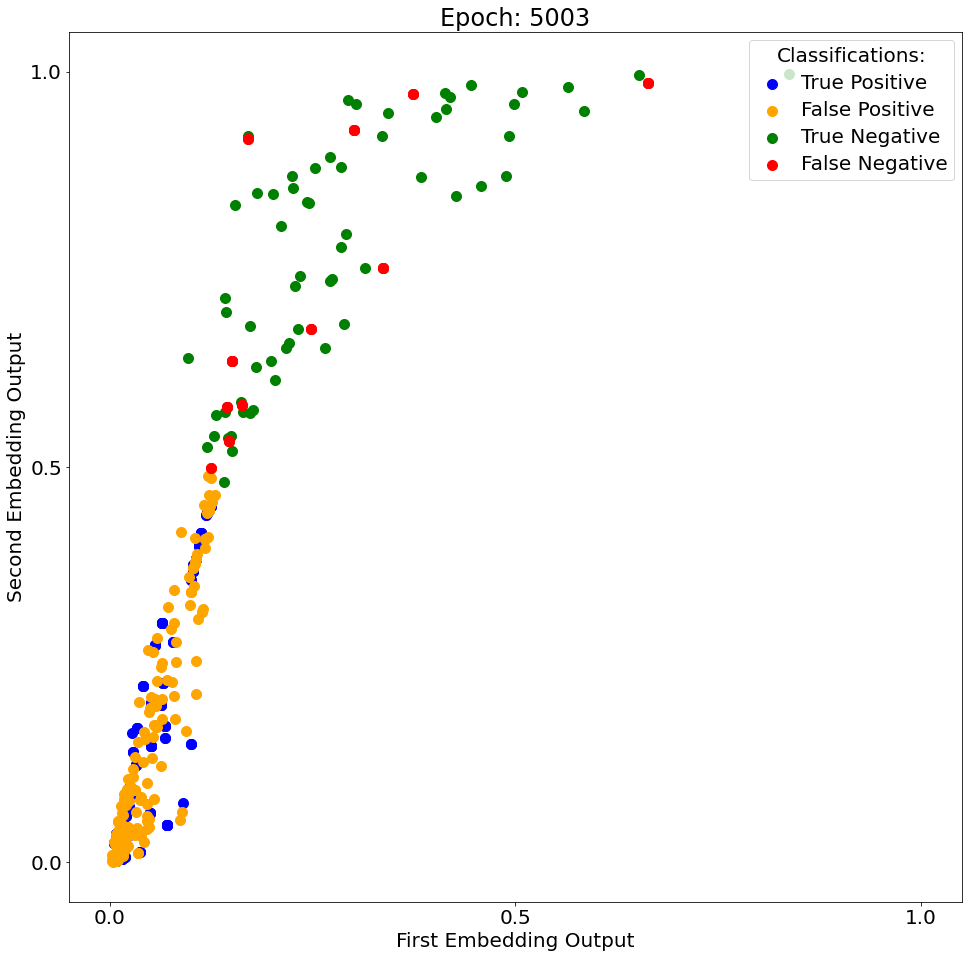

Epoch: 5003  Accuracy: 0.614943  FP: 162  TP: 258  TPR: 0.868687  TNR: 0.280000


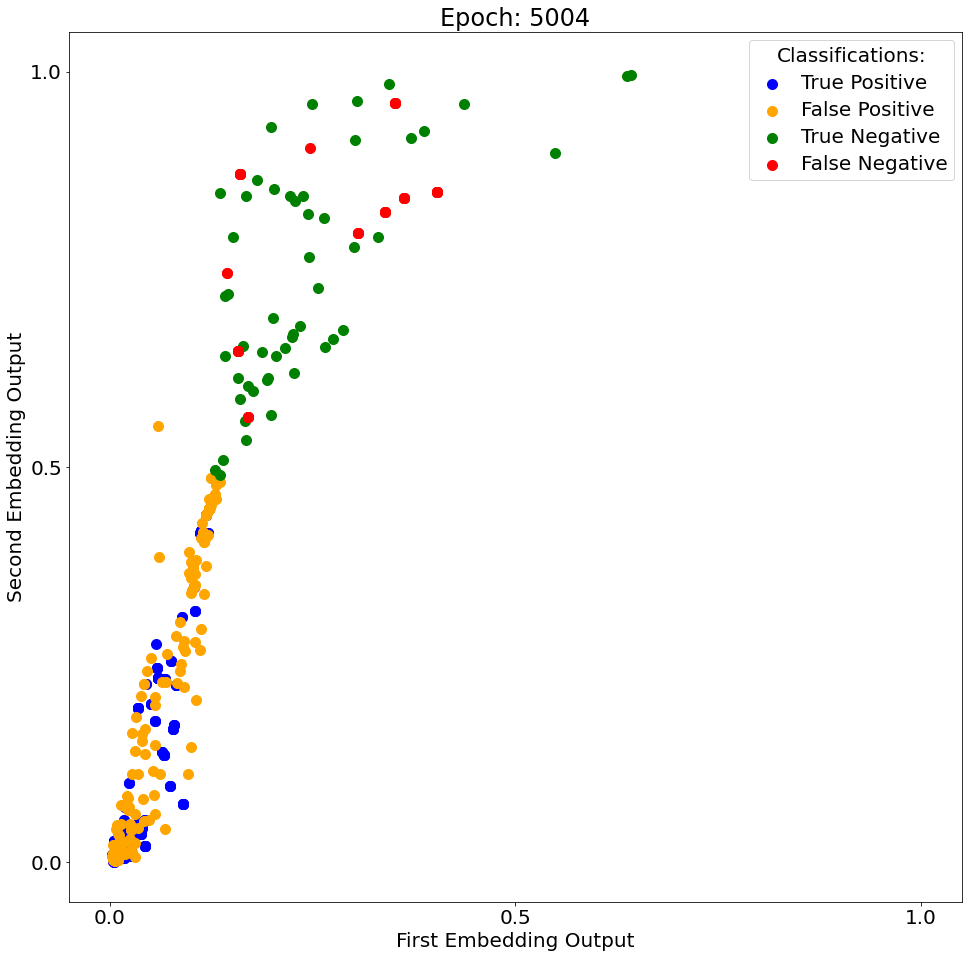

Epoch: 5004  Accuracy: 0.605691  FP: 148  TP: 246  TPR: 0.842466  TNR: 0.260000


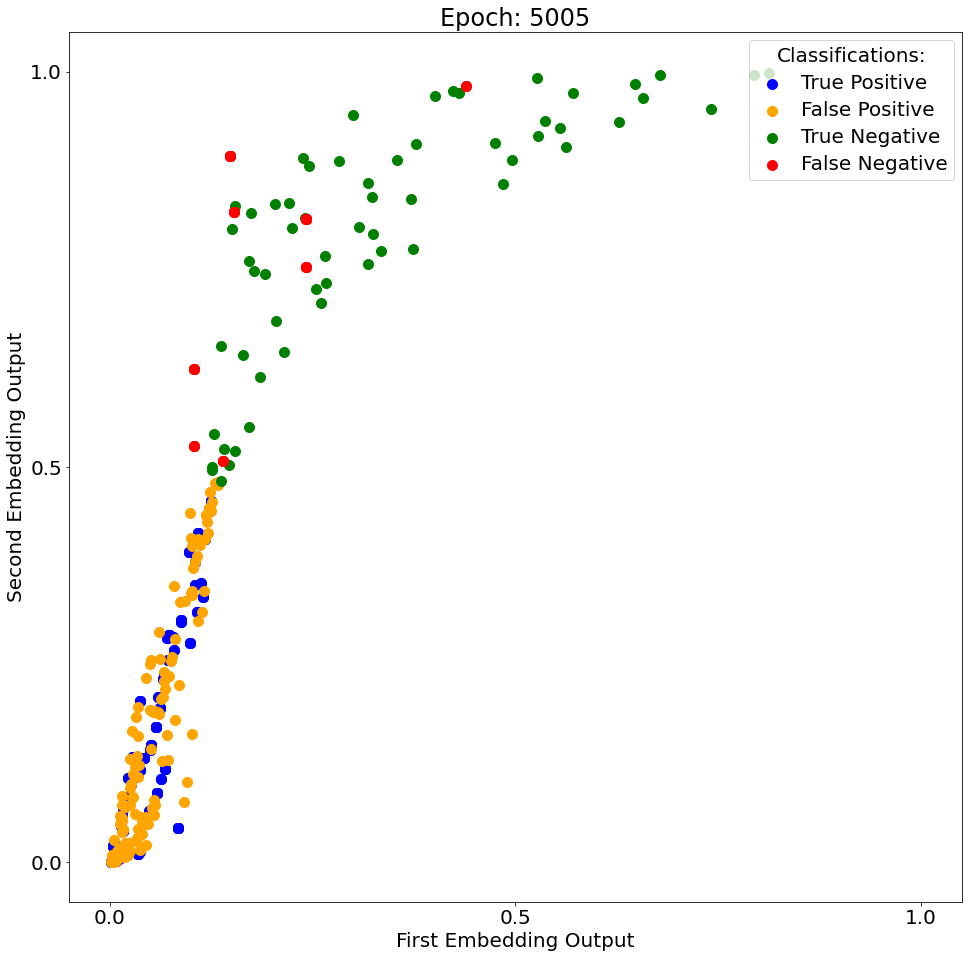

Epoch: 5005  Accuracy: 0.621242  FP: 154  TP: 250  TPR: 0.877193  TNR: 0.280374


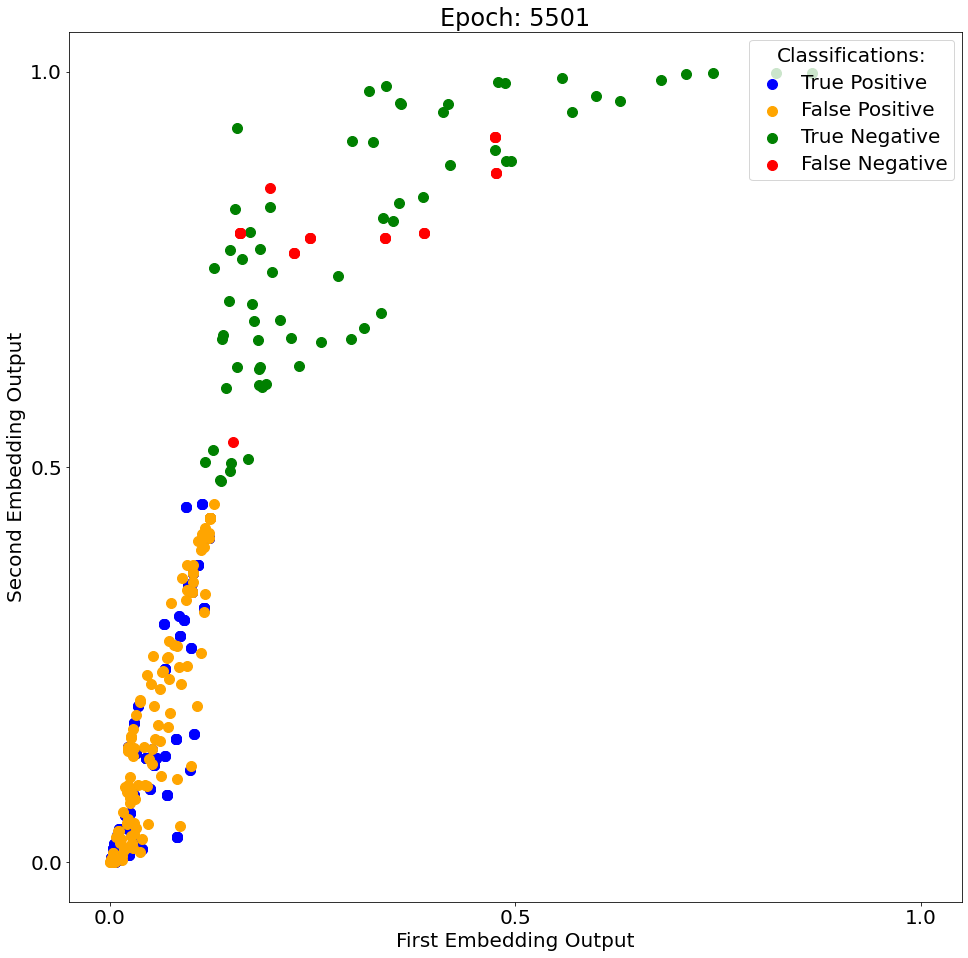

Epoch: 5501  Accuracy: 0.674797  FP: 133  TP: 268  TPR: 0.908475  TNR: 0.324873


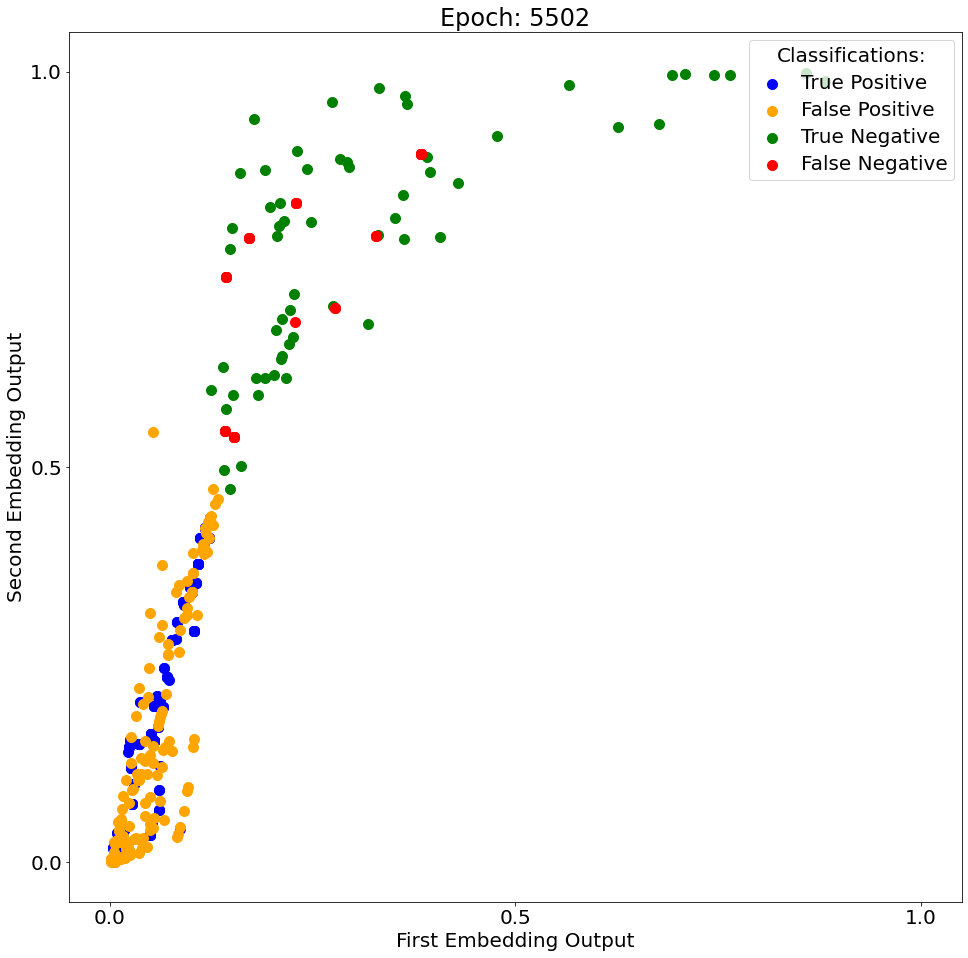

Epoch: 5502  Accuracy: 0.613226  FP: 150  TP: 246  TPR: 0.851211  TNR: 0.285714


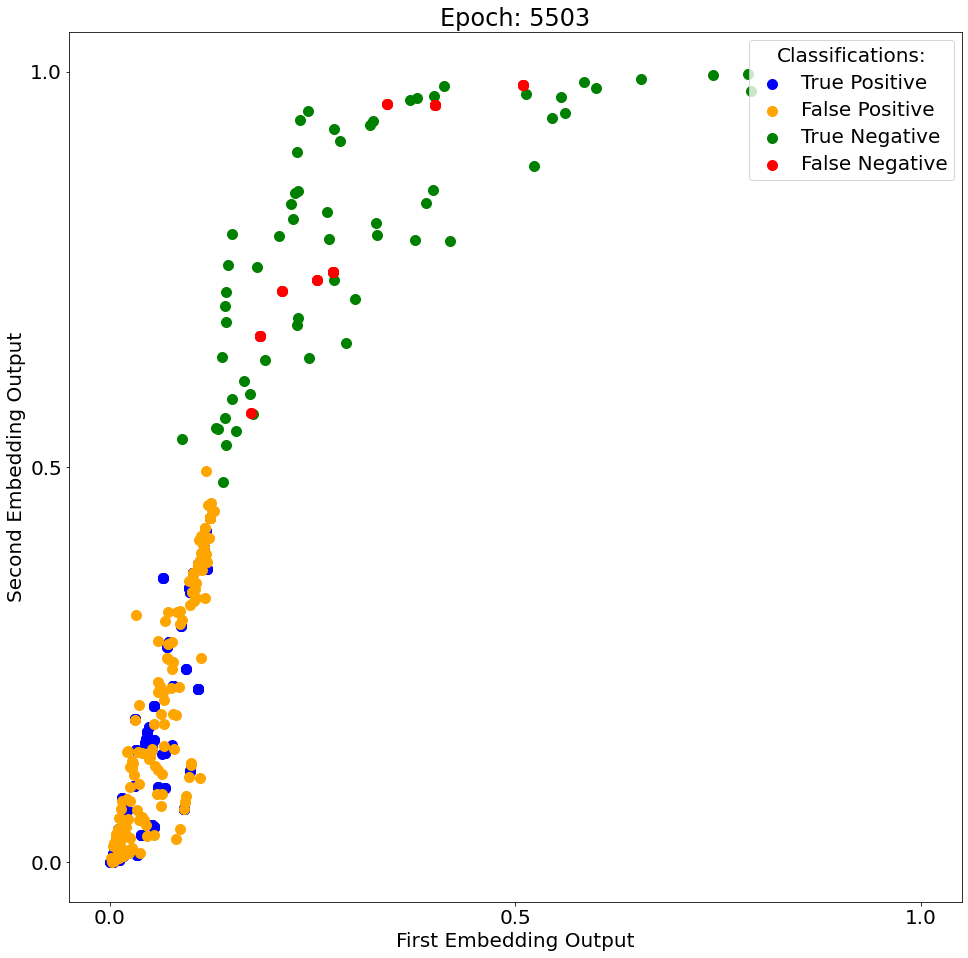

Epoch: 5503  Accuracy: 0.624521  FP: 165  TP: 266  TPR: 0.895623  TNR: 0.266667


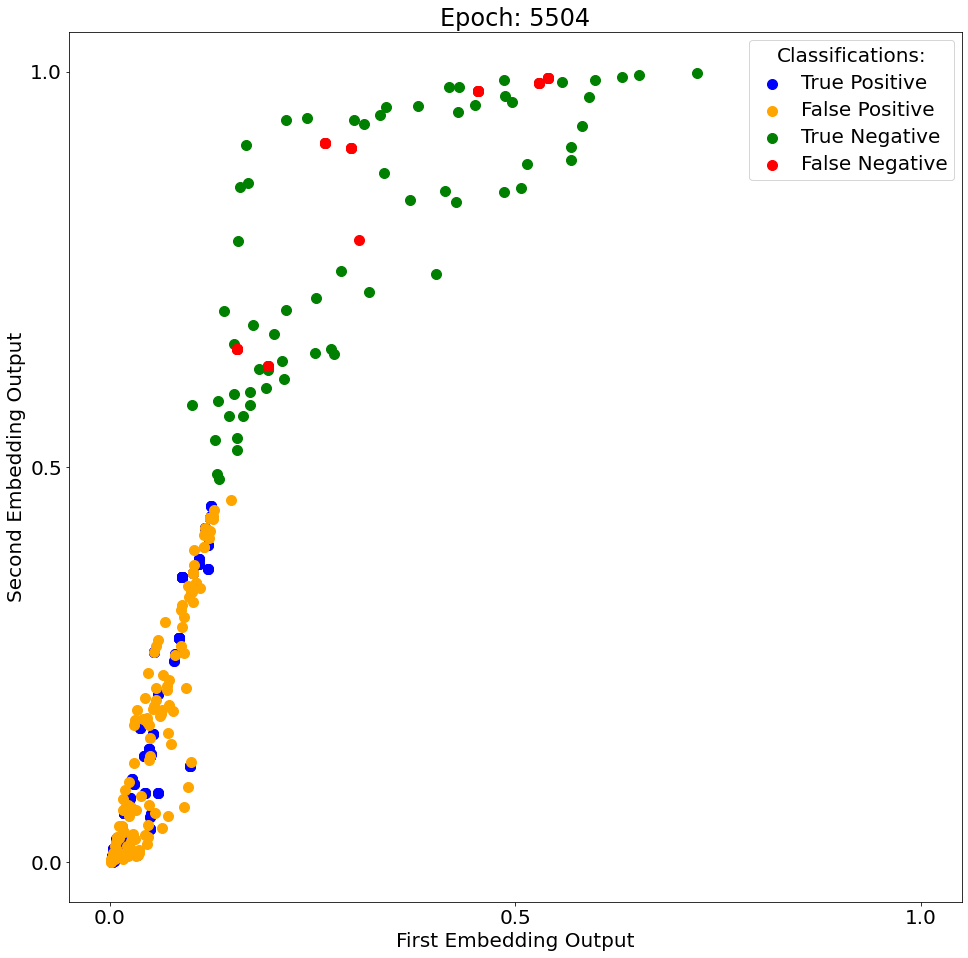

Epoch: 5504  Accuracy: 0.640244  FP: 137  TP: 252  TPR: 0.863014  TNR: 0.315000


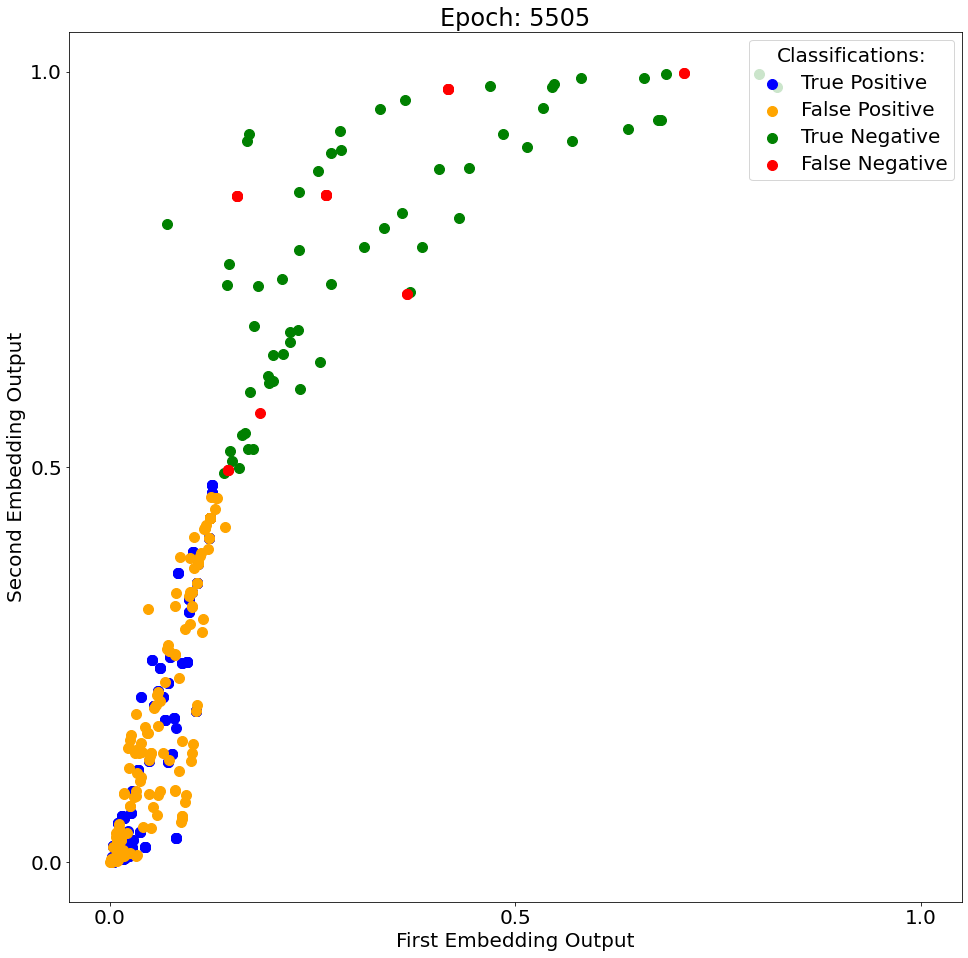

Epoch: 5505  Accuracy: 0.645291  FP: 155  TP: 263  TPR: 0.922807  TNR: 0.275701


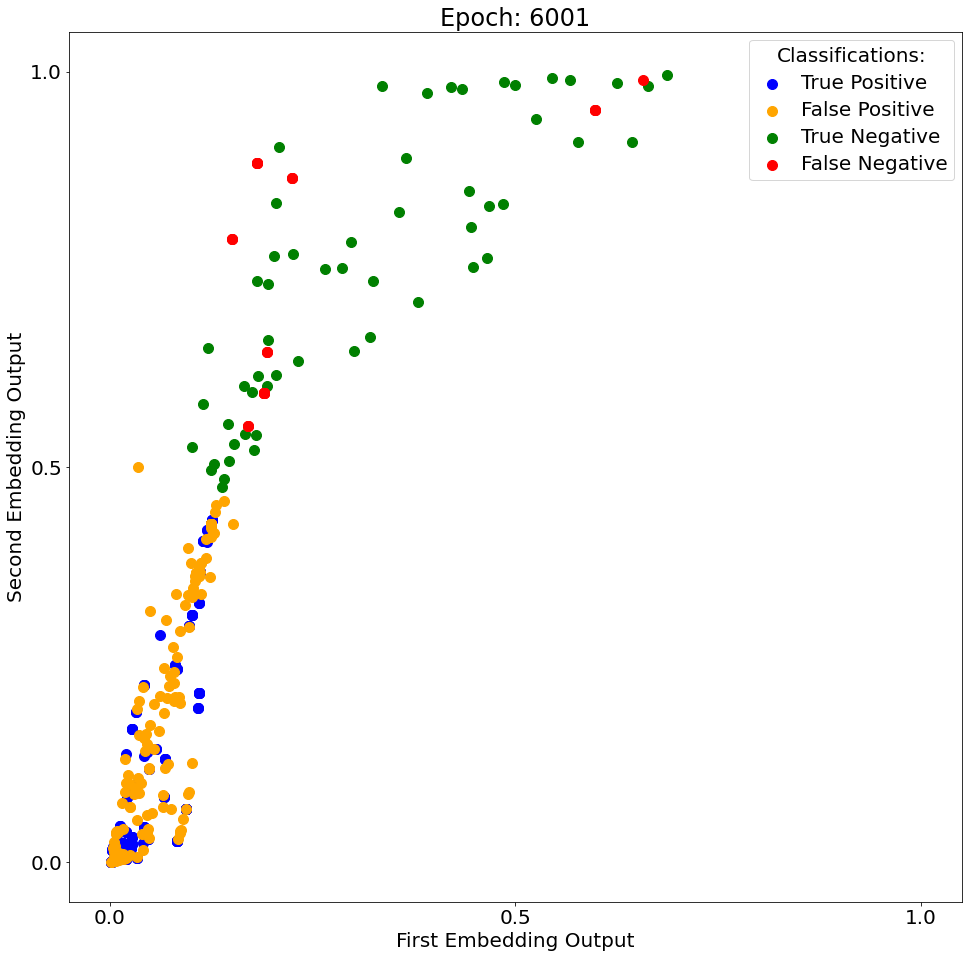

Epoch: 6001  Accuracy: 0.650406  FP: 142  TP: 265  TPR: 0.898305  TNR: 0.279188


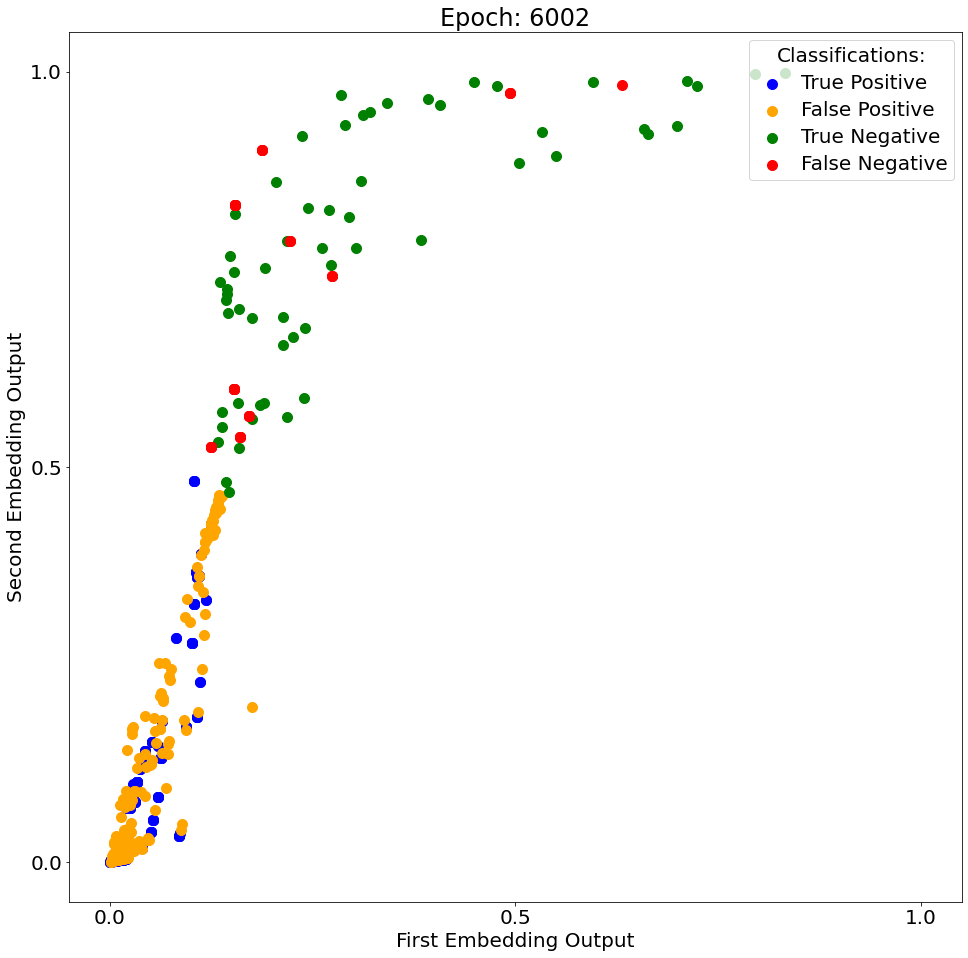

Epoch: 6002  Accuracy: 0.603206  FP: 152  TP: 243  TPR: 0.840830  TNR: 0.276190


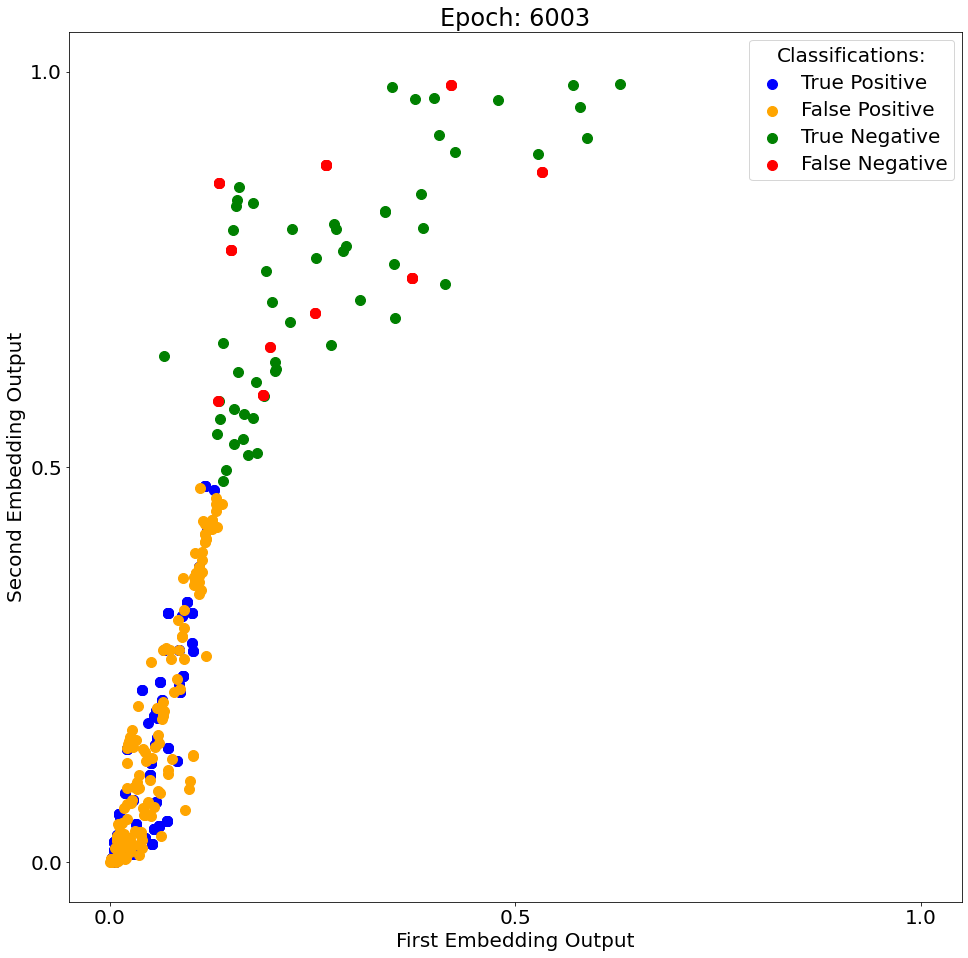

Epoch: 6003  Accuracy: 0.601533  FP: 171  TP: 260  TPR: 0.875421  TNR: 0.240000


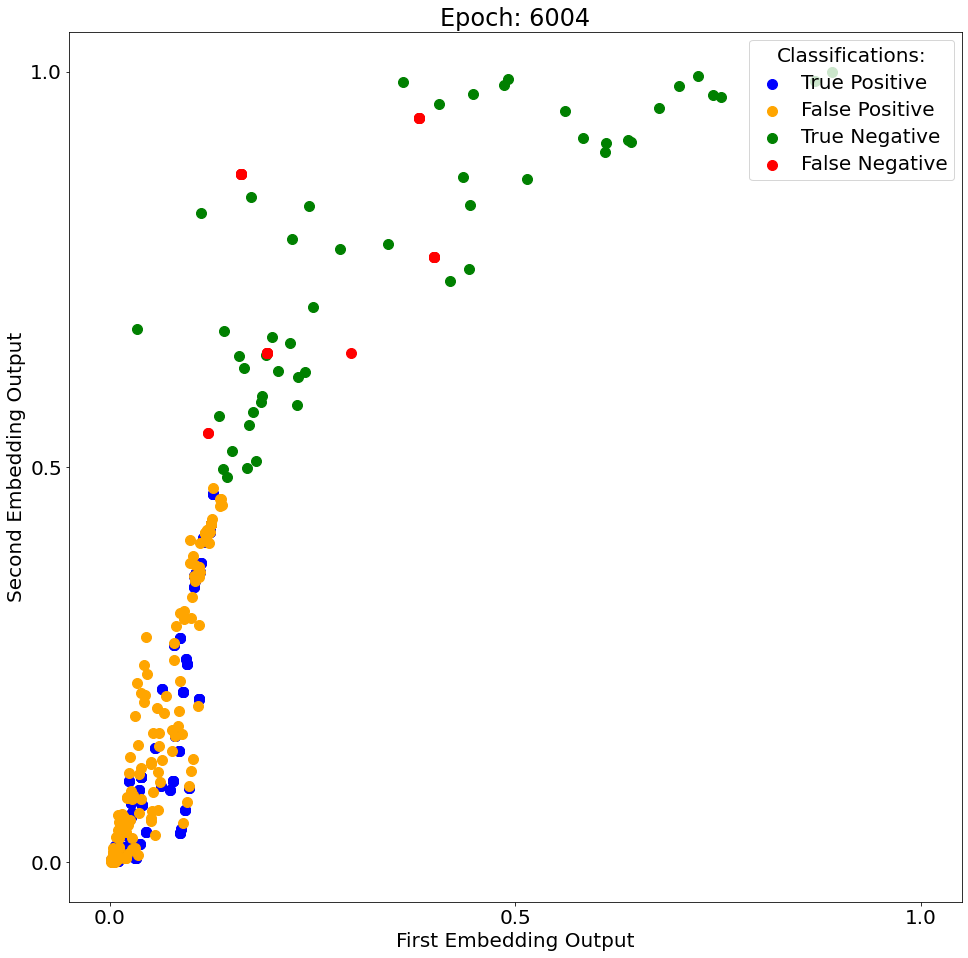

Epoch: 6004  Accuracy: 0.642276  FP: 149  TP: 265  TPR: 0.907534  TNR: 0.255000


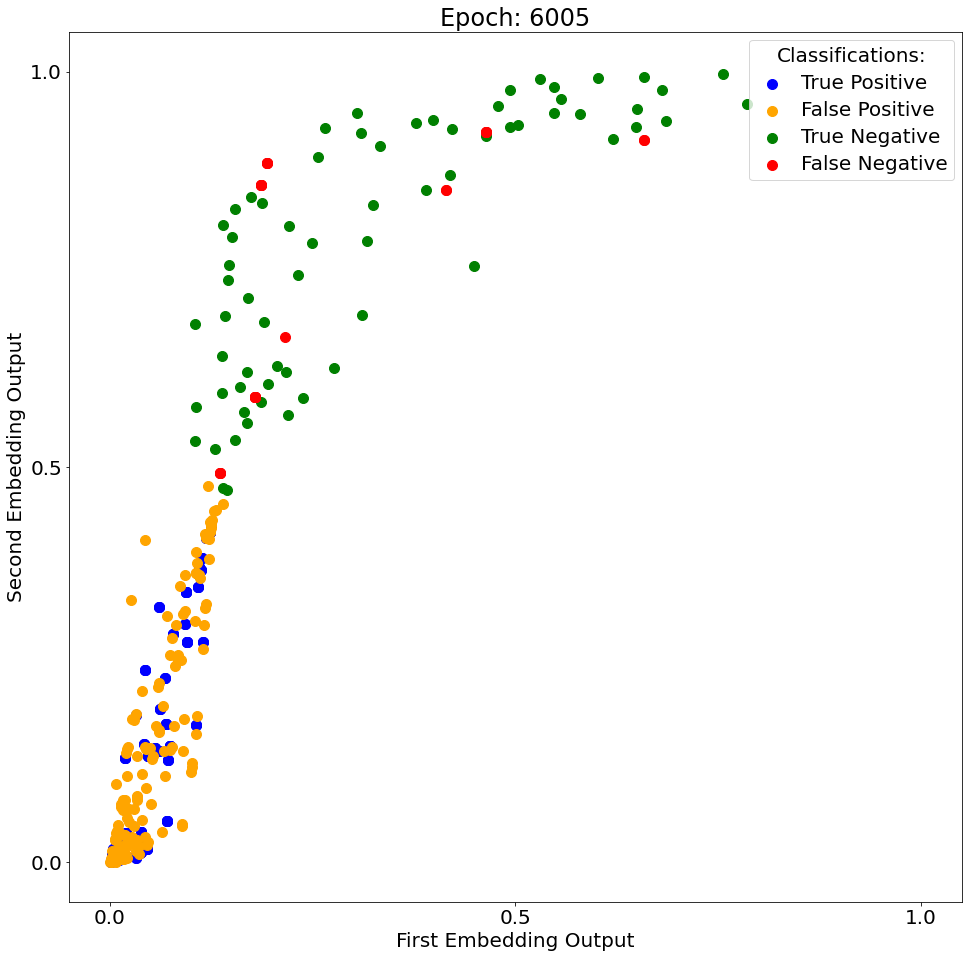

Epoch: 6005  Accuracy: 0.645291  FP: 148  TP: 256  TPR: 0.898246  TNR: 0.308411


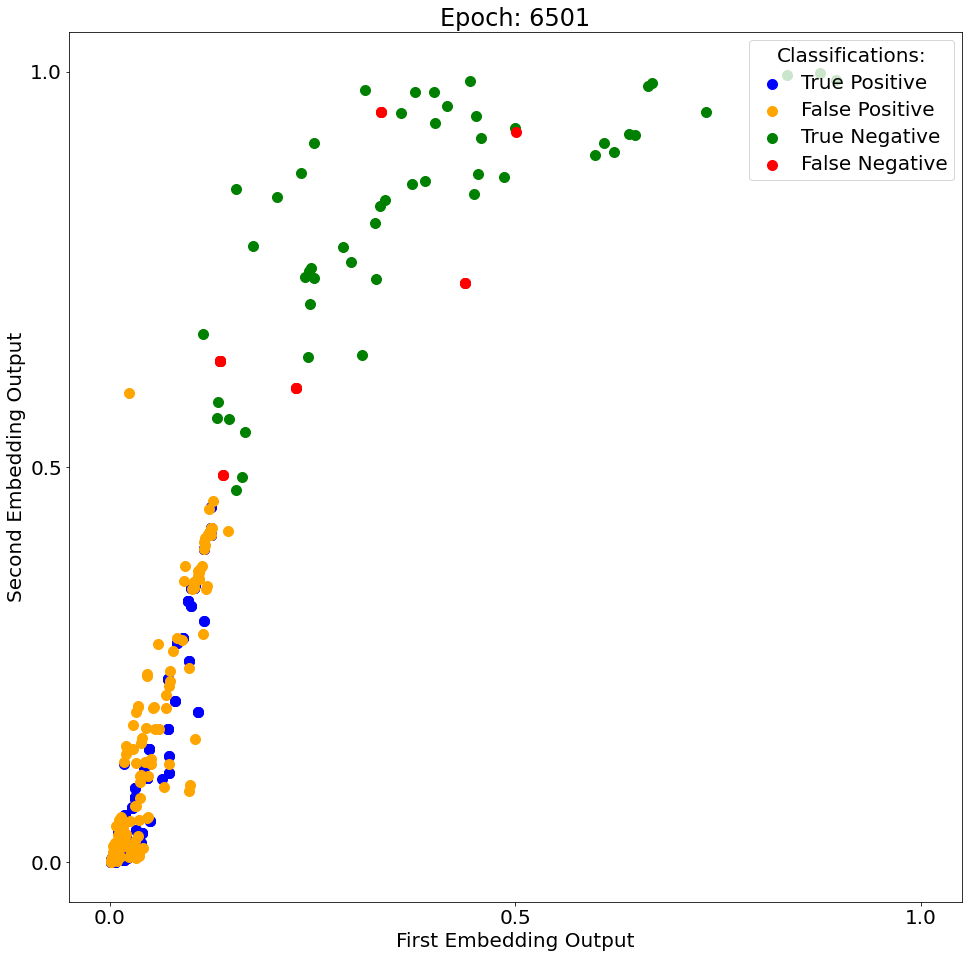

Epoch: 6501  Accuracy: 0.658537  FP: 146  TP: 273  TPR: 0.925424  TNR: 0.258883


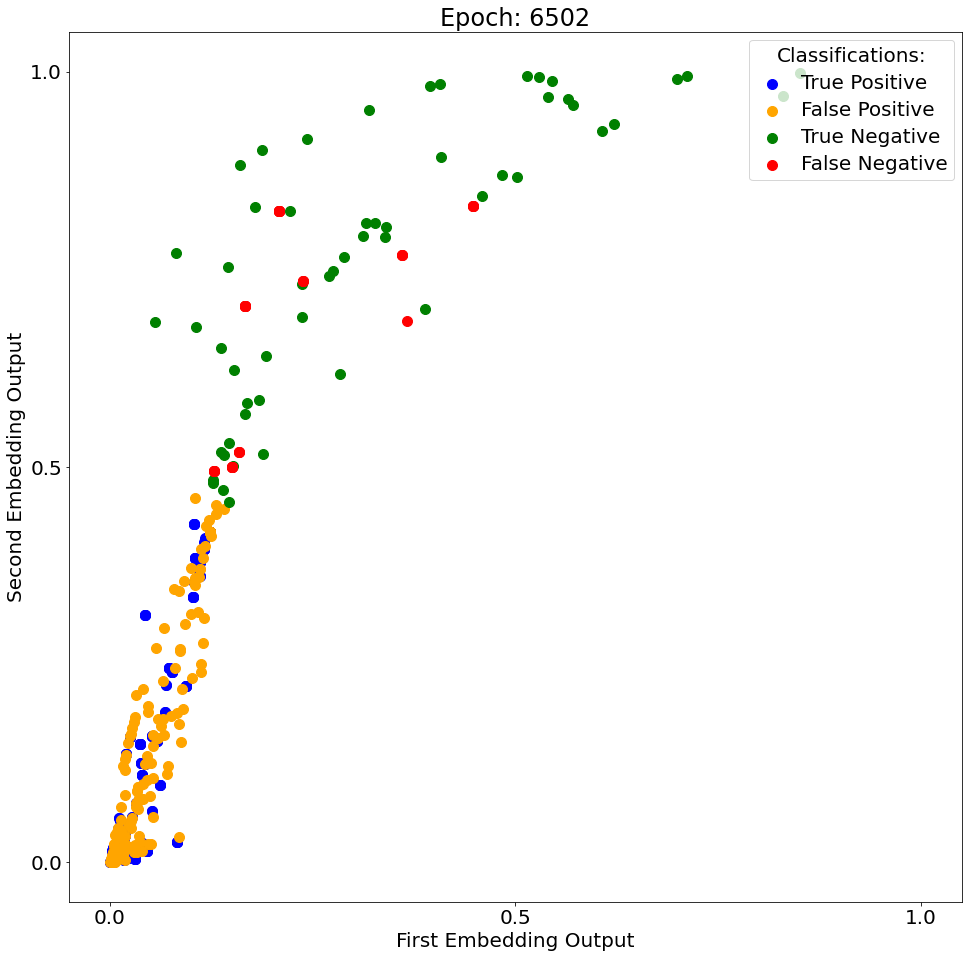

Epoch: 6502  Accuracy: 0.609218  FP: 155  TP: 249  TPR: 0.861592  TNR: 0.261905


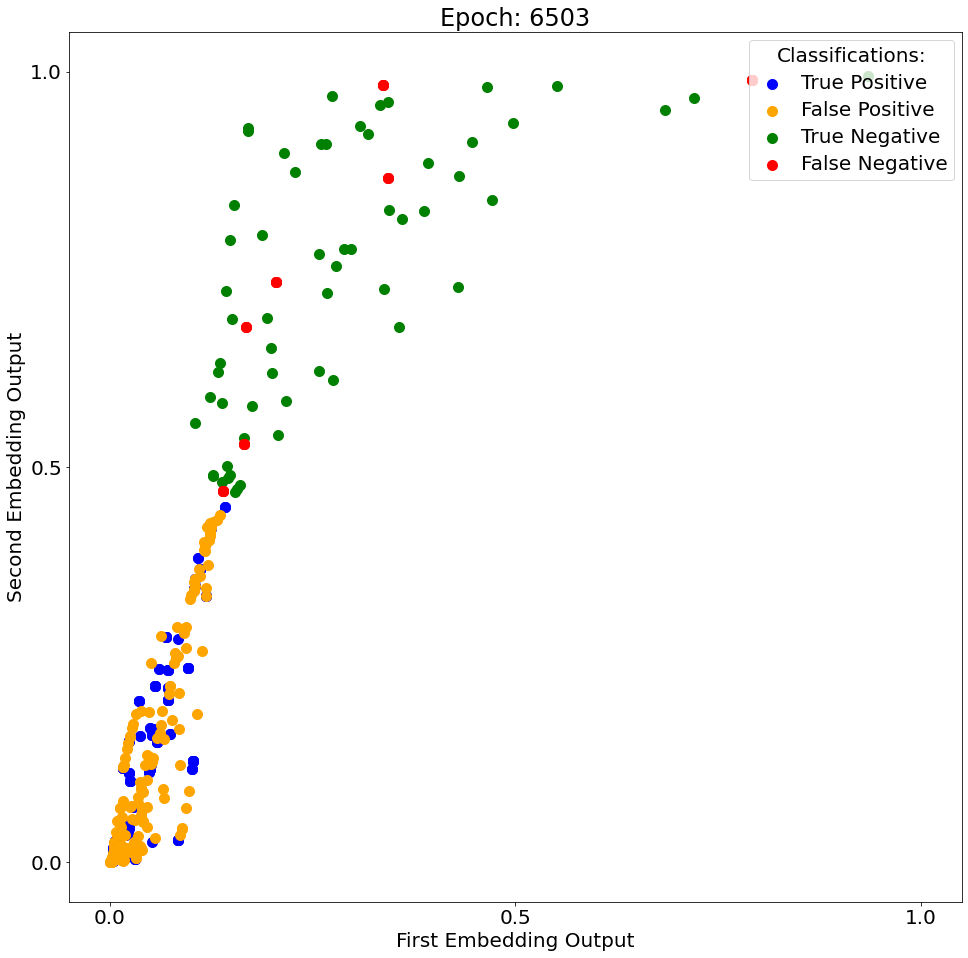

Epoch: 6503  Accuracy: 0.630268  FP: 165  TP: 269  TPR: 0.905724  TNR: 0.266667


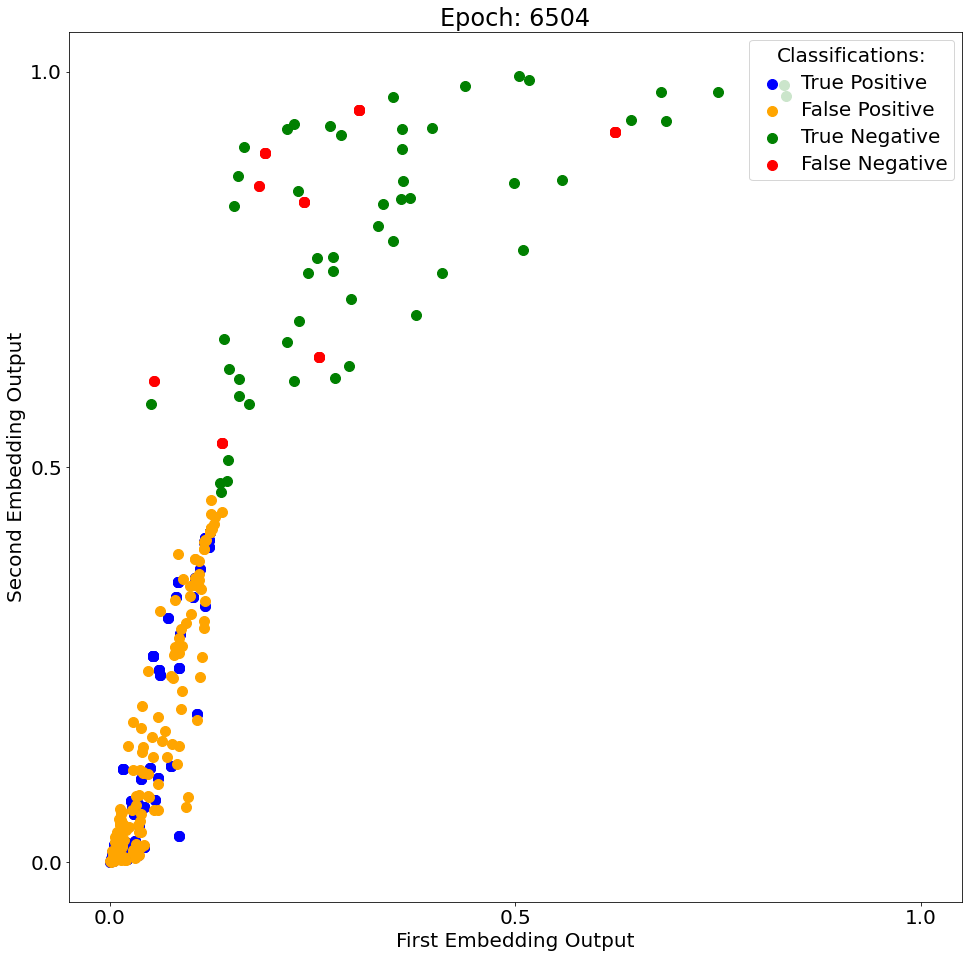

Epoch: 6504  Accuracy: 0.626016  FP: 148  TP: 256  TPR: 0.876712  TNR: 0.260000


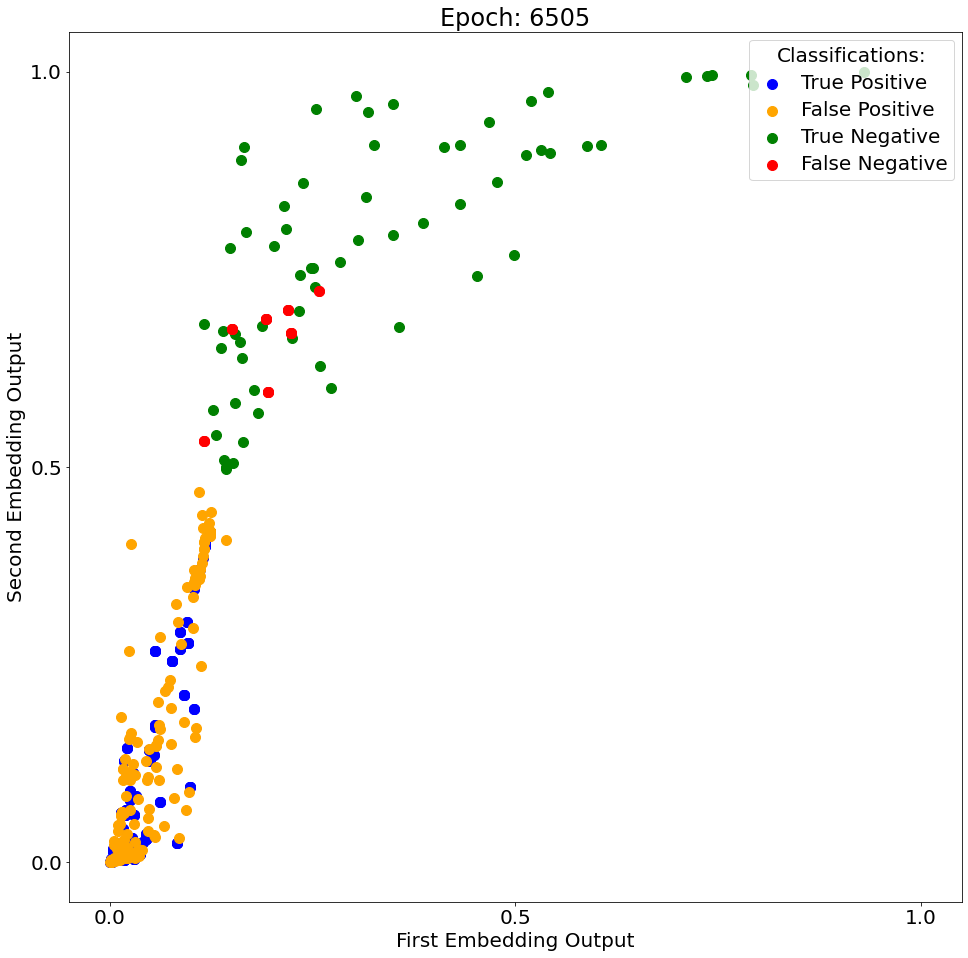

Epoch: 6505  Accuracy: 0.647295  FP: 150  TP: 259  TPR: 0.908772  TNR: 0.299065


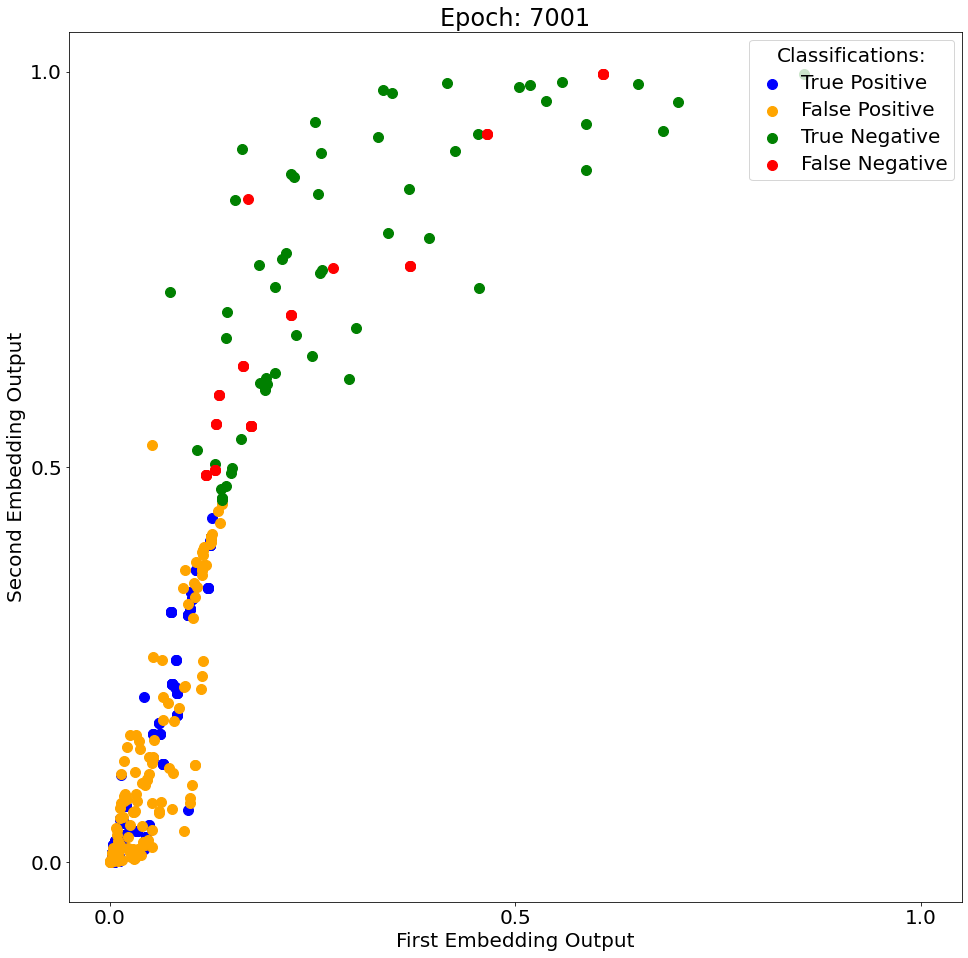

Epoch: 7001  Accuracy: 0.634146  FP: 140  TP: 255  TPR: 0.864407  TNR: 0.289340


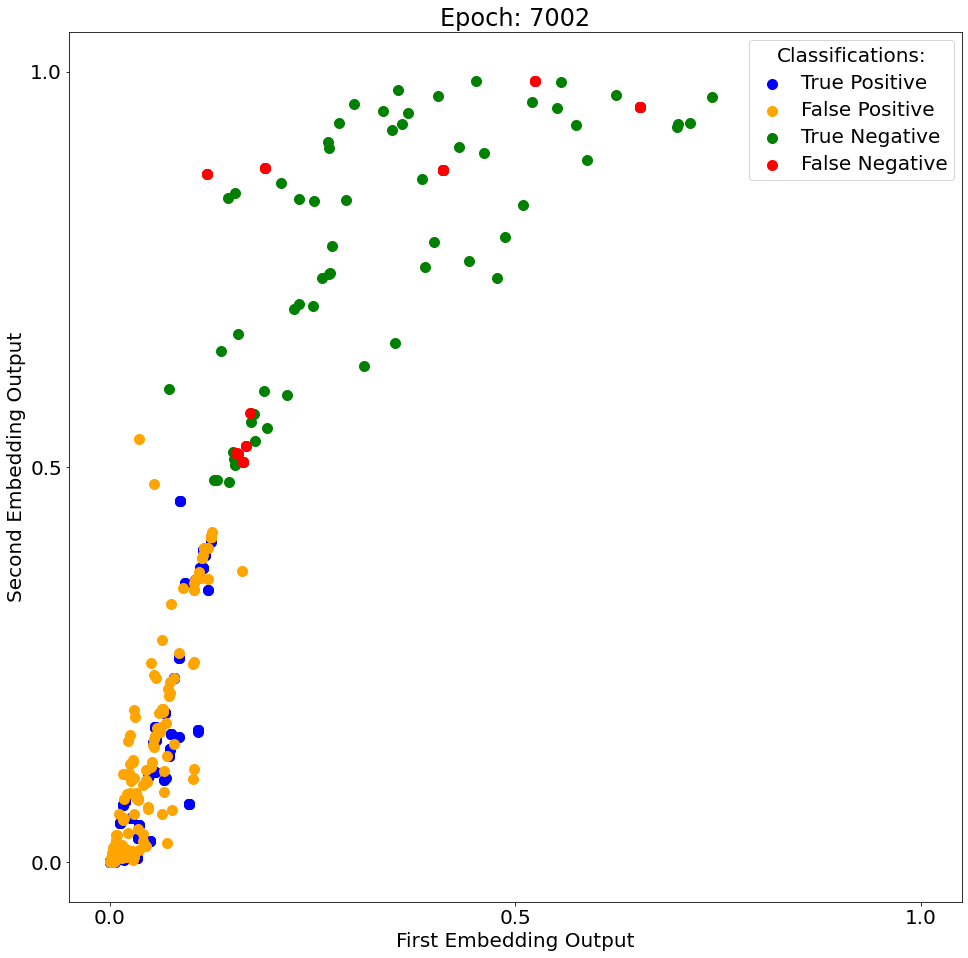

Epoch: 7002  Accuracy: 0.609218  FP: 149  TP: 243  TPR: 0.840830  TNR: 0.290476


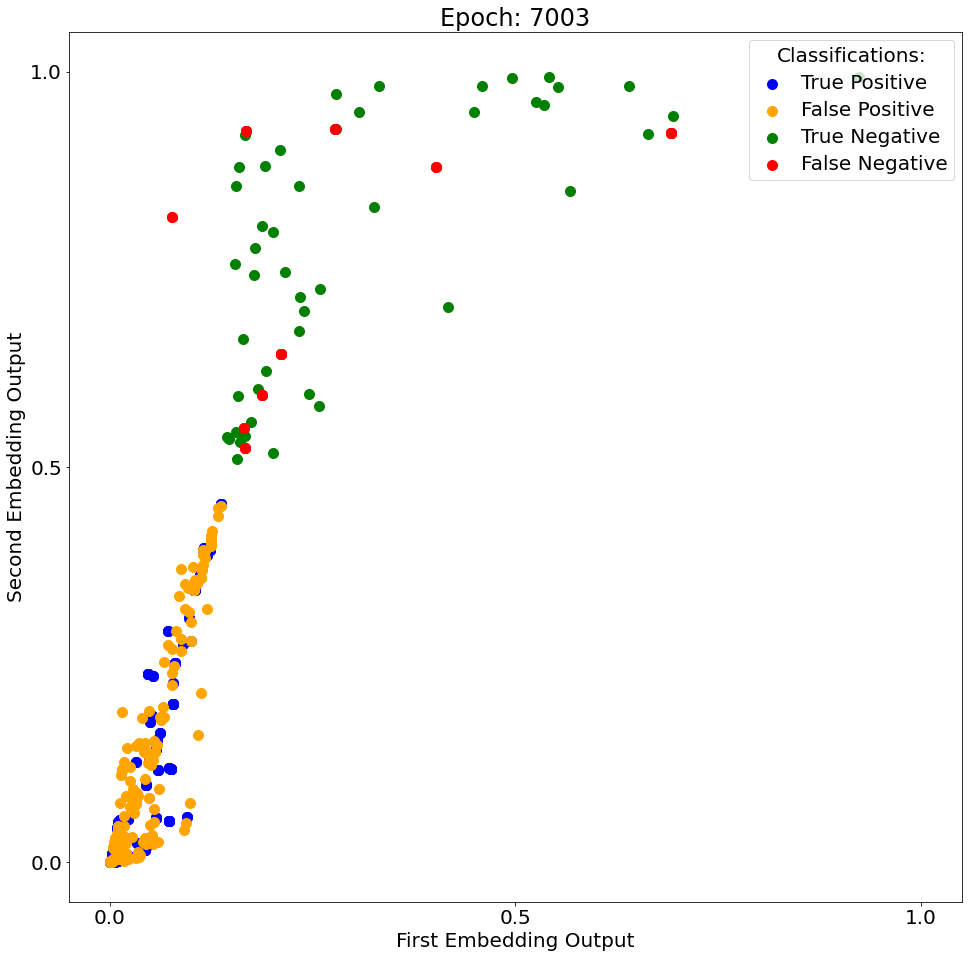

Epoch: 7003  Accuracy: 0.599617  FP: 176  TP: 264  TPR: 0.888889  TNR: 0.217778


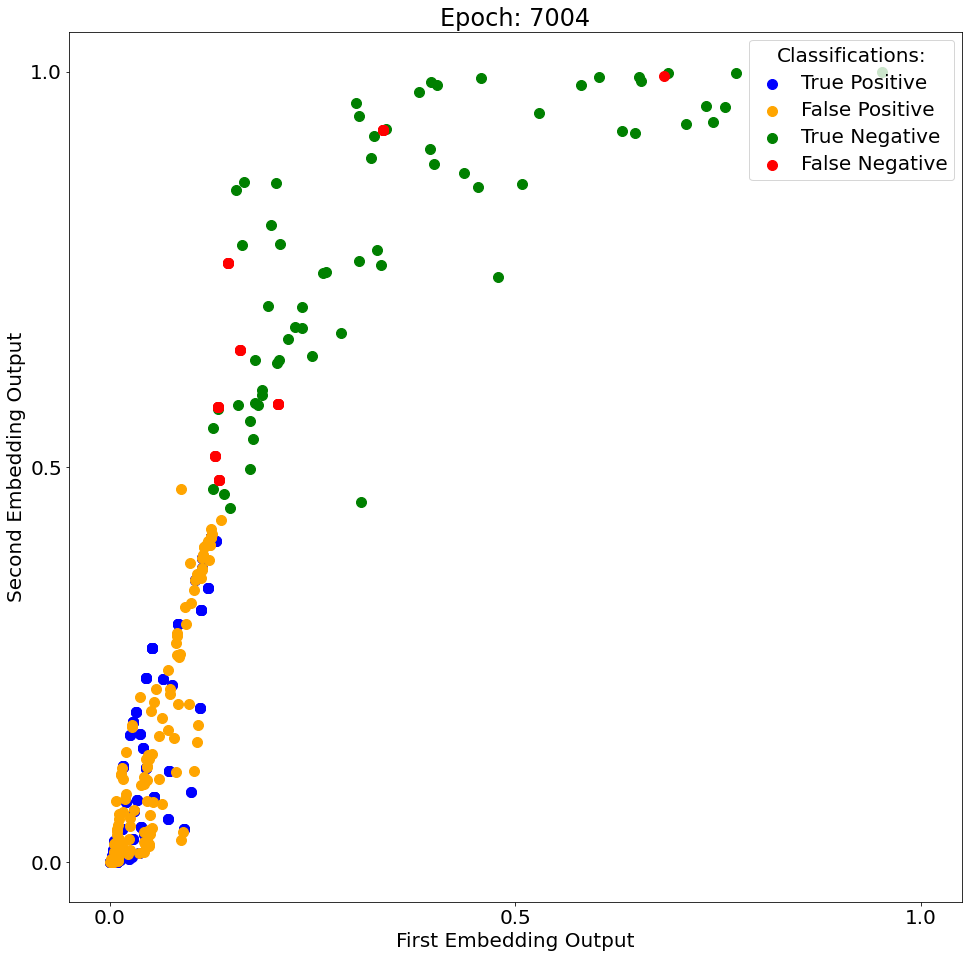

Epoch: 7004  Accuracy: 0.644309  FP: 136  TP: 253  TPR: 0.866438  TNR: 0.320000


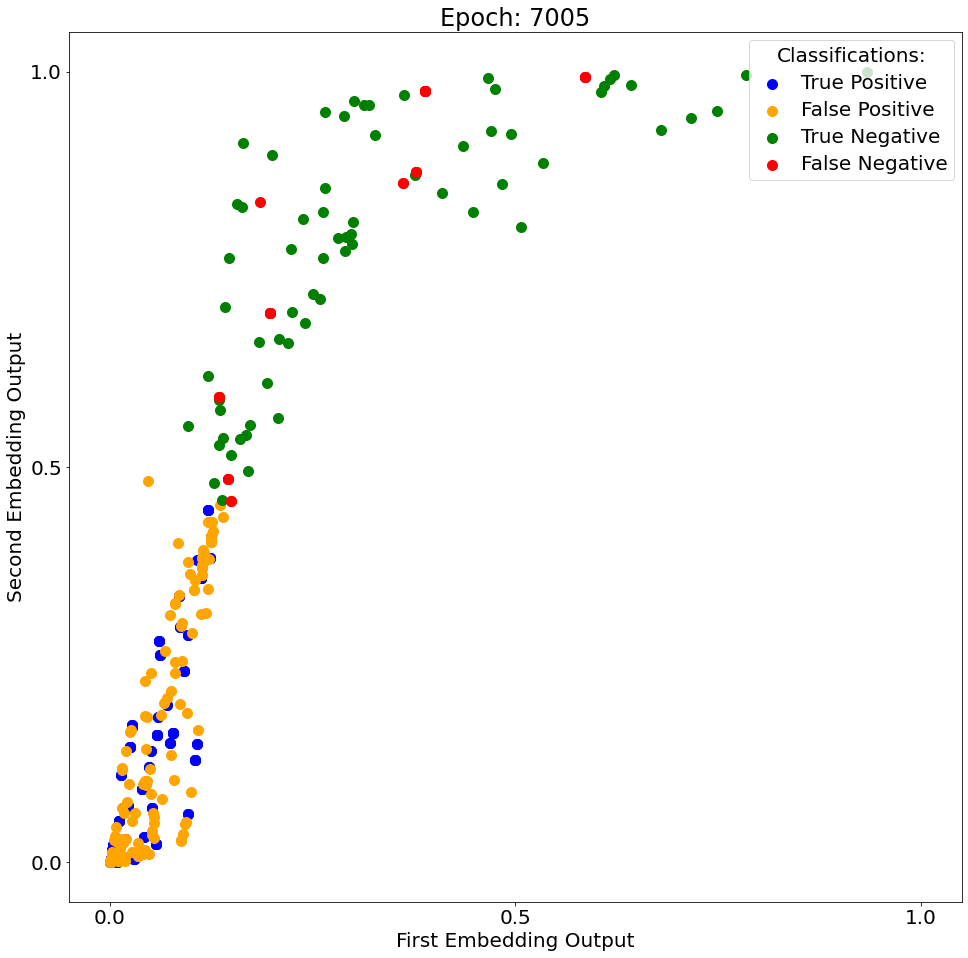

Epoch: 7005  Accuracy: 0.639279  FP: 147  TP: 252  TPR: 0.884211  TNR: 0.313084


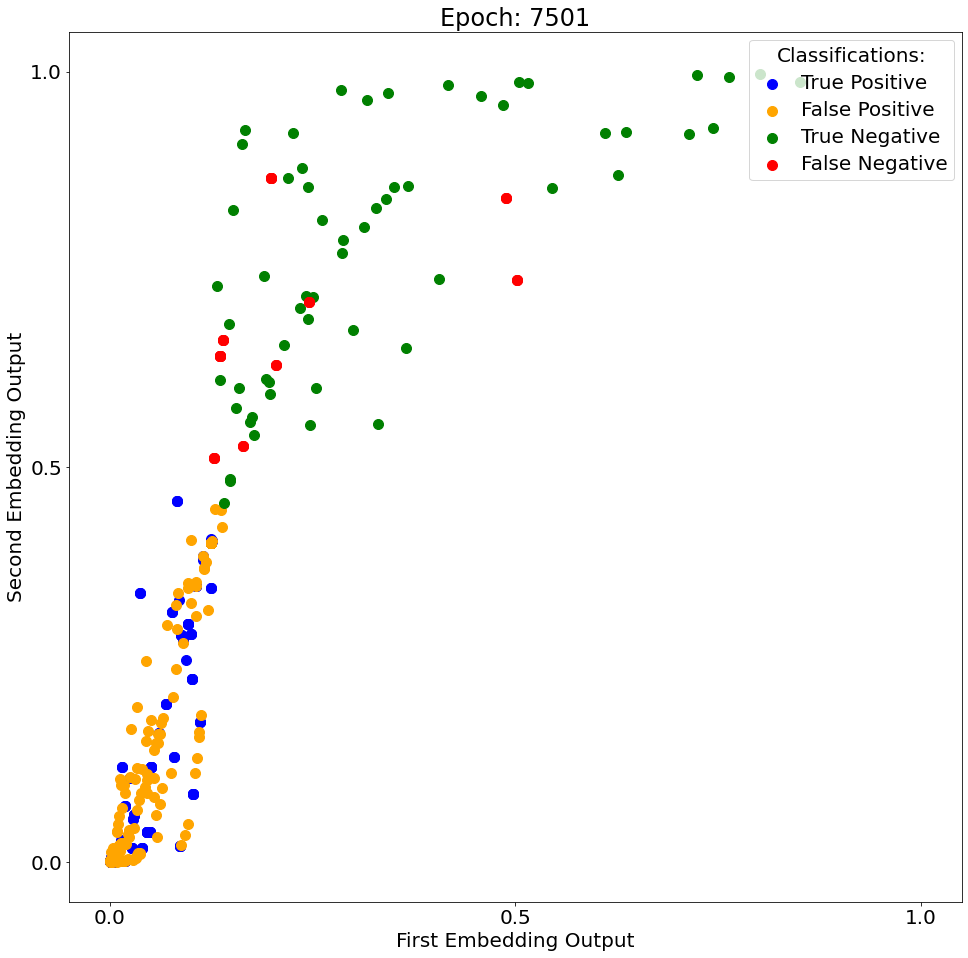

Epoch: 7501  Accuracy: 0.644309  FP: 138  TP: 258  TPR: 0.874576  TNR: 0.299492


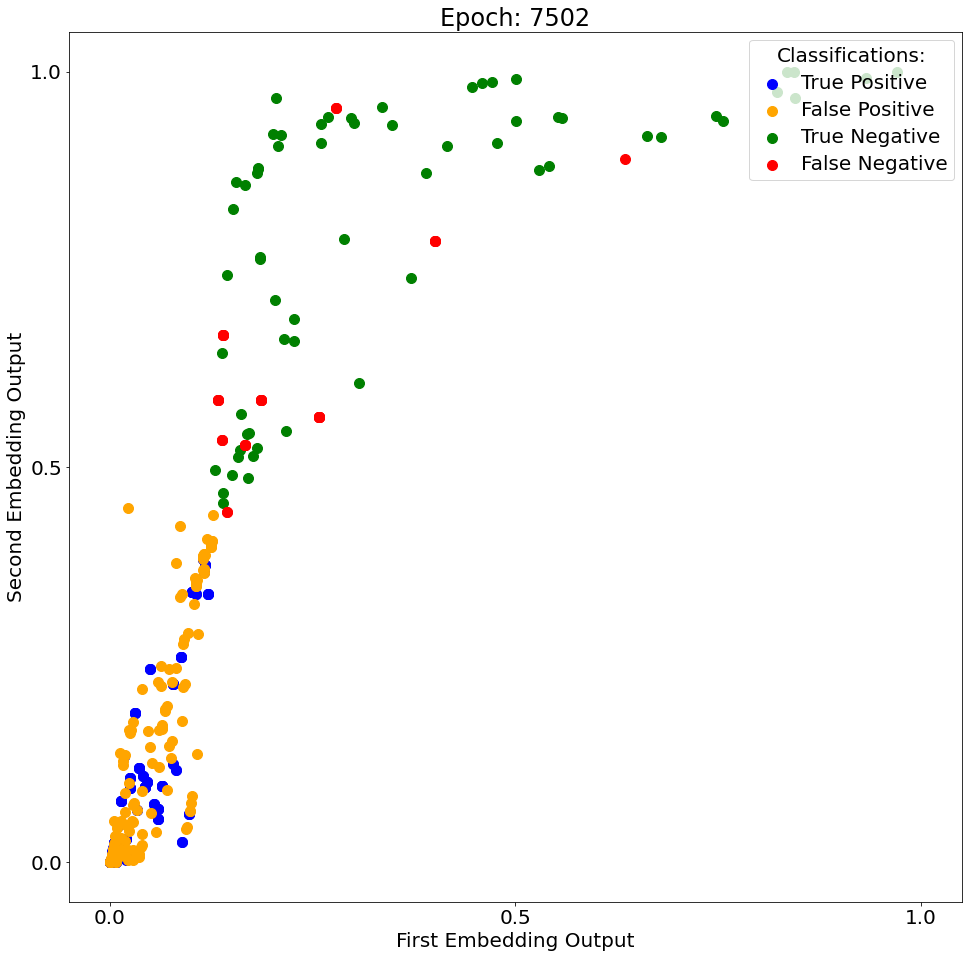

Epoch: 7502  Accuracy: 0.619238  FP: 147  TP: 246  TPR: 0.851211  TNR: 0.300000


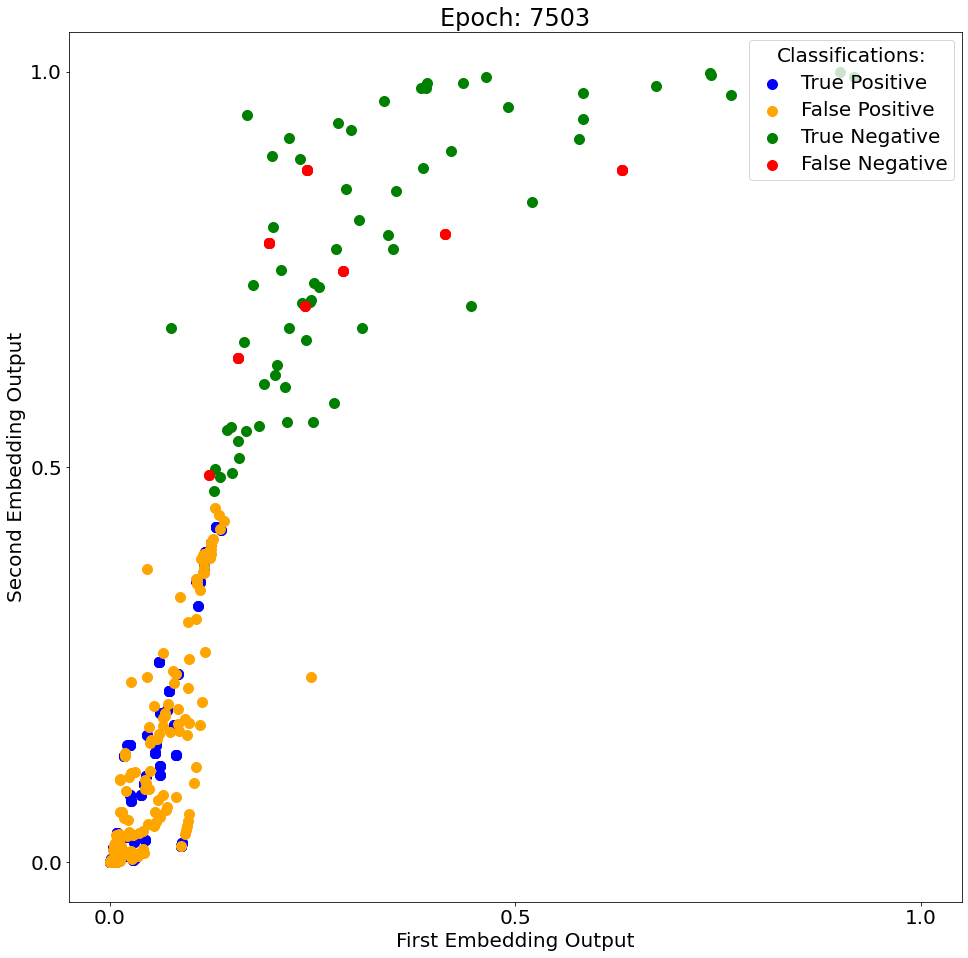

Epoch: 7503  Accuracy: 0.630268  FP: 163  TP: 267  TPR: 0.898990  TNR: 0.275556


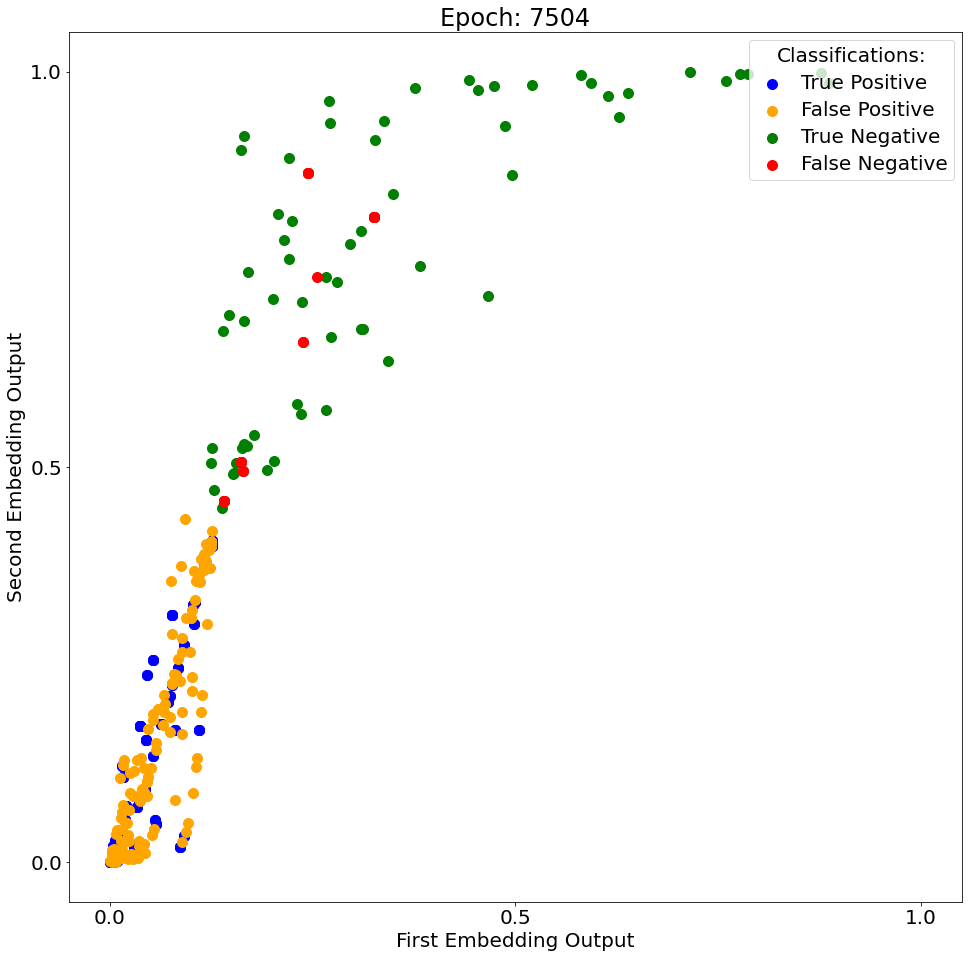

Epoch: 7504  Accuracy: 0.660569  FP: 138  TP: 263  TPR: 0.900685  TNR: 0.310000


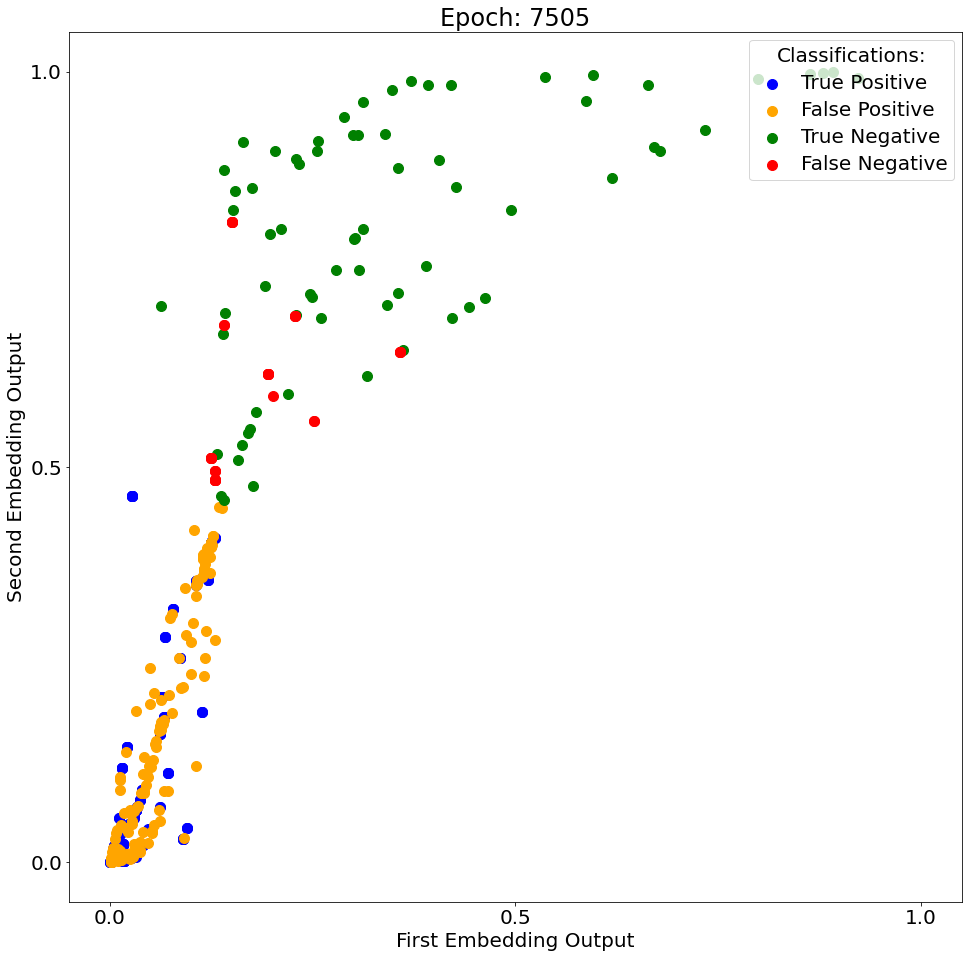

Epoch: 7505  Accuracy: 0.625251  FP: 145  TP: 243  TPR: 0.852632  TNR: 0.322430


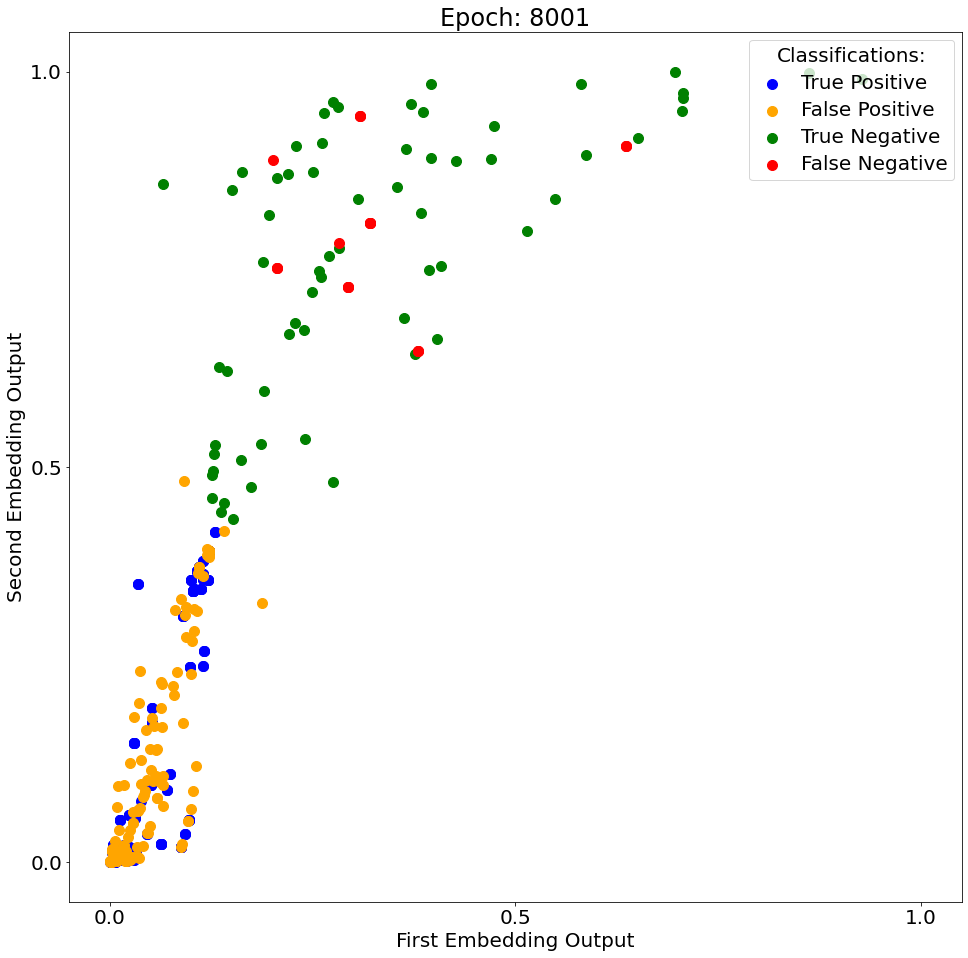

Epoch: 8001  Accuracy: 0.682927  FP: 133  TP: 272  TPR: 0.922034  TNR: 0.324873


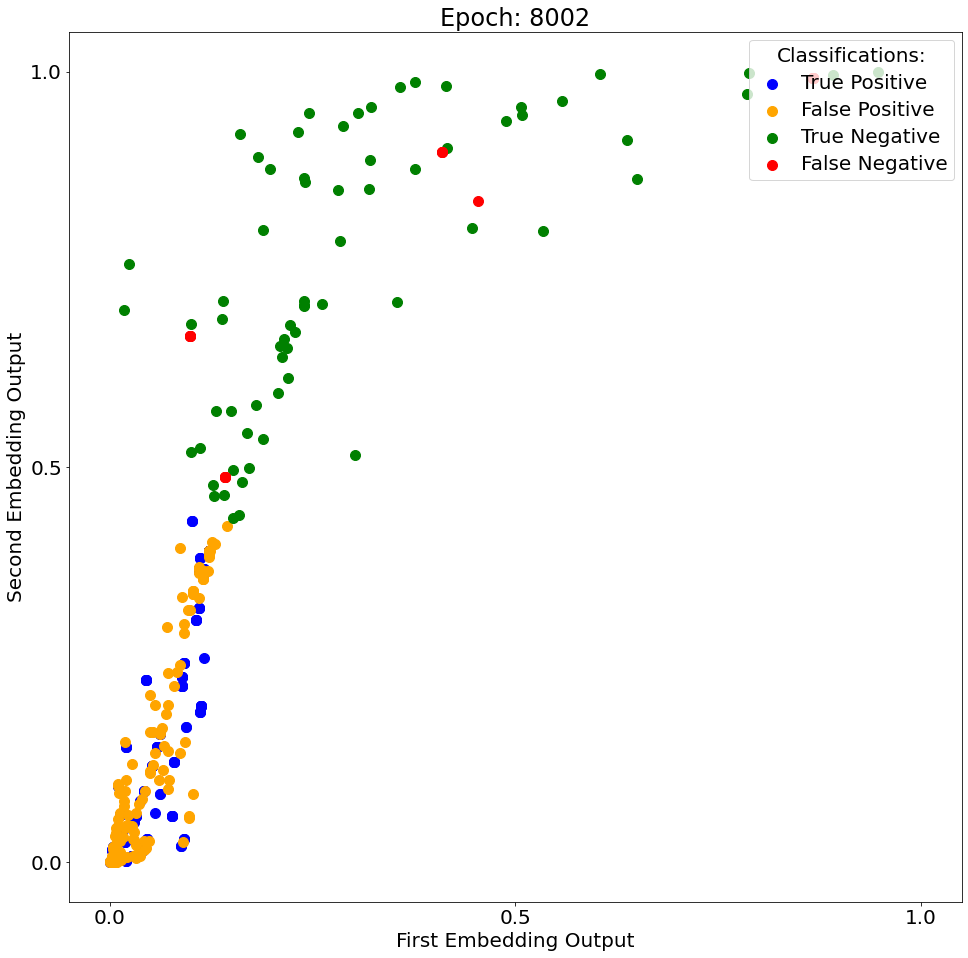

Epoch: 8002  Accuracy: 0.671343  FP: 143  TP: 268  TPR: 0.927336  TNR: 0.319048


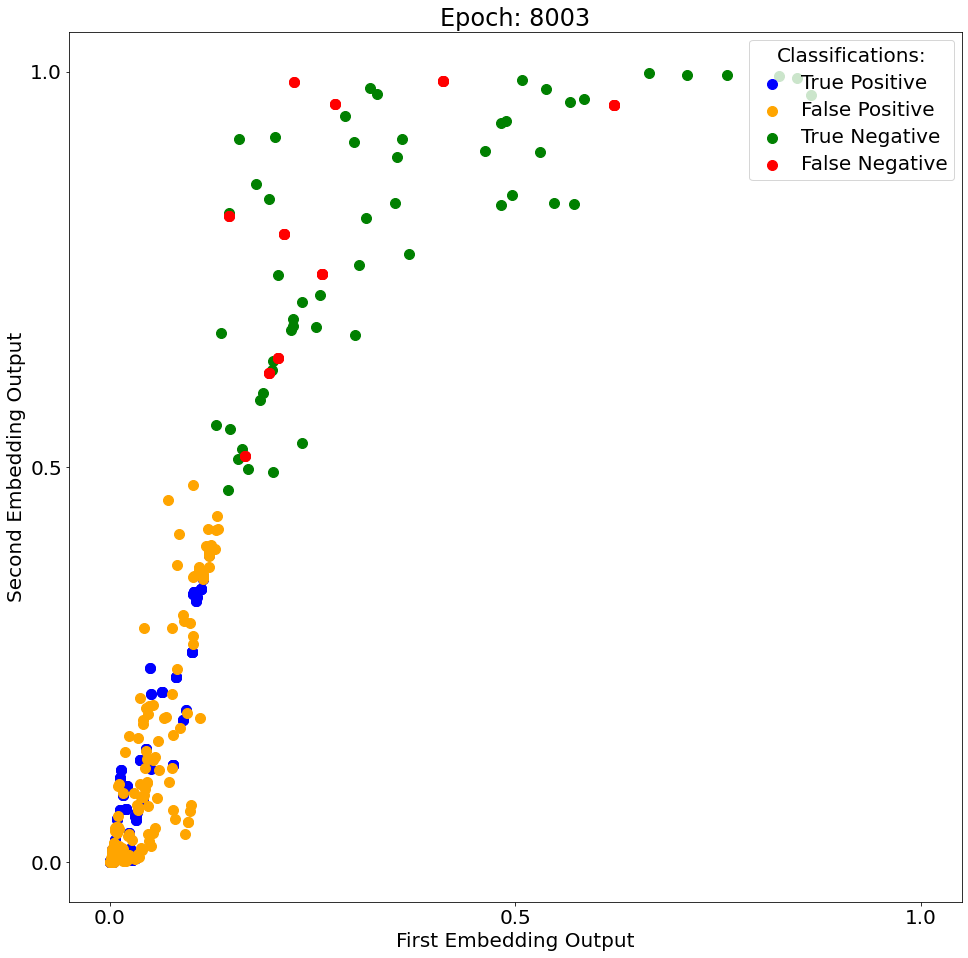

Epoch: 8003  Accuracy: 0.601533  FP: 171  TP: 260  TPR: 0.875421  TNR: 0.240000


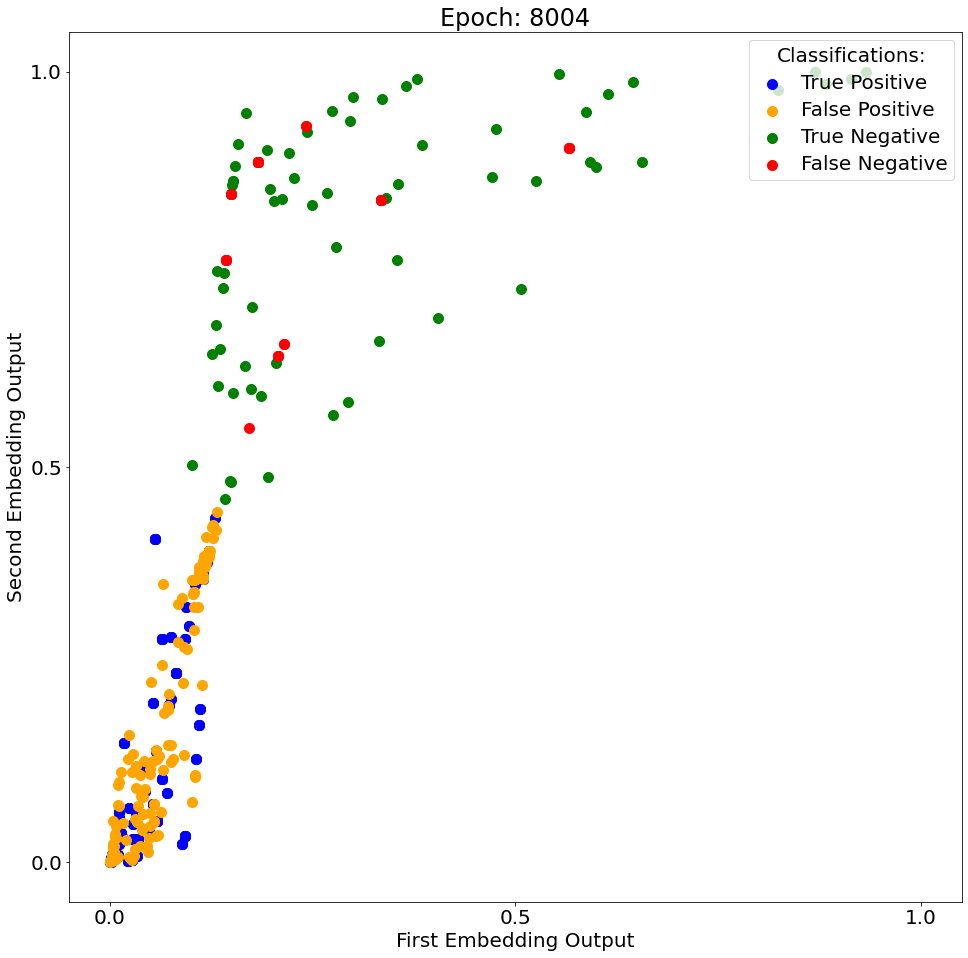

Epoch: 8004  Accuracy: 0.648374  FP: 136  TP: 255  TPR: 0.873288  TNR: 0.320000


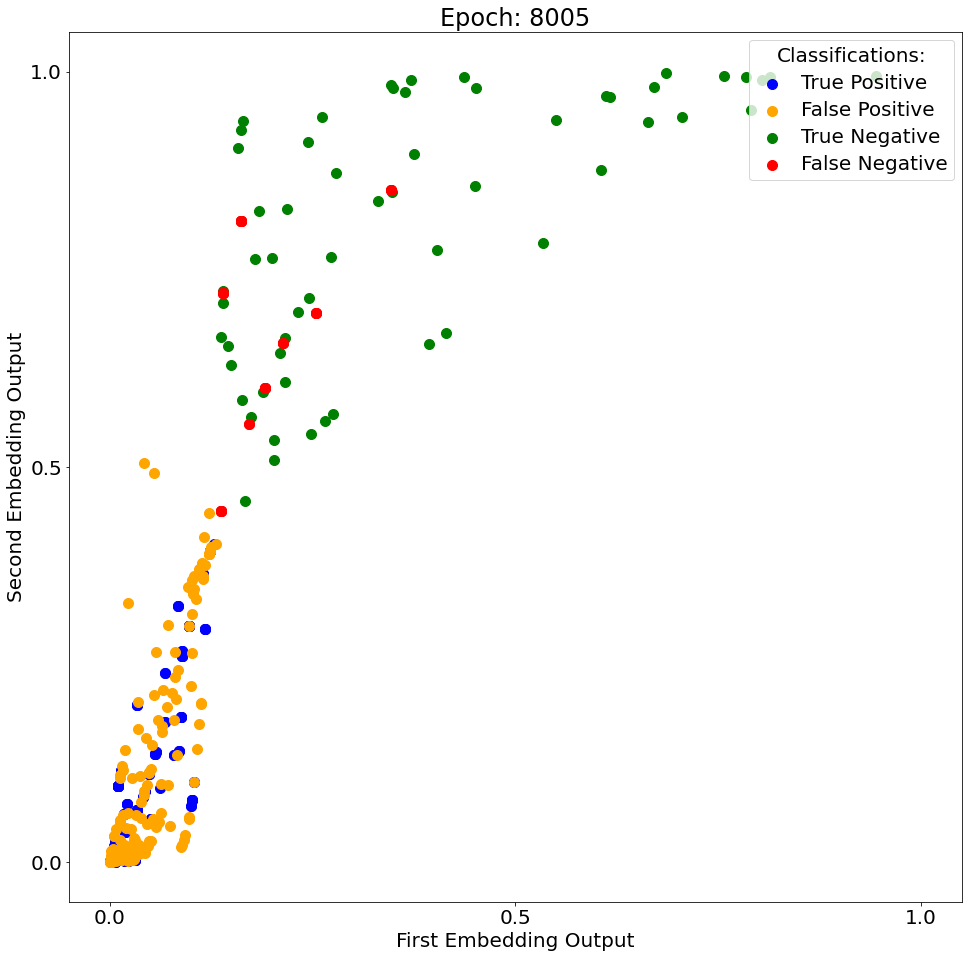

Epoch: 8005  Accuracy: 0.607214  FP: 156  TP: 245  TPR: 0.859649  TNR: 0.271028


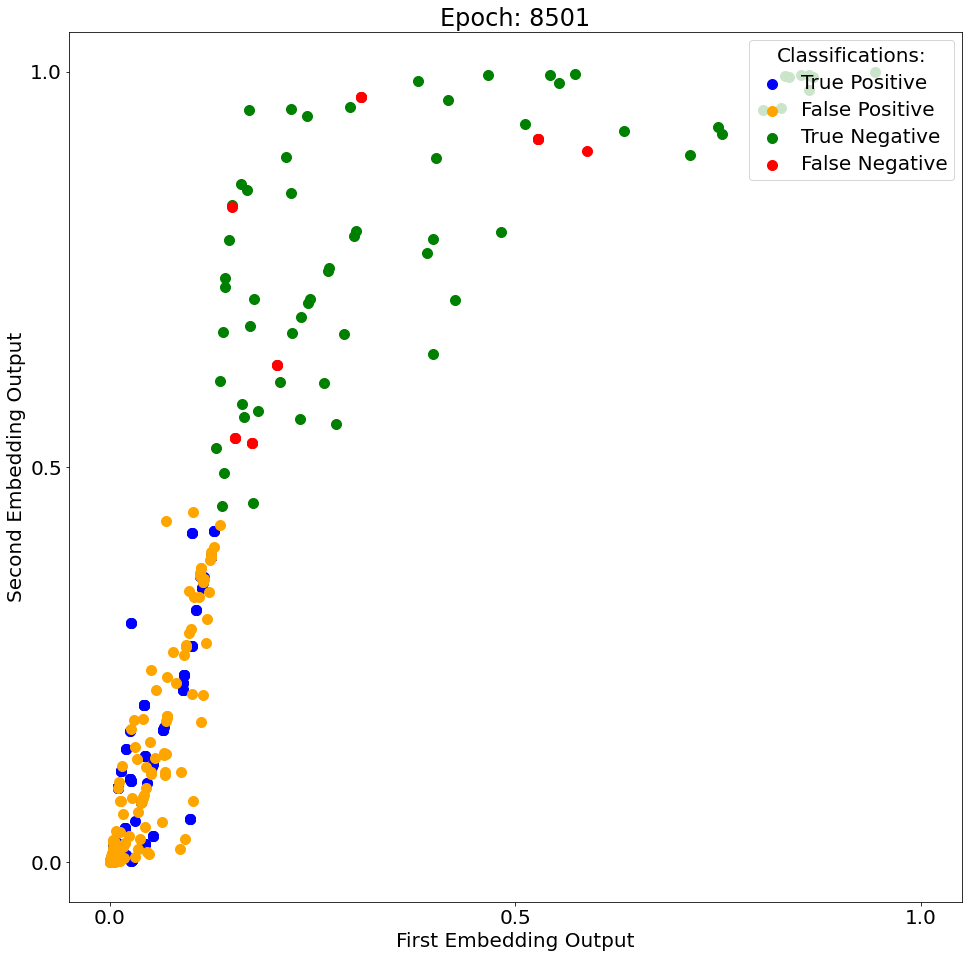

Epoch: 8501  Accuracy: 0.689024  FP: 135  TP: 277  TPR: 0.938983  TNR: 0.314721


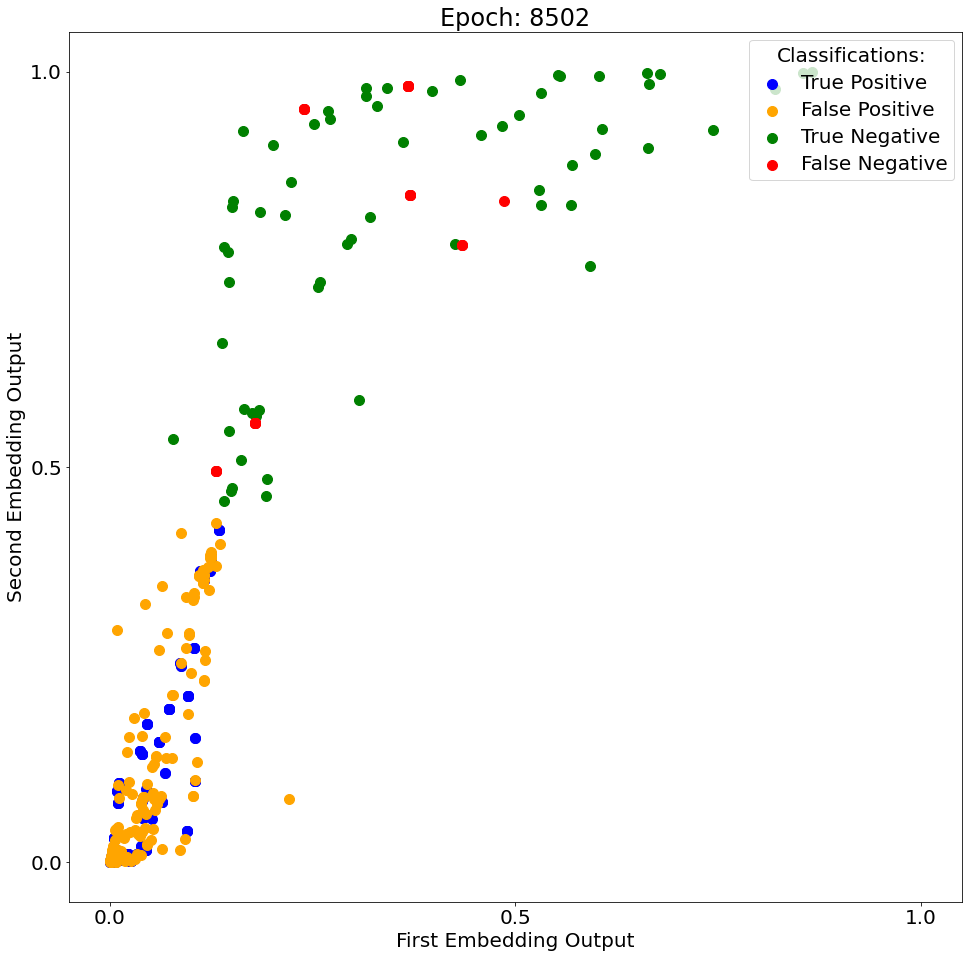

Epoch: 8502  Accuracy: 0.637275  FP: 148  TP: 256  TPR: 0.885813  TNR: 0.295238


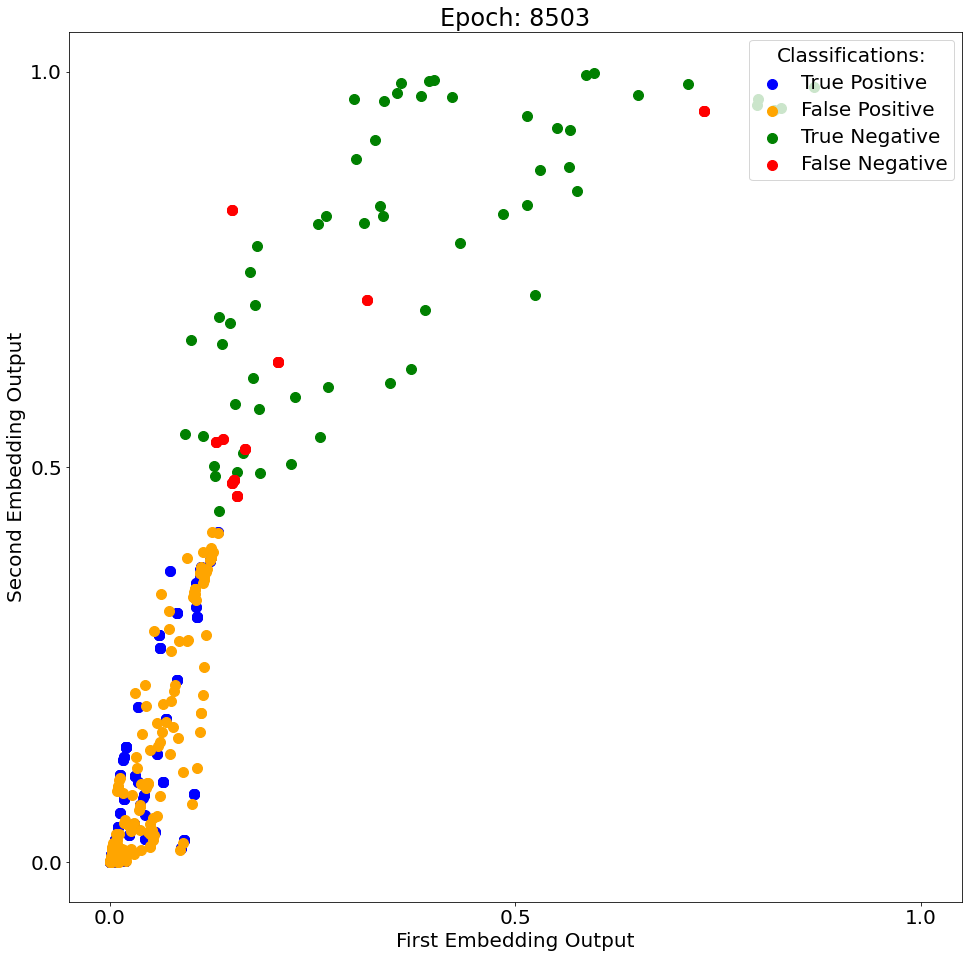

Epoch: 8503  Accuracy: 0.605364  FP: 166  TP: 257  TPR: 0.865320  TNR: 0.262222


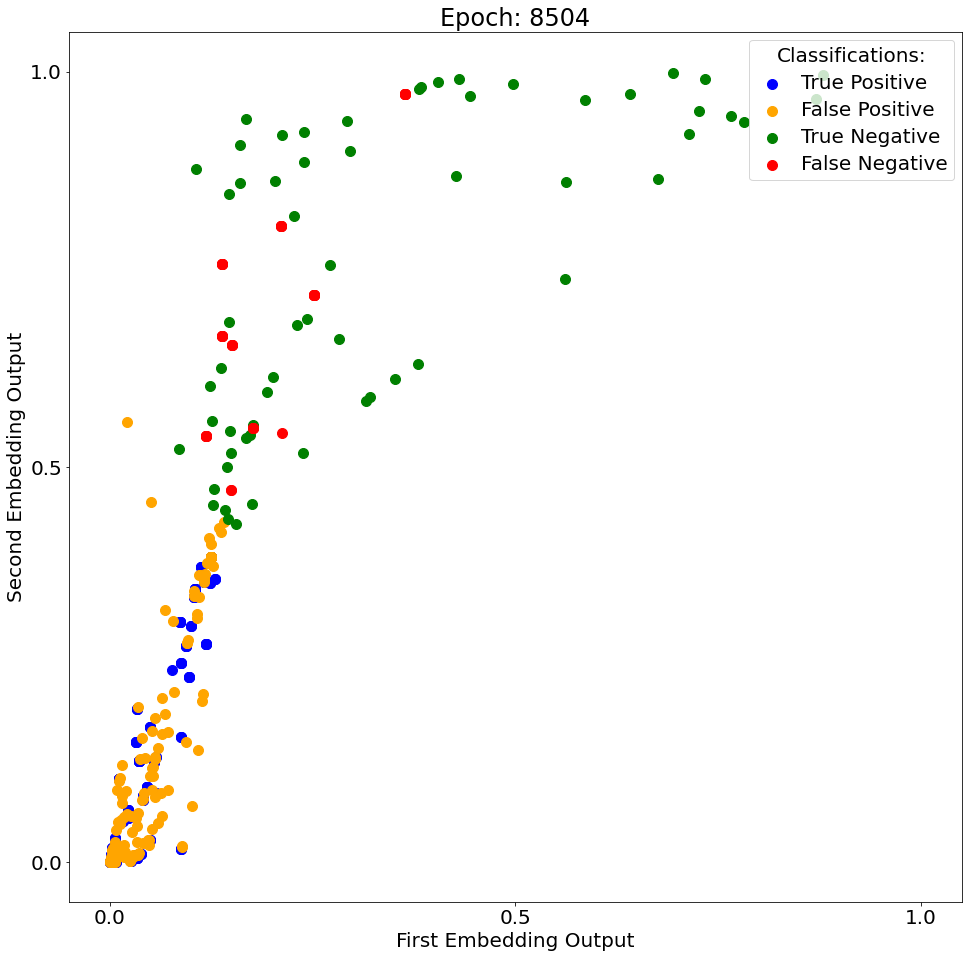

Epoch: 8504  Accuracy: 0.621951  FP: 140  TP: 246  TPR: 0.842466  TNR: 0.300000


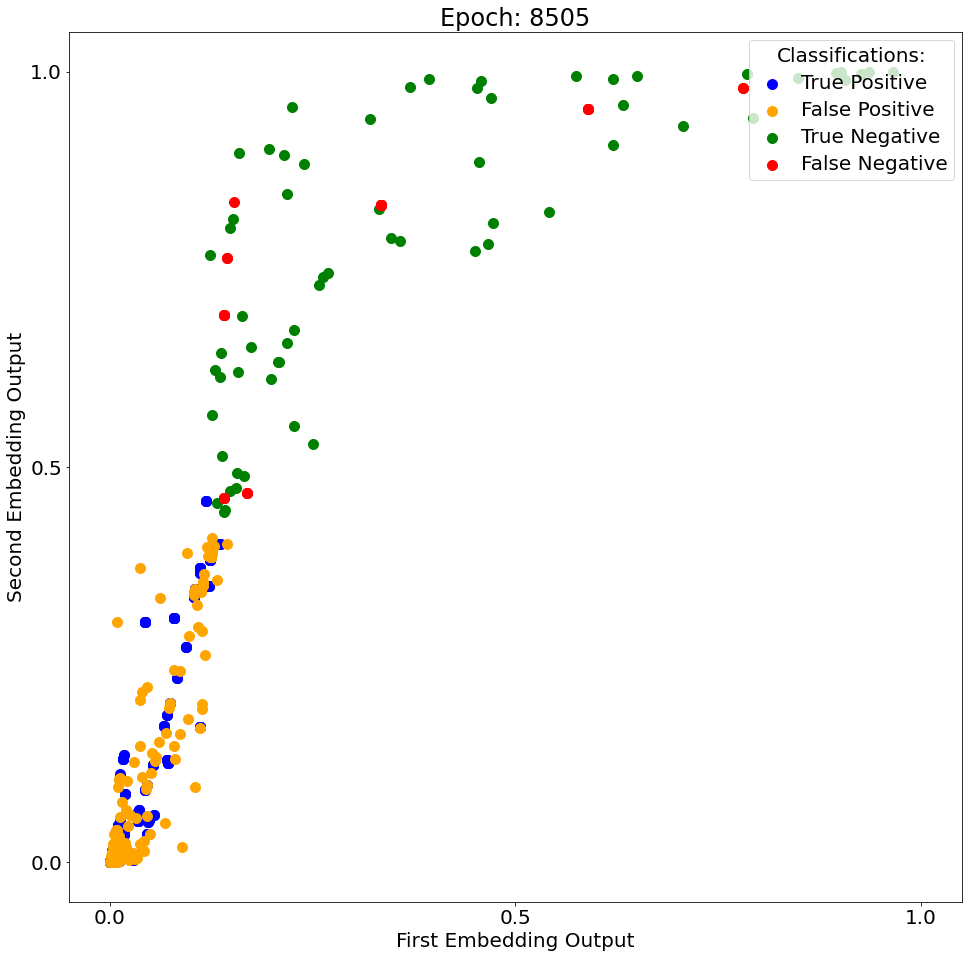

Epoch: 8505  Accuracy: 0.643287  FP: 151  TP: 258  TPR: 0.905263  TNR: 0.294393


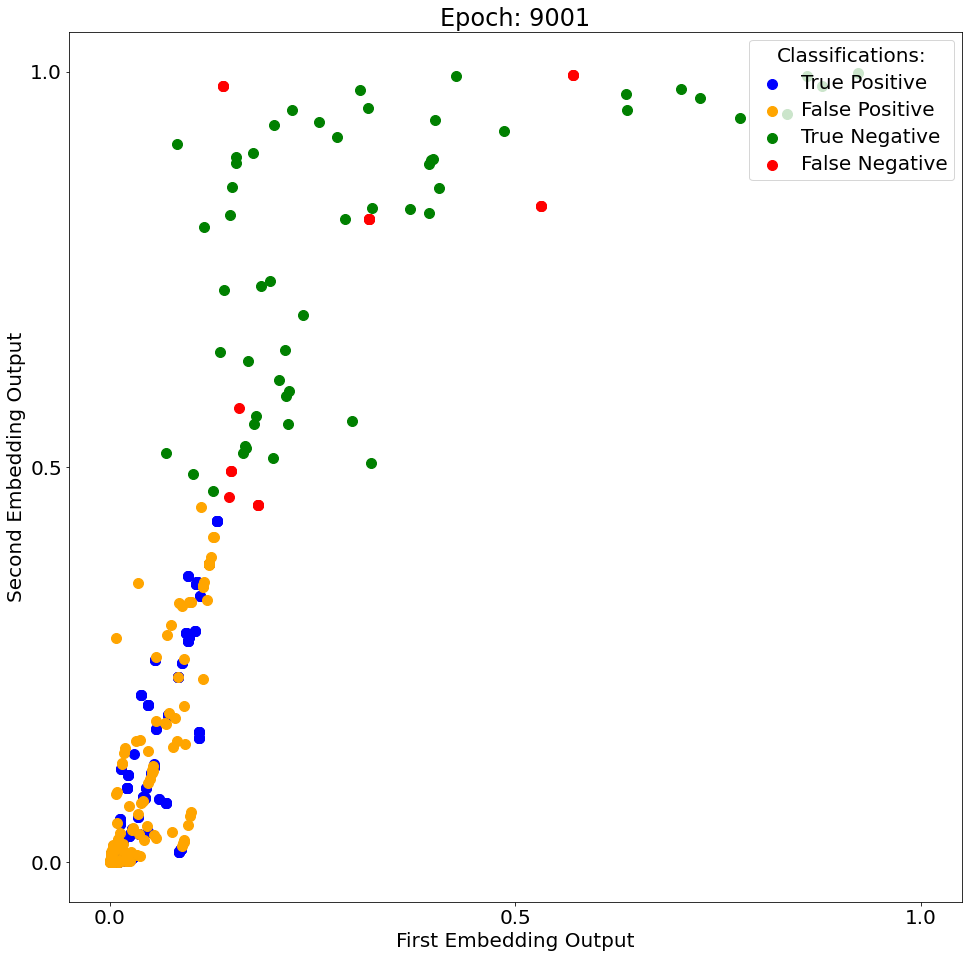

Epoch: 9001  Accuracy: 0.664634  FP: 142  TP: 272  TPR: 0.922034  TNR: 0.279188


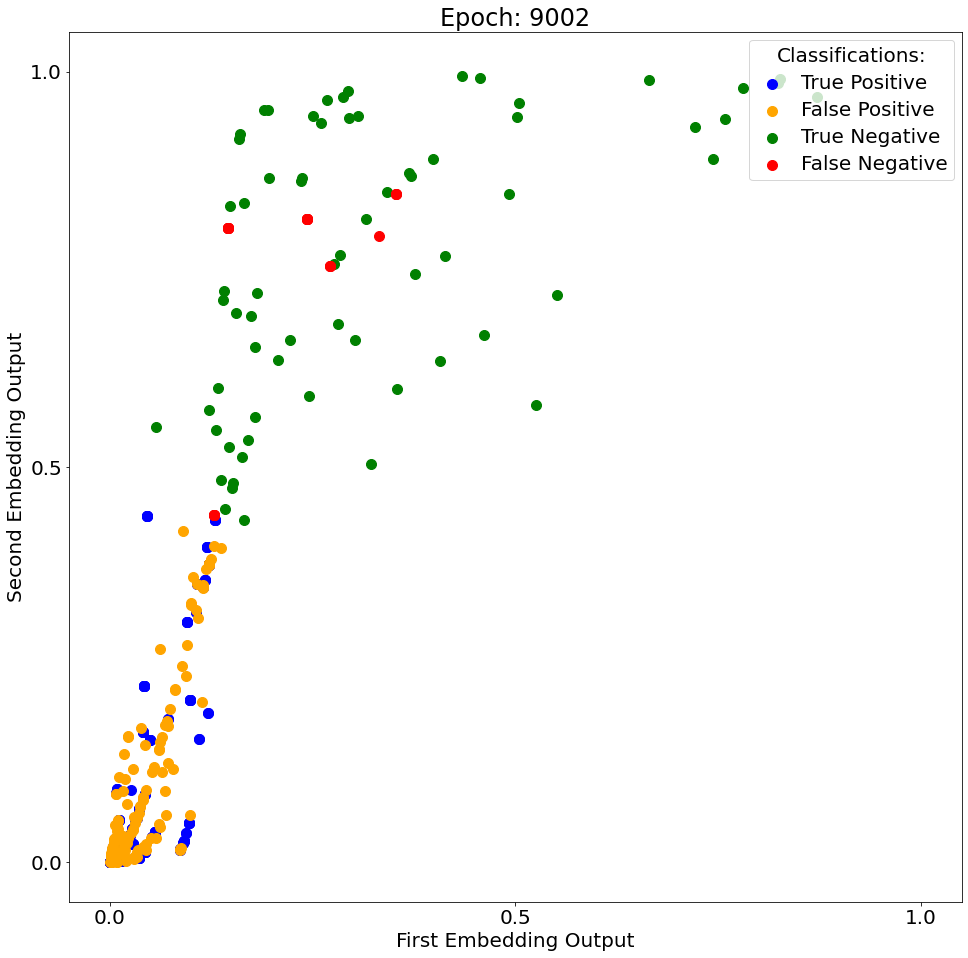

Epoch: 9002  Accuracy: 0.661323  FP: 142  TP: 262  TPR: 0.906574  TNR: 0.323810


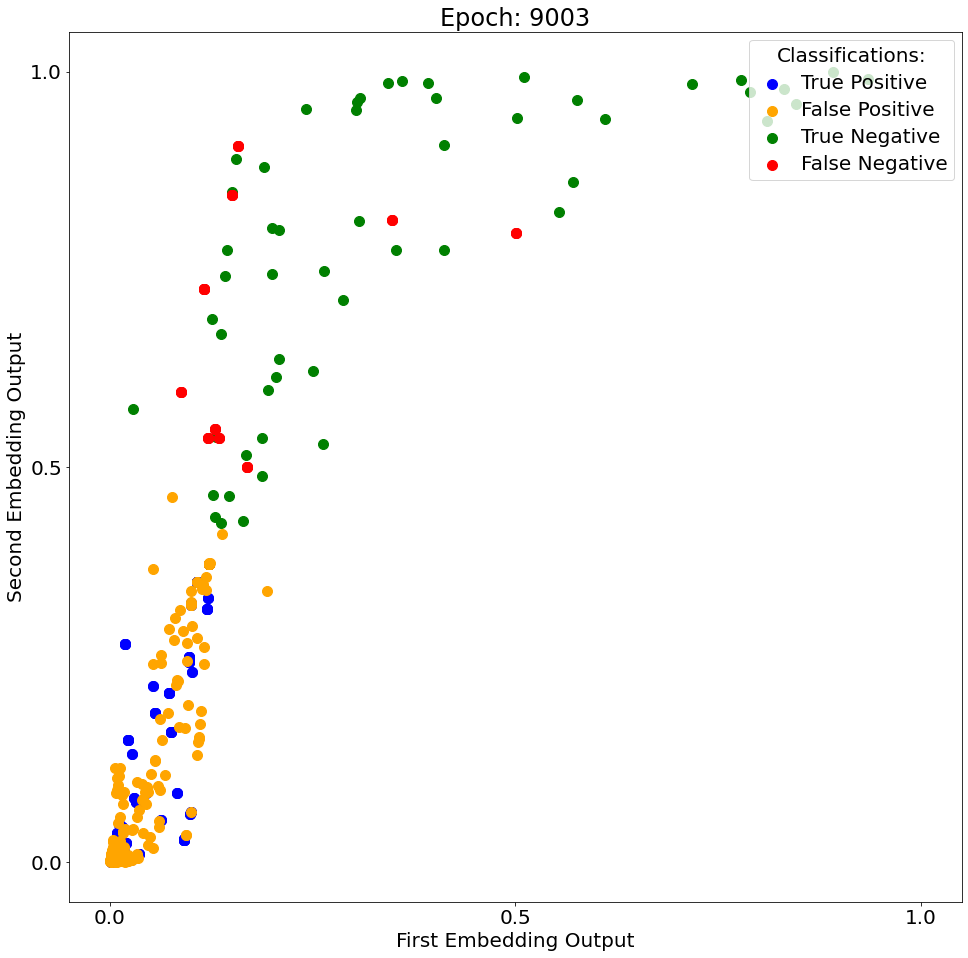

Epoch: 9003  Accuracy: 0.593870  FP: 172  TP: 257  TPR: 0.865320  TNR: 0.235556


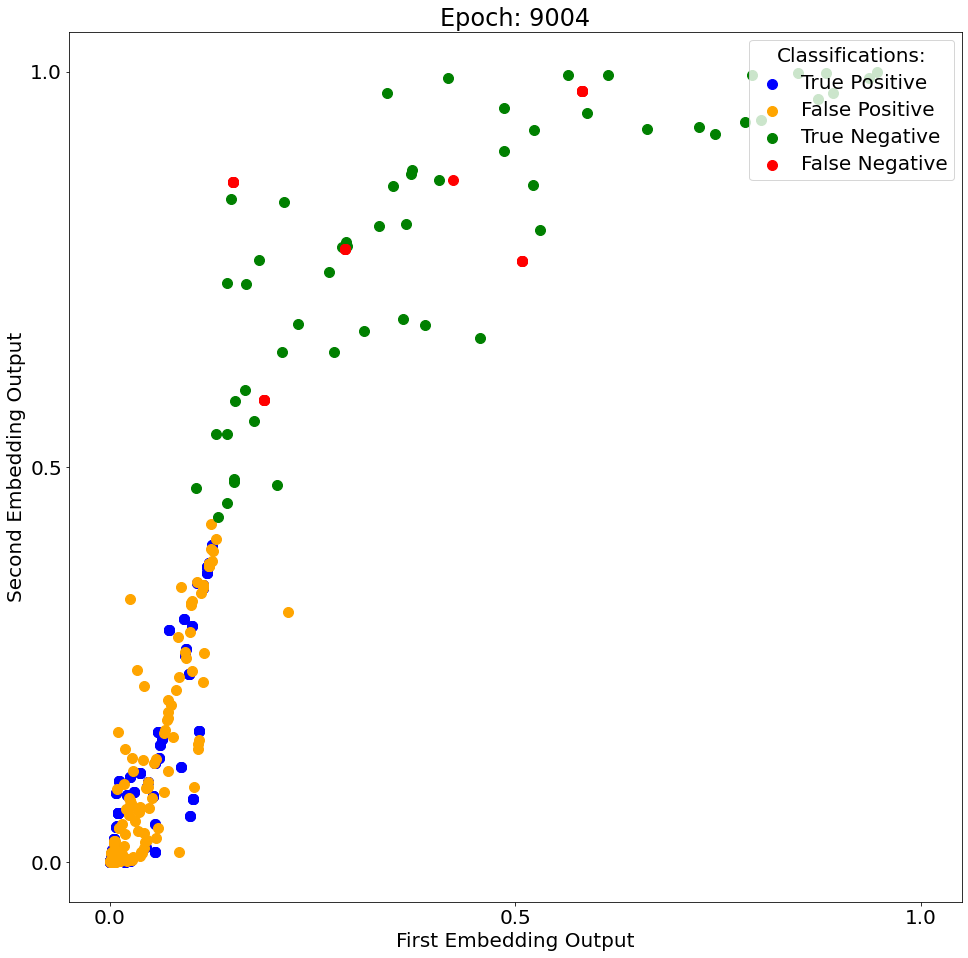

Epoch: 9004  Accuracy: 0.650406  FP: 145  TP: 265  TPR: 0.907534  TNR: 0.275000


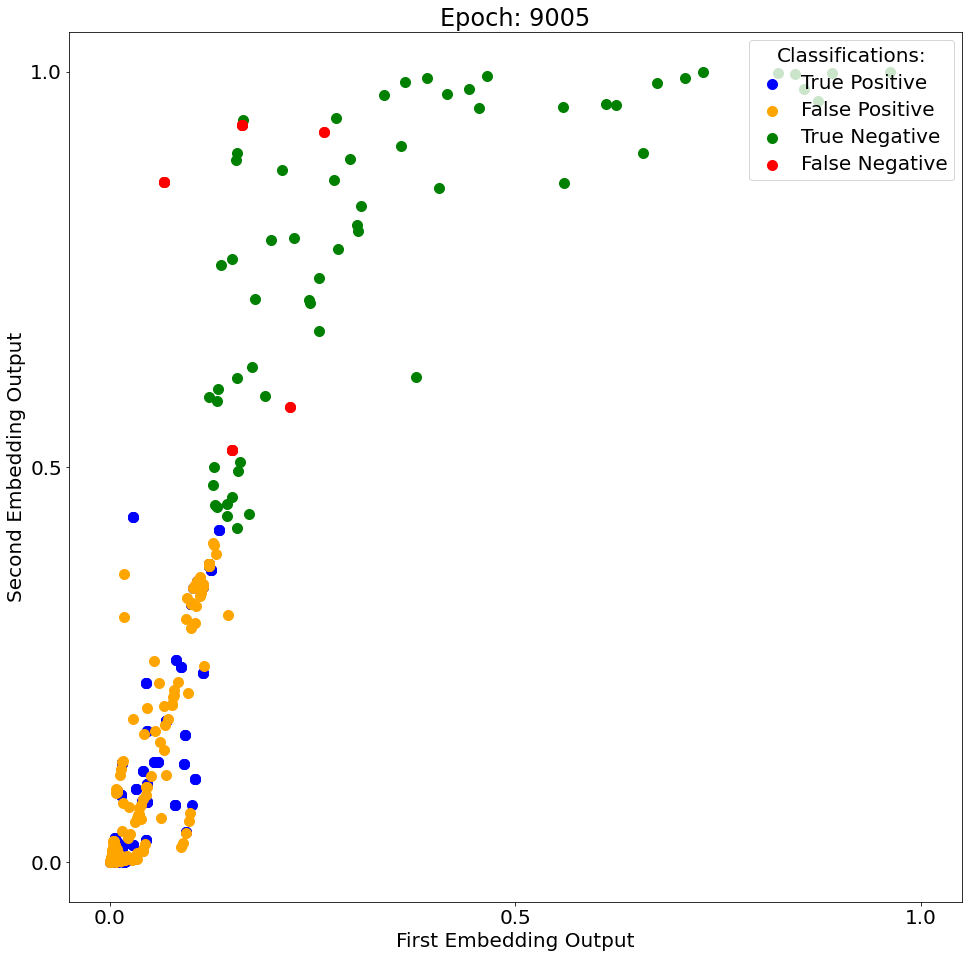

Epoch: 9005  Accuracy: 0.659319  FP: 153  TP: 268  TPR: 0.940351  TNR: 0.285047


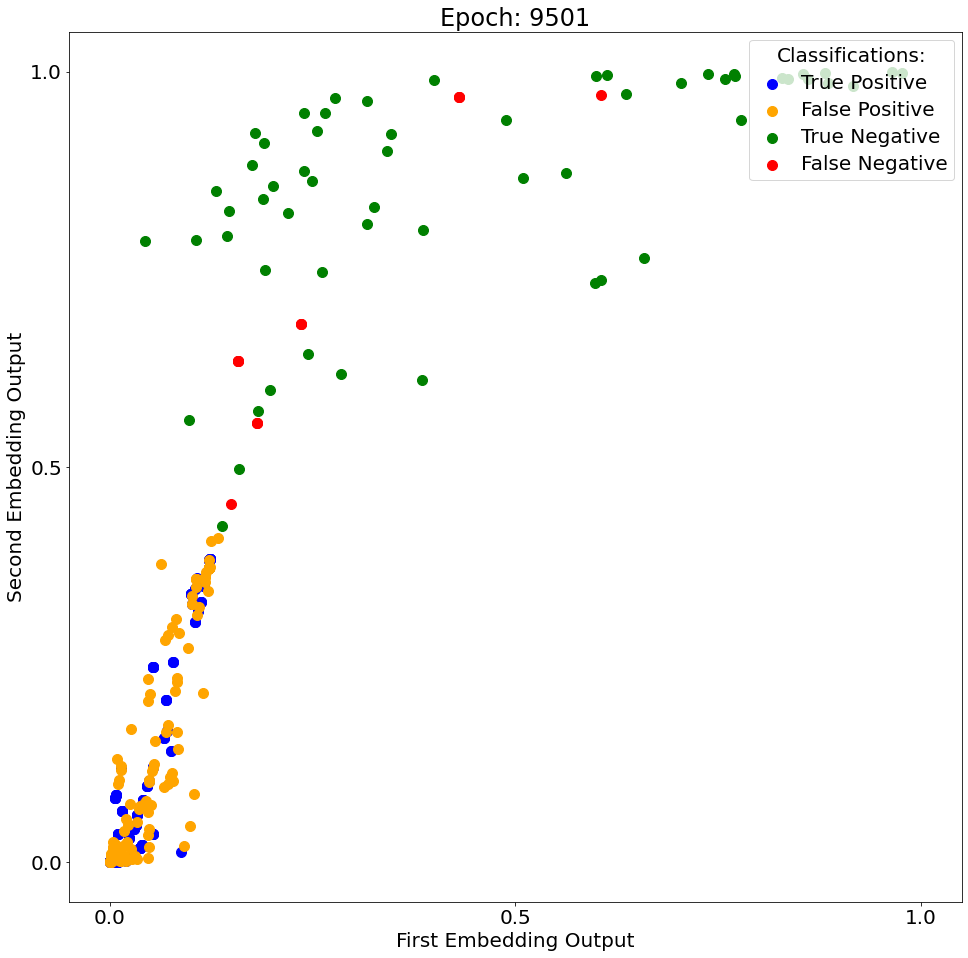

Epoch: 9501  Accuracy: 0.686992  FP: 139  TP: 280  TPR: 0.949153  TNR: 0.294416


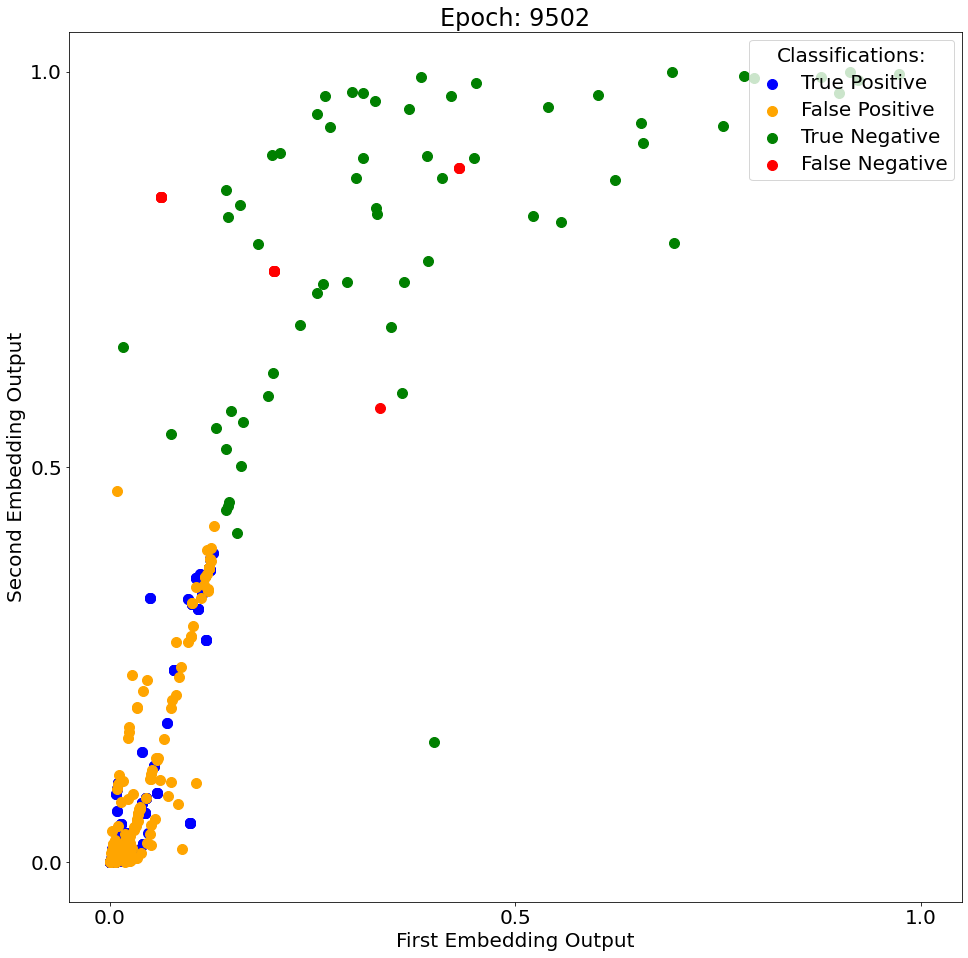

Epoch: 9502  Accuracy: 0.665331  FP: 148  TP: 270  TPR: 0.934256  TNR: 0.295238


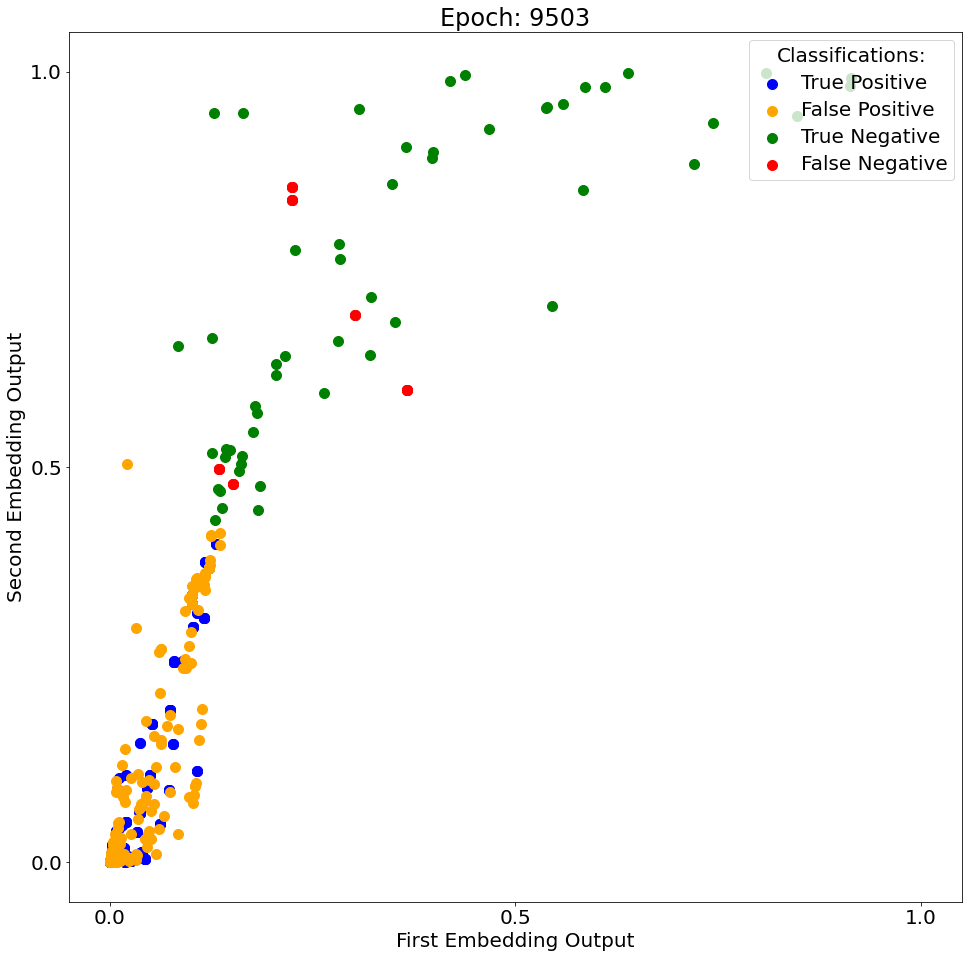

Epoch: 9503  Accuracy: 0.626437  FP: 172  TP: 274  TPR: 0.922559  TNR: 0.235556


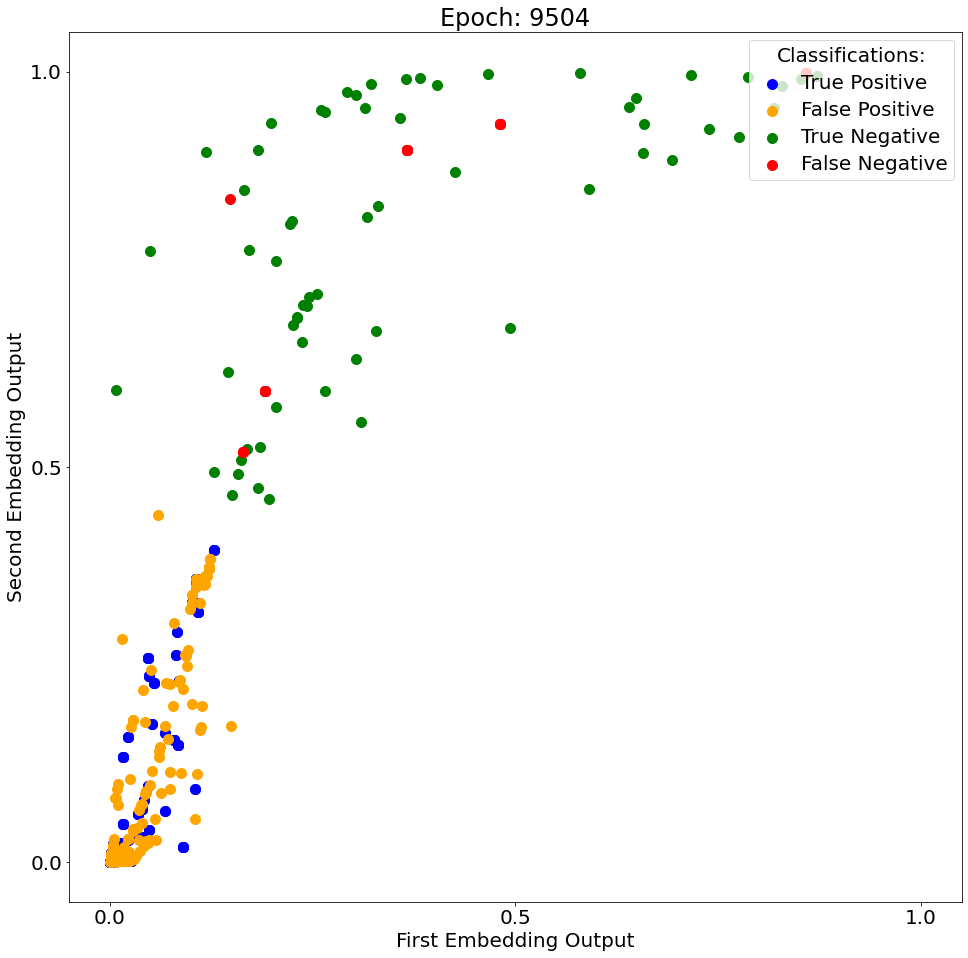

Epoch: 9504  Accuracy: 0.660569  FP: 138  TP: 263  TPR: 0.900685  TNR: 0.310000


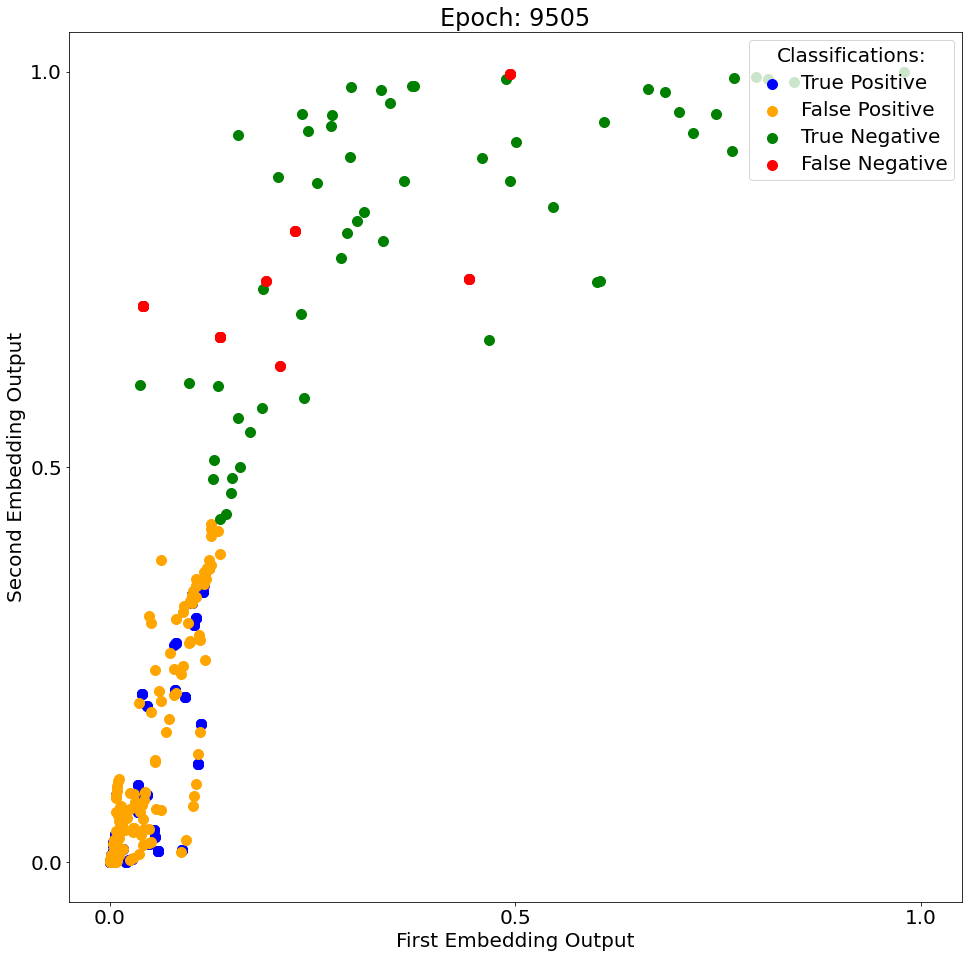

Epoch: 9505  Accuracy: 0.621242  FP: 159  TP: 255  TPR: 0.894737  TNR: 0.257009


In [13]:
count=0

#loops for all nodes
for j in range(0,int(len(embeddings)/5)):
    for train_index, test_index in sss.split(X_train,Y_train):
        #creates new test index and colour list
        test_index = X_train.iloc[test_index]
        colours=[]
        #loops for each nodes label 
        for i in range(0,len(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])):
            temp = Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]][i]
            
            #checks if true/false positive/negative and labels colour appropriately
            try:
                if temp[outs[count][i]==1]==1:
                    colours.append(0)
            except:
                pass
            try:
                if temp[outs[count][i]==1]==0:
                    colours.append(1)
            except:
                pass
            try:
                if temp[outs[count][i]==0]==0:
                    colours.append(2)
            except:
                pass
            try:
                if temp[outs[count][i]==0]==1:
                    colours.append(3)
            except:
                pass
        
    
        #checks colours list is correct length
        if len(colours)==len(embeddings[count]):
            #plots using function
            plot_embedding(count,embeddings[count],torch.Tensor(colours),['True Positive','False Positive','True Negative','False Negative'])
            print(f"Epoch: {counts[count]}",
                f" Accuracy: {accs[count]:2f}",
                f" FP: {fps[count]}",
                f" TP: {tps[count]}",
                f" TPR: {tprs[count]:2f}",
                f" TNR: {tnrs[count]:2f}")
        count+=1

Test Classification Results and Plots:

In [14]:
#repeats above for test data
colours=[]
#finds outputs
out, h = model(Dataset[0].x,Dataset[0].edge_index)   
out = (out[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]).max(1)[1]
h = (h[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])
#loops for each nodes label 
for i in range(0,len(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])):
    temp = Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]][i]
    
    #checks if true/false positive/negative and labels colour appropriately
    try:
        if temp[outs[count][i]==1]==1:
            colours.append(0)
    except:
        pass
    try:
        if temp[outs[count][i]==1]==0:
            colours.append(1)
    except:
        pass
    try:
        if temp[outs[count][i]==0]==0:
            colours.append(2)
    except:
        pass
    try:
        if temp[outs[count][i]==0]==1:
            colours.append(3)
    except:
        pass

#checks colours list is correct length
if len(colours)==len(h):
    #plots using function
    plot_embedding('Test Dataset',h,torch.Tensor(colours),['True Positive','False Positive','True Negative','False Negative'])

#finds TP,FP,TN,FN and accuracy
tp = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==1]).sum().item()
fp = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==0]).sum().item()
tn = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==0]==0).sum().item()
fn = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==1]==0).sum().item()
acc1 = out.eq(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]).sum()
acc2 = Dataset[0]['mask'][torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].sum()
acc =  acc1/acc2 

#determines TP/TN rates
if tp!=0 or fn!=0:
    tpr = tp/(tp+fn)
else:
    tpr = -0.0

if tn!=0 or fp!=0:
    tnr = tn/(tn+fp)
else:
    tnr = -0.0

#prints outputs    
print("Dataset Test: \n",
    f" Accuracy: {acc:2f}",
    f" FP: {fn}",
    f" TP: {tp}",
    f" TPR: {tpr:2f}",
    f" TNR: {tnr:2f}")

Dataset Test: 
  Accuracy: 0.297521  FP: 6  TP: 26  TPR: 0.812500  TNR: 0.261062


ROC Curve:

Baseline: ROC AUC=0.500
GNN Model: ROC AUC=0.598


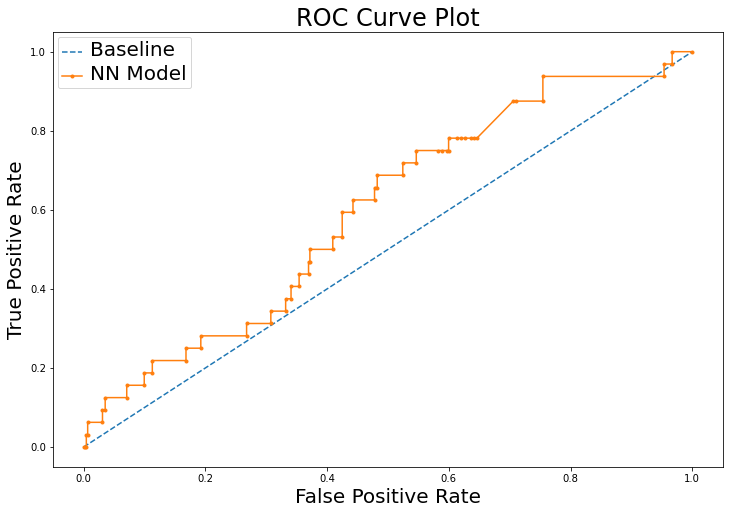

In [15]:
#gathers all output data
out, h = model(Dataset[0].x,Dataset[0].edge_index)
out = out[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]][:, 1]

#gathers all labels
ns_probs = [0 for _ in range(0,len(torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]))]
test = Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]

#finds ROC AUC scores
ns_auc = roc_auc_score(test, ns_probs)
lr_auc = roc_auc_score(test, out.detach().numpy())

# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('GNN Model: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test, out.detach().numpy())

# plot the roc curve for the model
plt.figure(figsize=(12,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='NN Model')

# axis labels
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Plot', fontsize=24)

# show the legend
legend = plt.legend()
plt.setp(legend.get_title(),fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')

# show the plot and saves outputs
plt.show()
np.savetxt("NN_out.csv", (test.detach().numpy(),out.detach().numpy()), delimiter=",")